Names:

Andrei Udriste

Xinyu Hu

Christophe Meijer

In [2]:
import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
plt.style.use("ggplot")

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier, plot_importance

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler

In [3]:
dataset = pd.read_csv("dataset_mood_smartphone.csv", parse_dates=["time"])
dataset

Unnamed: 0       id                    time        variable   value
0                1  AS14.01 2014-02-26 13:00:00.000            mood   6.000
1                2  AS14.01 2014-02-26 15:00:00.000            mood   6.000
2                3  AS14.01 2014-02-26 18:00:00.000            mood   6.000
3                4  AS14.01 2014-02-26 21:00:00.000            mood   7.000
4                5  AS14.01 2014-02-27 09:00:00.000            mood   6.000
...            ...      ...                     ...             ...     ...
376907     2770399  AS14.30 2014-04-11 07:51:16.948  appCat.weather   8.032
376908     2772465  AS14.30 2014-04-19 11:00:32.747  appCat.weather   3.008
376909     2774026  AS14.30 2014-04-26 10:19:07.434  appCat.weather   7.026
376910     2774133  AS14.30 2014-04-27 00:44:48.450  appCat.weather  23.033
376911     2784435  AS14.32 2014-04-07 18:25:14.036  appCat.weather  22.431

[376912 rows x 5 columns]

In [4]:
# because "Unnamed" seems useless, get rid of it from dataset
dataset = dataset.drop("Unnamed: 0", 1)
dataset

id                    time        variable   value
0       AS14.01 2014-02-26 13:00:00.000            mood   6.000
1       AS14.01 2014-02-26 15:00:00.000            mood   6.000
2       AS14.01 2014-02-26 18:00:00.000            mood   6.000
3       AS14.01 2014-02-26 21:00:00.000            mood   7.000
4       AS14.01 2014-02-27 09:00:00.000            mood   6.000
...         ...                     ...             ...     ...
376907  AS14.30 2014-04-11 07:51:16.948  appCat.weather   8.032
376908  AS14.30 2014-04-19 11:00:32.747  appCat.weather   3.008
376909  AS14.30 2014-04-26 10:19:07.434  appCat.weather   7.026
376910  AS14.30 2014-04-27 00:44:48.450  appCat.weather  23.033
376911  AS14.32 2014-04-07 18:25:14.036  appCat.weather  22.431

[376912 rows x 4 columns]

In [5]:
#Obtain all the unique attributes
unique_attributes = dataset.variable.unique()
unique_attributes

array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather'],
      dtype=object)

In [6]:
#Obtain all the unique ids
unique_ids = dataset.id.unique()
unique_ids

array(['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07',
       'AS14.08', 'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15',
       'AS14.16', 'AS14.17', 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24',
       'AS14.25', 'AS14.26', 'AS14.27', 'AS14.28', 'AS14.29', 'AS14.30',
       'AS14.31', 'AS14.32', 'AS14.33'], dtype=object)

In [96]:
len(unique_ids)

26

Text(0, 0.5, 'Data points')

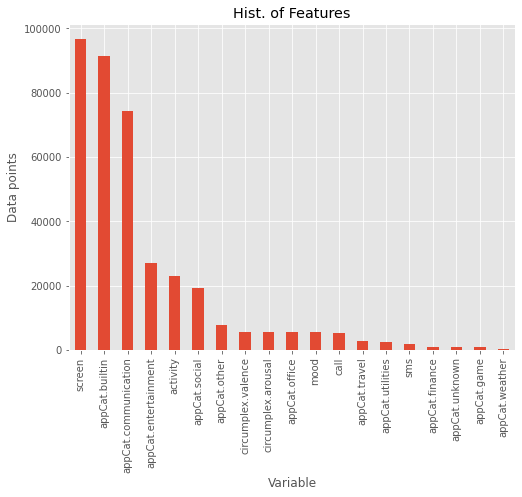

In [7]:
# visualized the dataset by counting variables
hist = pd.DataFrame(dataset.variable.value_counts()).plot(kind='bar', title="Hist. of Features", \
                                                       legend=None, figsize=(8,6))
hist.set_xlabel("Variable")
hist.set_ylabel("Data points")

Text(0, 0.5, 'Data points')

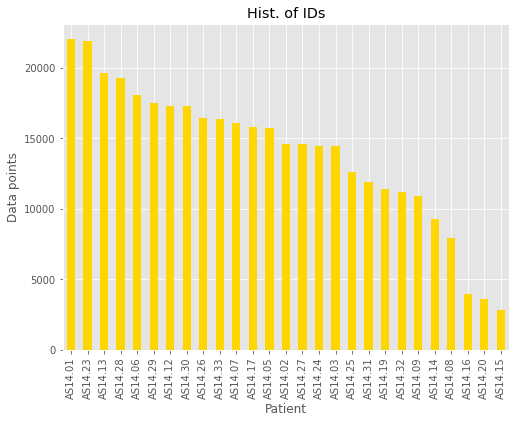

In [8]:
# visualized dataset by counting ids
hist2 = pd.DataFrame(dataset.id.value_counts()).plot(kind="bar", title="Hist. of IDs", \
                                                     legend=None, figsize=(8,6) ,color="gold")
hist2.set_xlabel("Patient")
hist2.set_ylabel("Data points")

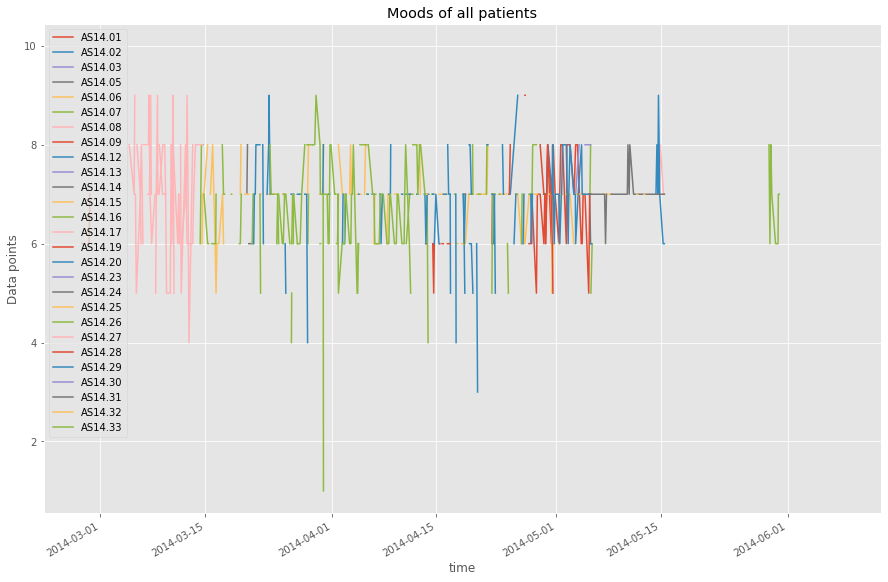

In [9]:
# create an empty dataset which is labeled by ID and time
prodataset = dataset.pivot_table(index=["id","time"], columns="variable",values="value")
# visualized moods of all patients over the time
plt.rcParams["figure.figsize"] = [15,10]
for patient in prodataset.index.levels[0]:
    prodataset.loc[patient]['mood'].plot(label=patient, title="Moods of all patients", ylabel="Data points")
plt.legend();

In [10]:
dataset.set_index("time", inplace=True)

In [11]:
#Created an instance-based database
new_dataset = dataset.pivot_table(index=['id', 'time'], columns=['variable'], values='value')
new_dataset

variable                         activity  appCat.builtin  \
id      time                                                
AS14.01 2014-02-17 12:04:42.394       NaN             NaN   
        2014-02-17 18:28:25.520       NaN             NaN   
        2014-02-18 09:29:51.257       NaN             NaN   
        2014-02-19 14:43:30.575       NaN             NaN   
        2014-02-19 17:29:10.378       NaN             NaN   
...                                   ...             ...   
AS14.33 2014-05-30 22:32:05.016       NaN             NaN   
        2014-05-30 22:32:11.049       NaN           3.122   
        2014-05-30 22:32:14.240       NaN           1.003   
        2014-05-30 22:32:15.246       NaN           4.134   
        2014-05-31 12:00:00.000       NaN             NaN   

variable                         appCat.communication  appCat.entertainment  \
id      time                                                                  
AS14.01 2014-02-17 12:04:42.394                   NaN                   NaN   
        2014-02-17 18:28:25.520                   NaN                   NaN   
        2014-02-18 09:29:51.257                   NaN                   NaN   
        2014-02-19 14:43:30.575                   NaN                   NaN   
        2014-02-19 17:29:10.378                   NaN                   NaN   
...                                               ...                   ...   
AS14.33 2014-05-30 22:32:05.016                   NaN                   NaN   
        2014-05-30 22:32:11.049                   NaN                   NaN   
        2014-05-30 22:32:14.240                   NaN                   NaN   
        2014-05-30 22:32:15.246                   NaN                   NaN   
        2014-05-31 12:00:00.000                   NaN                   NaN   

variable                         appCat.finance  appCat.game  appCat.office  \
id      time                                                                  
AS14.01 2014-02-17 12:04:42.394             NaN          NaN            NaN   
        2014-02-17 18:28:25.520             NaN          NaN            NaN   
        2014-02-18 09:29:51.257             NaN          NaN            NaN   
        2014-02-19 14:43:30.575             NaN          NaN            NaN   
        2014-02-19 17:29:10.378             NaN          NaN            NaN   
...                                         ...          ...            ...   
AS14.33 2014-05-30 22:32:05.016             NaN          NaN            NaN   
        2014-05-30 22:32:11.049             NaN          NaN            NaN   
        2014-05-30 22:32:14.240             NaN          NaN            NaN   
        2014-05-30 22:32:15.246             NaN          NaN            NaN   
        2014-05-31 12:00:00.000             NaN          NaN            NaN   

variable                         appCat.other  appCat.social  appCat.travel  \
id      time                                                                  
AS14.01 2014-02-17 12:04:42.394           NaN            NaN            NaN   
        2014-02-17 18:28:25.520           NaN            NaN            NaN   
        2014-02-18 09:29:51.257           NaN            NaN            NaN   
        2014-02-19 14:43:30.575           NaN            NaN            NaN   
        2014-02-19 17:29:10.378           NaN            NaN            NaN   
...                                       ...            ...            ...   
AS14.33 2014-05-30 22:32:05.016           NaN            NaN            NaN   
        2014-05-30 22:32:11.049           NaN            NaN            NaN   
        2014-05-30 22:32:14.240           NaN            NaN            NaN   
        2014-05-30 22:32:15.246           NaN            NaN            NaN   
        2014-05-31 12:00:00.000           NaN            NaN            NaN   

variable                         appCat.unknown  appCat.utilities  \
id      time                                         

In [12]:
#Transform the first index(each patient) into a column "id"
new_dataset.reset_index(level=0, inplace=True)
new_dataset

variable                      id  activity  appCat.builtin  \
time                                                         
2014-02-17 12:04:42.394  AS14.01       NaN             NaN   
2014-02-17 18:28:25.520  AS14.01       NaN             NaN   
2014-02-18 09:29:51.257  AS14.01       NaN             NaN   
2014-02-19 14:43:30.575  AS14.01       NaN             NaN   
2014-02-19 17:29:10.378  AS14.01       NaN             NaN   
...                          ...       ...             ...   
2014-05-30 22:32:05.016  AS14.33       NaN             NaN   
2014-05-30 22:32:11.049  AS14.33       NaN           3.122   
2014-05-30 22:32:14.240  AS14.33       NaN           1.003   
2014-05-30 22:32:15.246  AS14.33       NaN           4.134   
2014-05-31 12:00:00.000  AS14.33       NaN             NaN   

variable                 appCat.communication  appCat.entertainment  \
time                                                                  
2014-02-17 12:04:42.394                   NaN                   NaN   
2014-02-17 18:28:25.520                   NaN                   NaN   
2014-02-18 09:29:51.257                   NaN                   NaN   
2014-02-19 14:43:30.575                   NaN                   NaN   
2014-02-19 17:29:10.378                   NaN                   NaN   
...                                       ...                   ...   
2014-05-30 22:32:05.016                   NaN                   NaN   
2014-05-30 22:32:11.049                   NaN                   NaN   
2014-05-30 22:32:14.240                   NaN                   NaN   
2014-05-30 22:32:15.246                   NaN                   NaN   
2014-05-31 12:00:00.000                   NaN                   NaN   

variable                 appCat.finance  appCat.game  appCat.office  \
time                                                                  
2014-02-17 12:04:42.394             NaN          NaN            NaN   
2014-02-17 18:28:25.520             NaN          NaN            NaN   
2014-02-18 09:29:51.257             NaN          NaN            NaN   
2014-02-19 14:43:30.575             NaN          NaN            NaN   
2014-02-19 17:29:10.378             NaN          NaN            NaN   
...                                 ...          ...            ...   
2014-05-30 22:32:05.016             NaN          NaN            NaN   
2014-05-30 22:32:11.049             NaN          NaN            NaN   
2014-05-30 22:32:14.240             NaN          NaN            NaN   
2014-05-30 22:32:15.246             NaN          NaN            NaN   
2014-05-31 12:00:00.000             NaN          NaN            NaN   

variable                 appCat.other  appCat.social  appCat.travel  \
time                                                                  
2014-02-17 12:04:42.394           NaN            NaN            NaN   
2014-02-17 18:28:25.520           NaN            NaN            NaN   
2014-02-18 09:29:51.257           NaN            NaN            NaN   
2014-02-19 14:43:30.575           NaN            NaN            NaN   
2014-02-19 17:29:10.378           NaN            NaN            NaN   
...                               ...            ...            ...   
2014-05-30 22:32:05.016           NaN            NaN            NaN   
2014-05-30 22:32:11.049           NaN            NaN            NaN   
2014-05-30 22:32:14.240           NaN            NaN            NaN   
2014-05-30 22:32:15.246           NaN            NaN            NaN   
2014-05-31 12:00:00.000           NaN            NaN            NaN   

variable                 appCat.unknown  appCat.utilities  appCat.weather  \
time                                                                        
2014-02-17 12:04:42.394             NaN               NaN             NaN   
2014-02-17 18:28:25.520             NaN               NaN             NaN   
2014-02-18 09:29:51.257             NaN               NaN             NaN   
2014-02-19 14:43:30.575             

In [13]:
new_dataset.describe() 

variable      activity  appCat.builtin  appCat.communication  \
count     22965.000000    91288.000000          74276.000000   
mean          0.115958       18.538262             43.343792   
std           0.186946      415.989243            128.912750   
min           0.000000   -82798.871000              0.006000   
25%           0.000000        2.020000              5.218000   
50%           0.021739        4.038000             16.225500   
75%           0.158333        9.922000             45.475750   
max           1.000000    33960.246000           9830.777000   

variable  appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
count             27125.000000      939.000000   813.000000    5642.000000   
mean                 37.576480       21.755251   128.391615      22.578892   
std                 262.960476       39.218361   327.145246     449.601382   
min                  -0.011000        0.131000     1.003000       0.003000   
25%                   1.334000        4.072000    14.148000       2.004000   
50%                   3.391000        8.026000    43.168000       3.106000   
75%                  14.922000       20.155000   123.625000       8.043750   
max               32148.677000      355.513000  5491.793000   32708.818000   

variable  appCat.other  appCat.social  appCat.travel  appCat.unknown  \
count      7650.000000   19145.000000    2846.000000      939.000000   
mean         25.810839      72.401906      45.730850       45.553006   
std         112.781355     261.551846     246.109307      119.400405   
min           0.014000       0.094000       0.080000        0.111000   
25%           7.019000       9.030000       5.086500        5.018000   
50%          10.028000      28.466000      18.144000       17.190000   
75%          16.829250      75.372000      47.227250       44.430500   
max        3892.038000   30000.906000   10452.615000     2239.937000   

variable  appCat.utilities  appCat.weather    call  circumplex.arousal  \
count          2487.000000      255.000000  5239.0         5582.000000   
mean             18.537552       20.148714     1.0           -0.098173   
std              60.959134       24.943431     0.0            1.051164   
min               0.246000        1.003000     1.0           -2.000000   
25%               3.158500        8.684000     1.0           -1.000000   
50%               8.030000       15.117000     1.0            0.000000   
75%              19.331000       25.349000     1.0            1.000000   
max            1802.649000      344.863000     1.0            2.000000   

variable  circumplex.valence         mood        screen     sms  
count            5474.000000  5628.000000  96578.000000  1798.0  
mean                0.688893     6.993870     75.335206     1.0  
std                 0.670048     1.031496    253.822497     0.0  
min                -2.000000     1.000000      0.035000     1.0  
25%                 0.000000     7.000000      5.322250     1.0  
50%                 1.000000     7.000000     20.044500     1.0  
75%                 1.000000     8.000000     62.540250     1.0  
max                 2.000000    10.000000   9867.007000     1.0

In [14]:
#Group each datased by theier respective ids
group_dataset = new_dataset.groupby(["id"])
group_dataset.get_group("AS14.30")

variable                      id  activity  appCat.builtin  \
time                                                         
2014-02-17 20:38:00.928  AS14.30       NaN             NaN   
2014-02-18 12:07:07.164  AS14.30       NaN             NaN   
2014-02-18 18:20:52.088  AS14.30       NaN             NaN   
2014-02-20 15:26:16.441  AS14.30       NaN             NaN   
2014-02-21 16:11:08.698  AS14.30       NaN             NaN   
...                          ...       ...             ...   
2014-05-04 19:57:46.467  AS14.30       NaN             NaN   
2014-05-04 21:00:00.000  AS14.30       NaN             NaN   
2014-05-05 09:00:00.000  AS14.30       NaN             NaN   
2014-05-05 13:00:00.000  AS14.30       NaN             NaN   
2014-05-05 15:00:00.000  AS14.30       NaN             NaN   

variable                 appCat.communication  appCat.entertainment  \
time                                                                  
2014-02-17 20:38:00.928                   NaN                   NaN   
2014-02-18 12:07:07.164                   NaN                   NaN   
2014-02-18 18:20:52.088                   NaN                   NaN   
2014-02-20 15:26:16.441                   NaN                   NaN   
2014-02-21 16:11:08.698                   NaN                   NaN   
...                                       ...                   ...   
2014-05-04 19:57:46.467                   NaN                   NaN   
2014-05-04 21:00:00.000                   NaN                   NaN   
2014-05-05 09:00:00.000                   NaN                   NaN   
2014-05-05 13:00:00.000                   NaN                   NaN   
2014-05-05 15:00:00.000                   NaN                   NaN   

variable                 appCat.finance  appCat.game  appCat.office  \
time                                                                  
2014-02-17 20:38:00.928             NaN          NaN            NaN   
2014-02-18 12:07:07.164             NaN          NaN            NaN   
2014-02-18 18:20:52.088             NaN          NaN            NaN   
2014-02-20 15:26:16.441             NaN          NaN            NaN   
2014-02-21 16:11:08.698             NaN          NaN            NaN   
...                                 ...          ...            ...   
2014-05-04 19:57:46.467             NaN          NaN            NaN   
2014-05-04 21:00:00.000             NaN          NaN            NaN   
2014-05-05 09:00:00.000             NaN          NaN            NaN   
2014-05-05 13:00:00.000             NaN          NaN            NaN   
2014-05-05 15:00:00.000             NaN          NaN            NaN   

variable                 appCat.other  appCat.social  appCat.travel  \
time                                                                  
2014-02-17 20:38:00.928           NaN            NaN            NaN   
2014-02-18 12:07:07.164           NaN            NaN            NaN   
2014-02-18 18:20:52.088           NaN            NaN            NaN   
2014-02-20 15:26:16.441           NaN            NaN            NaN   
2014-02-21 16:11:08.698           NaN            NaN            NaN   
...                               ...            ...            ...   
2014-05-04 19:57:46.467           NaN         45.159            NaN   
2014-05-04 21:00:00.000           NaN            NaN            NaN   
2014-05-05 09:00:00.000           NaN            NaN            NaN   
2014-05-05 13:00:00.000           NaN            NaN            NaN   
2014-05-05 15:00:00.000           NaN            NaN            NaN   

variable                 appCat.unknown  appCat.utilities  appCat.weather  \
time                                                                        
2014-02-17 20:38:00.928             NaN               NaN             NaN   
2014-02-18 12:07:07.164             NaN               NaN             NaN   
2014-02-18 18:20:52.088             NaN               NaN             NaN   
2014-02-20 15:26:16.441             

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

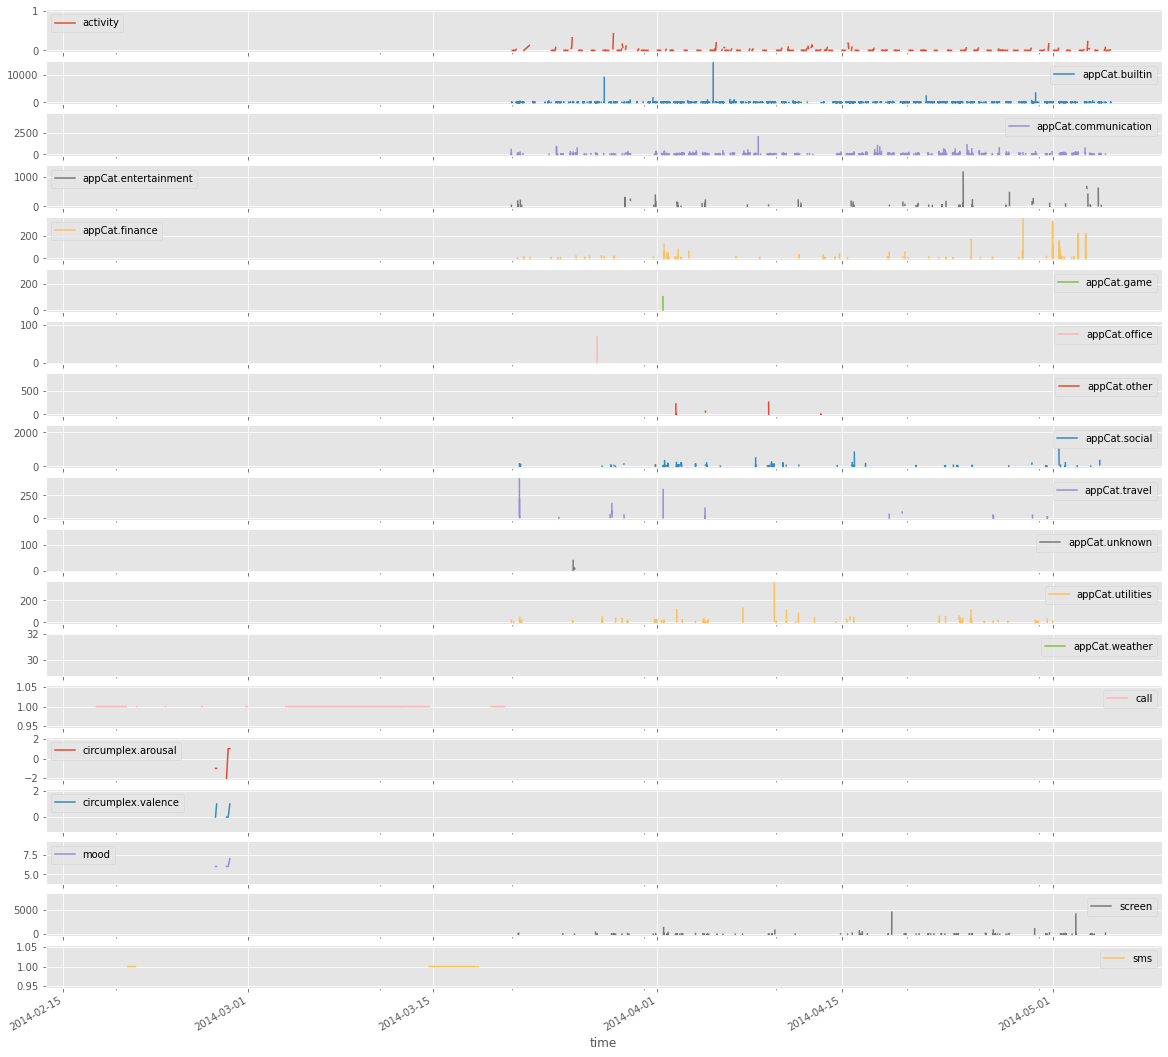

In [15]:
group_dataset.get_group('AS14.01').plot(subplots=True, figsize=(20, 20))

In [16]:
#Verify if more than 30% of the data  is missing
def check_missing_data(data, pass_p=30):
    """Returns a list with the attributes that have more than 30% of theier data missing"""
    missing_attributes = list()
    missing_values = data.isna().sum() * 100 / len(data)

    for attribute in unique_attributes:
        if missing_values[attribute] > pass_p:
            missing_attributes.append(attribute)
            
    return missing_attributes

In [17]:
def freq_miss_atr(nr_miss_atr: dict, list_miss_atr: list):
    """
    Increments thee number of times a attribute has been found in the missing atributes list 
    obtained from  the function *check_missing_data*
    """
    for attribute in list_miss_atr:
        if attribute not in nr_miss_atr:
            nr_miss_atr[attribute] = 1
        else:
            nr_miss_atr[attribute] += 1

In [18]:
def cut_outliers(data, cutoff_value = 10):
    """Remove the data row if too many of the attributes are missing"""
    data["cut"] = resampled_data.isnull().sum(axis=1) > cutoff_value
    data.drop(data[data.cut].index, inplace=True)

In [19]:
freq_of_miss_atrtributes = dict() #Dictionary that contains the number of times an attribute has more than 30% of te data missing
list_of_miss_atr_and_id = list() #List with all the ids and the attributes that have more than 30% of the data missing
preprocesed_data = dict() #Dictionary that contains the new DataFrame after the preeprocessing has been done

for id in unique_ids:
    resampled_data = group_dataset.get_group(id).resample('D').mean() #Resample the data and mean over each day

    resampled_data["call"] = resampled_data["call"].fillna(0) #Fill all the missing values with 0
    resampled_data["sms"] = resampled_data["sms"].fillna(0) #Fill all the missing values with 0

    resampled_data.dropna(subset=["mood"], inplace=True) #Discard any missing values from the mood

    list_miss_atr = check_missing_data(resampled_data) #Obtain the list of all the missing attributes for the current patient
    list_of_miss_atr_and_id.append((id, list_miss_atr)) #Add the patient and the list of missing attributes to the specific list
    freq_miss_atr(freq_of_miss_atrtributes, list_miss_atr) #Inrement the values of the dictionary the contains the missing attributes
    
    cut_outliers(resampled_data) #Remove all the temporal outliers

    preprocesed_data[id] = resampled_data #Save the preprocesed data in the dictionary with the key as the id

In [20]:
freq_of_miss_atrtributes #Verify the frequency of the missing attributes

{'appCat.finance': 27,
 'appCat.game': 24,
 'appCat.office': 26,
 'appCat.travel': 26,
 'appCat.unknown': 25,
 'appCat.weather': 27,
 'appCat.utilities': 24,
 'appCat.social': 11,
 'appCat.entertainment': 13,
 'appCat.communication': 3,
 'appCat.other': 4,
 'activity': 1,
 'screen': 1,
 'appCat.builtin': 1}

In [21]:
def del_id(id_and_atr, dict_of_atr, pass_val = 1):
    """
    Verify which attibutes have a frequency smaller than the pass value and adds the attribte id to the ids delete list.
    Return the list with all lthe patients that need to be removed from the DataFrame
    """
    id_to_del = list()
    for atr in dict_of_atr:
        if dict_of_atr[atr] <= pass_val:
            for id, del_atr in id_and_atr:
                if atr in del_atr and id not in id_to_del:
                    id_to_del.append(id)
    return id_to_del

In [22]:
ids_to_delete = del_id(list_of_miss_atr_and_id, freq_of_miss_atrtributes)
ids_to_delete

['AS14.26']

In [23]:
def del_key(dict_of_freq, pass_val=1):
    """Deletes the keys that have a smaller value than the specified pass value"""
    delete_keys = list()

    for key in dict_of_freq:
        if dict_of_freq[key] <= pass_val:
            delete_keys.append(key)

    for key_to_delete in delete_keys:
        del dict_of_freq[key_to_delete]
        
    return dict_of_freq

In [24]:
freq_of_miss_atrtributes = del_key(freq_of_miss_atrtributes)
freq_of_miss_atrtributes

{'appCat.finance': 27,
 'appCat.game': 24,
 'appCat.office': 26,
 'appCat.travel': 26,
 'appCat.unknown': 25,
 'appCat.weather': 27,
 'appCat.utilities': 24,
 'appCat.social': 11,
 'appCat.entertainment': 13,
 'appCat.communication': 3,
 'appCat.other': 4}

In [25]:
#Delete the ids that are in the ids_to_delete list from the preprocesd data
for id in ids_to_delete:
    del preprocesed_data[id]
    unique_ids = np.delete(unique_ids,  np.where(unique_ids == id))

In [26]:
for id_key in preprocesed_data:
    #Delete all the columns that have to manny missing value in the DataFrame
    preprocesed_data[id_key].drop(columns=freq_of_miss_atrtributes.keys(), inplace=True)
    #Replace all the missing value with the median values for the remaining columns
    preprocesed_data[id_key].fillna( preprocesed_data[id_key].median(), inplace=True)

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

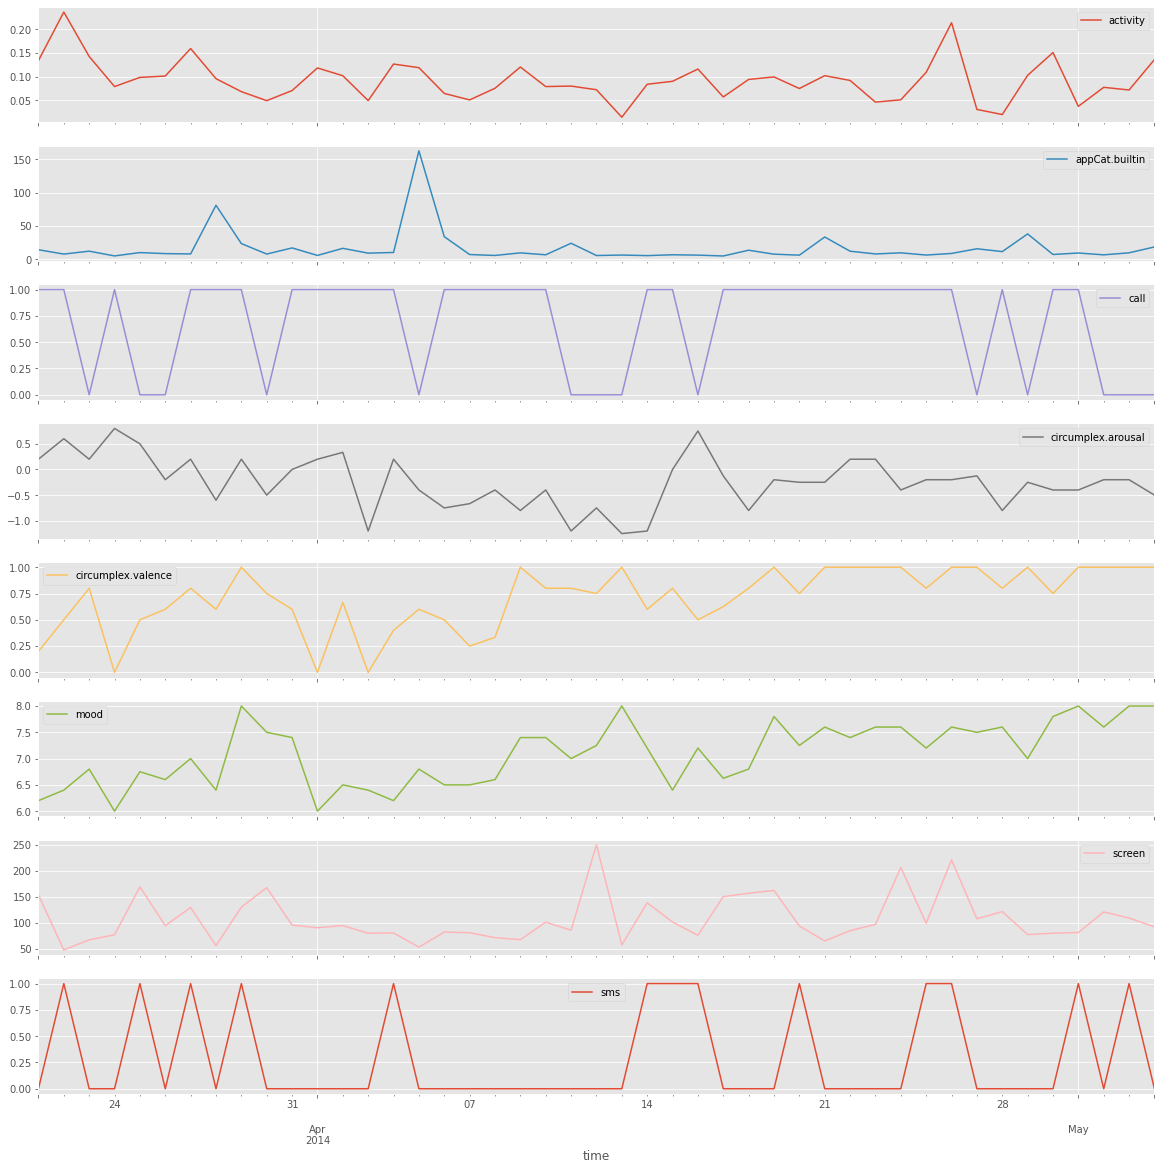

In [27]:
preprocesed_data['AS14.01'].plot(subplots=True, figsize=(20, 20))

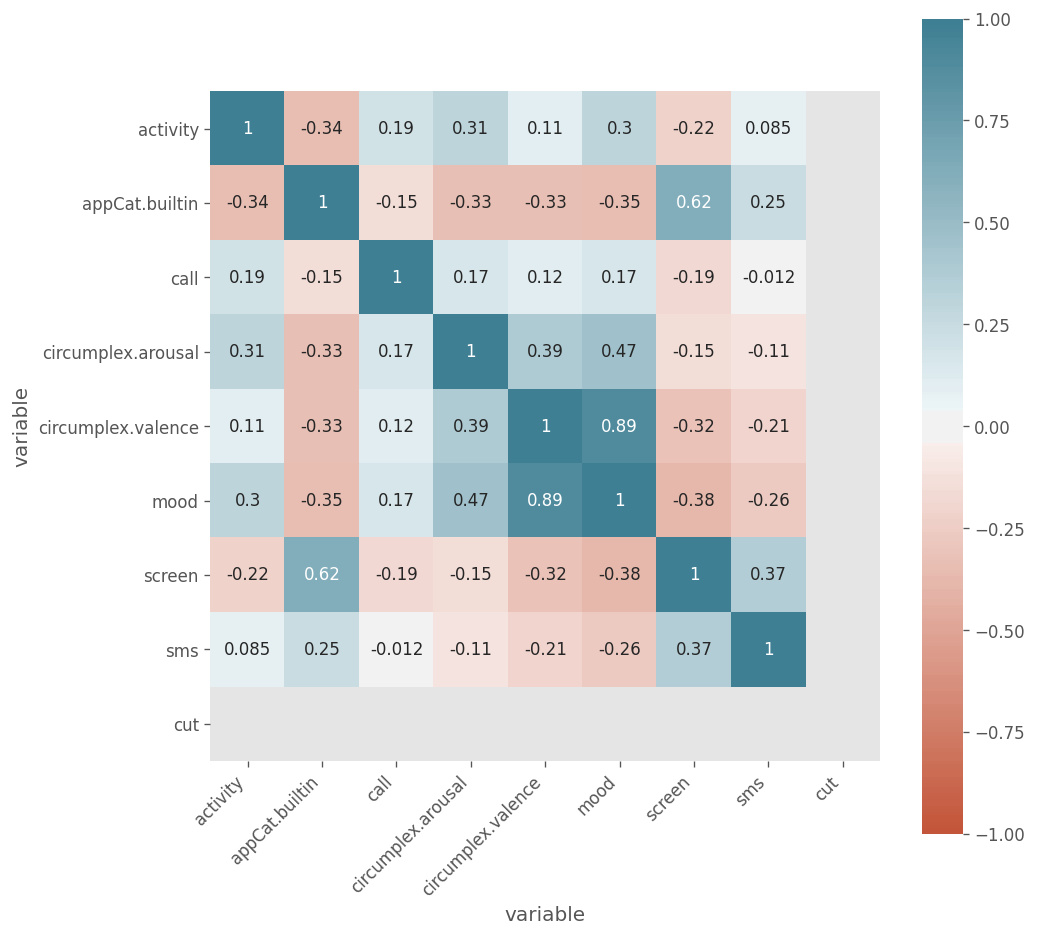

In [28]:
#Create a corelation matrix to see the corelation between each attribute
plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})

corr = preprocesed_data['AS14.05'].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [29]:
#Delete the attributes that have a big corelation or are not useful
for id_key in preprocesed_data:
    preprocesed_data[id_key].drop(columns=["circumplex.valence", "cut"], inplace=True)

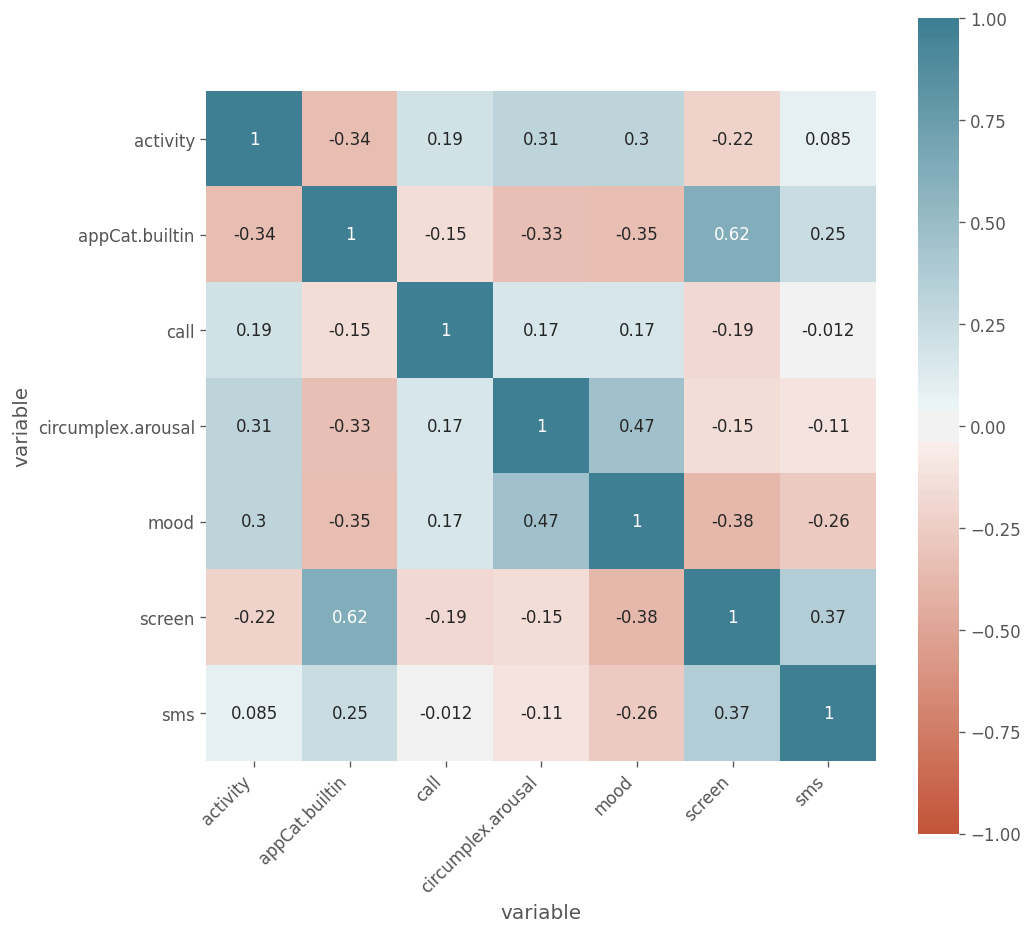

In [30]:
#Create a new corelation matrix using the new dataset
plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})

corr = preprocesed_data['AS14.05'].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Create the models

Create test and train data

In [31]:
def separate_data(data, p=0.3):
    """Separate the data into training data and test data, based on a specified procentage"""
    test_data_len = int(len(data) * p)
    train_data = data[:-test_data_len]
    test_data = data[-test_data_len:]
    return train_data, test_data

In [32]:
train_data_ids = dict() #Dictionary containg the training DataFrame for each patient
test_data_ids = dict() #Dictionary containg the testing DataFrame for each patient

for id in unique_ids:
    train_data_ids[id], test_data_ids[id] = separate_data(preprocesed_data[id])

Create a Baselines

In [33]:
def create_baseline(test_data, b_type="base", sliding_w=5, p_chance=0.3):
    """
    Funtions that create a simple baseline based on the test_data, there are three different optiond for the baseline
    base: the baseline is v=created by considering that the curent day value is the same as the previous day value

    ma: the curent day value is based on the mean of a sliding window of the previous day value

    prob: the curent day is based on the previous day value, but there is a probability 
    that to that value will be added a number extracted from a normal distribution obtained using np.uniform(-0.5, 0.5)
    """
    if b_type == "base":
        baseline = np.repeat(test_data[1], len(test_data))

    if b_type == "ma":
        baseline = test_data[-sliding_w:]
        for _ in range(len(test_data)):
            baseline = np.append(baseline, np.mean(baseline[-sliding_w:]))
        baseline = baseline[-len(test_data):]
    
    if b_type == "prob":
        baseline = np.array([test_data[1]])
        while len(baseline) < len(test_data):
            if np.random.choice([True, False], 1, p=[p_chance, 1-p_chance]):
                change = np.random.uniform(-0.5, 0.5, 1)
                baseline = np.append(baseline, baseline[-1:] + change)
            else:
                baseline = np.append(baseline, baseline[-1:])

    return baseline

In [34]:
base_baseline = dict()
ma_baseline = dict()
prob_baseline = dict()

for id in unique_ids:
    base_baseline[id] = create_baseline(test_data_ids[id]["mood"].values, b_type="base")
    ma_baseline[id] = create_baseline(test_data_ids[id]["mood"].values, b_type="ma")
    prob_baseline[id] = create_baseline(test_data_ids[id]["mood"].values, b_type="prob",)

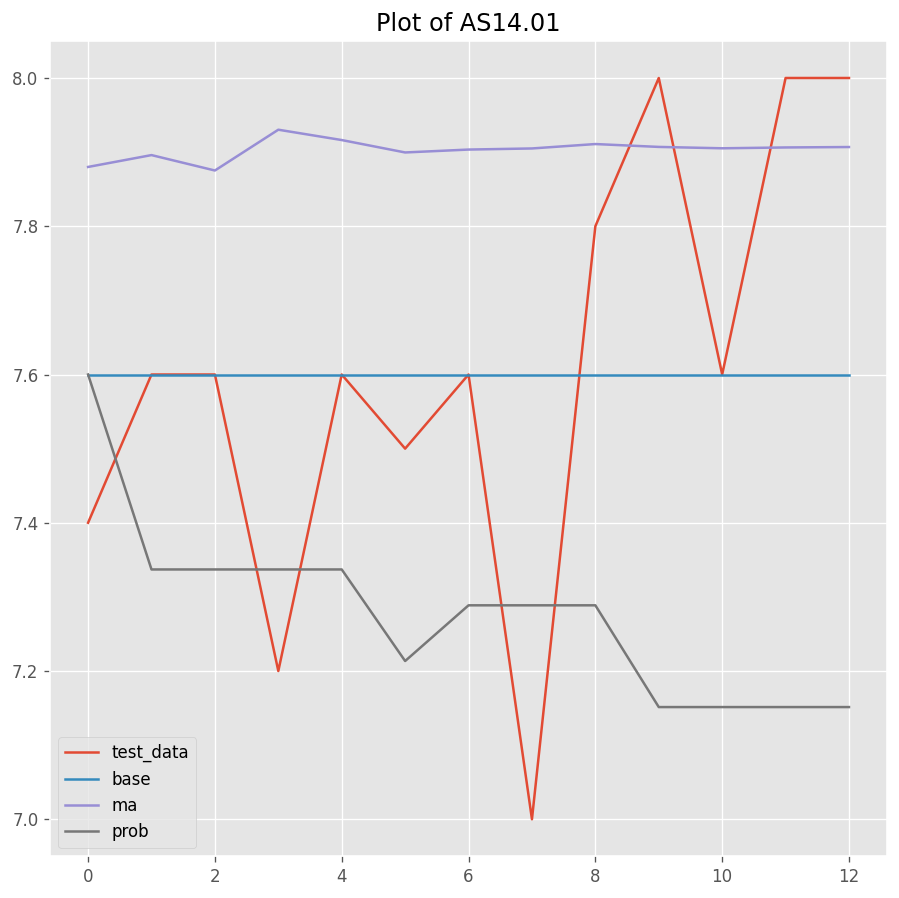

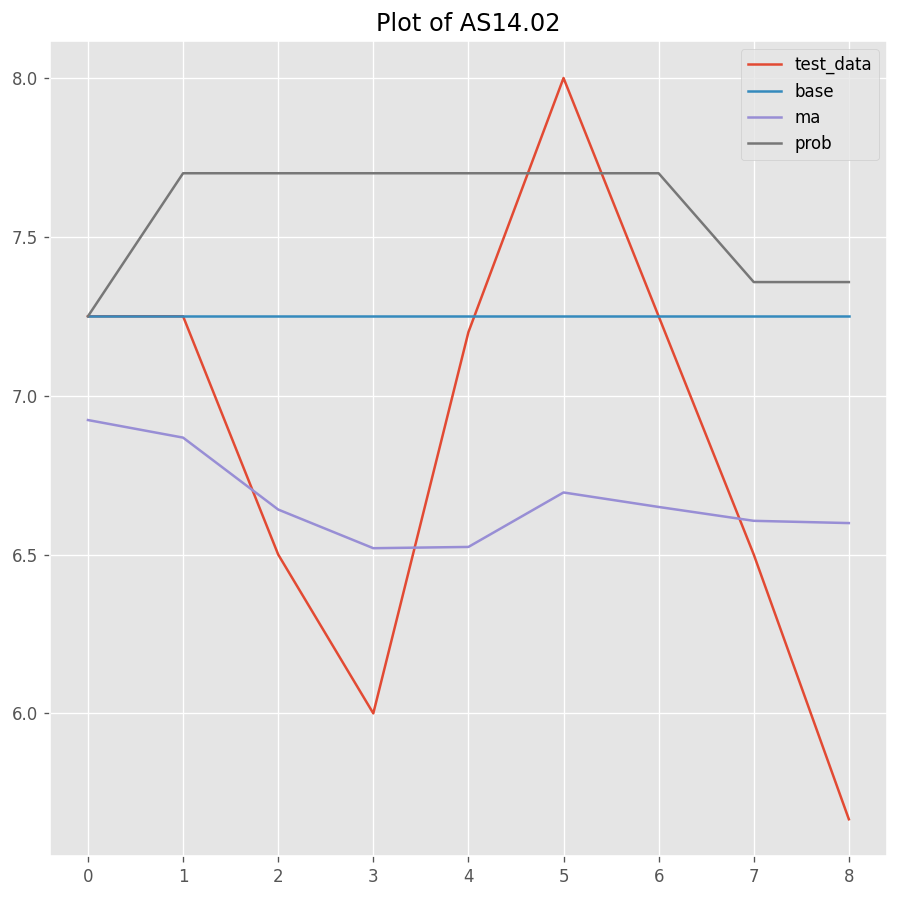

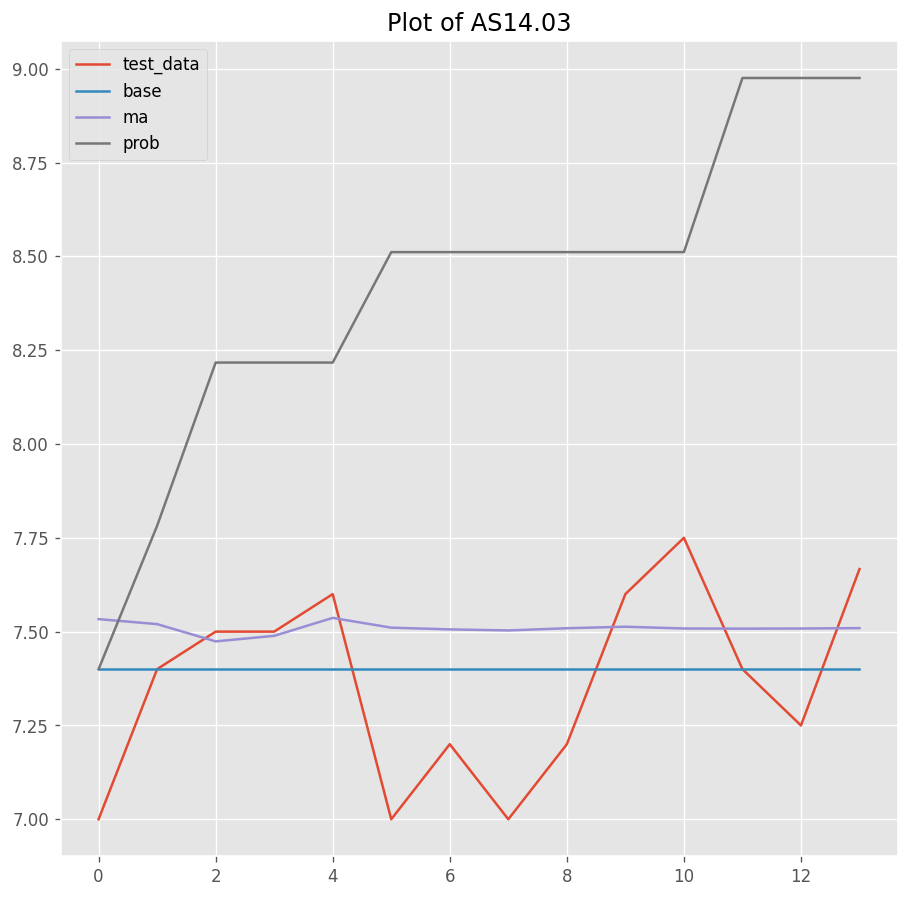

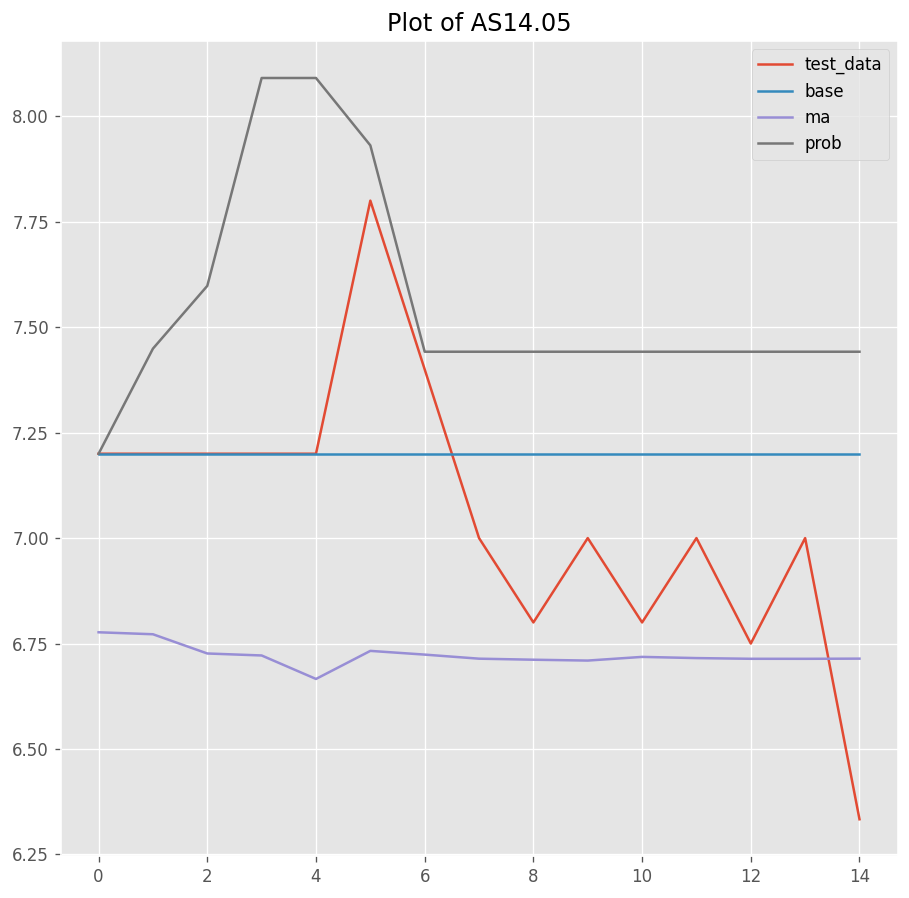

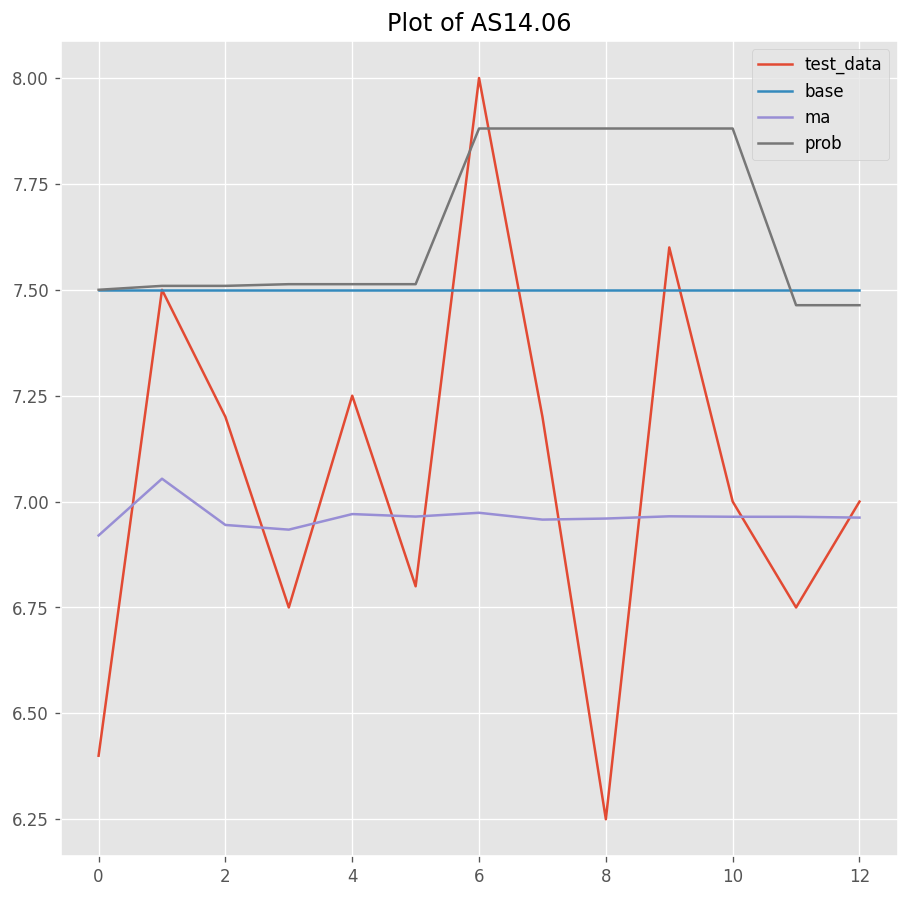

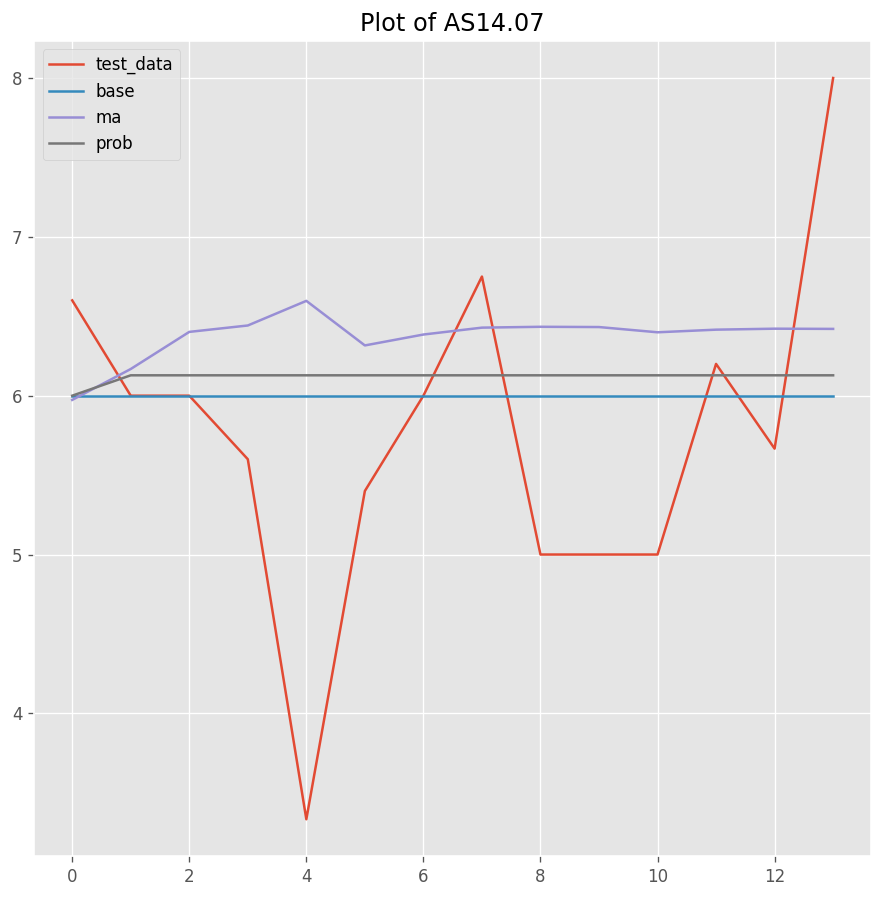

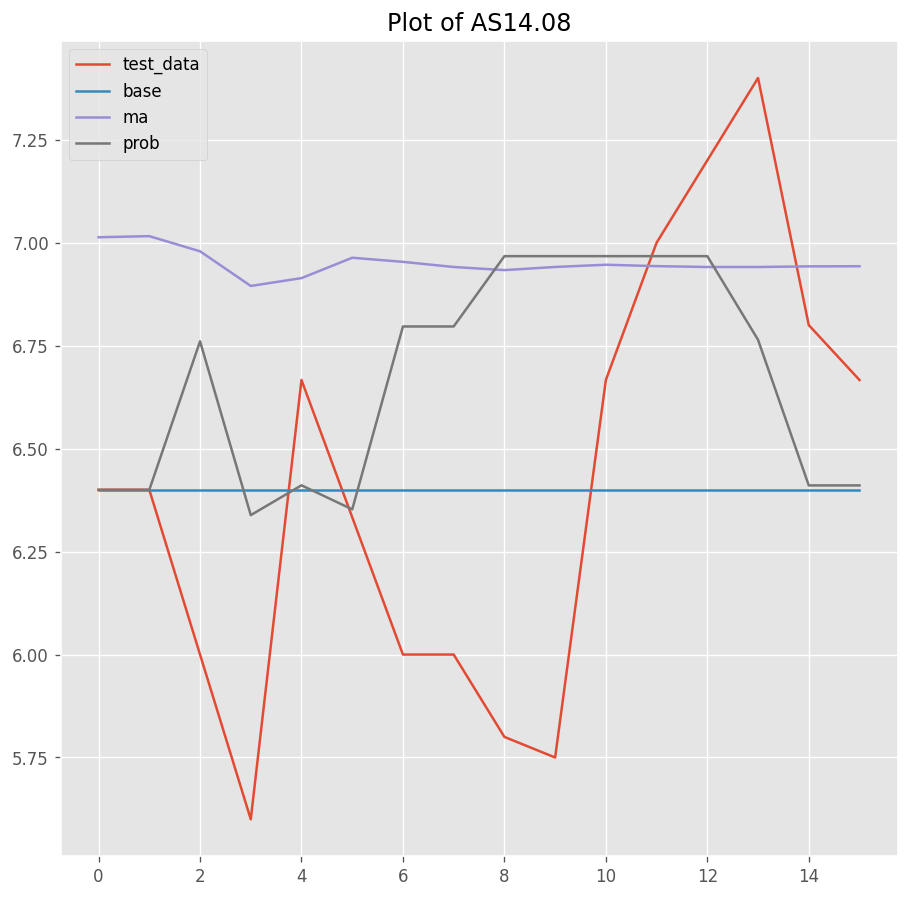

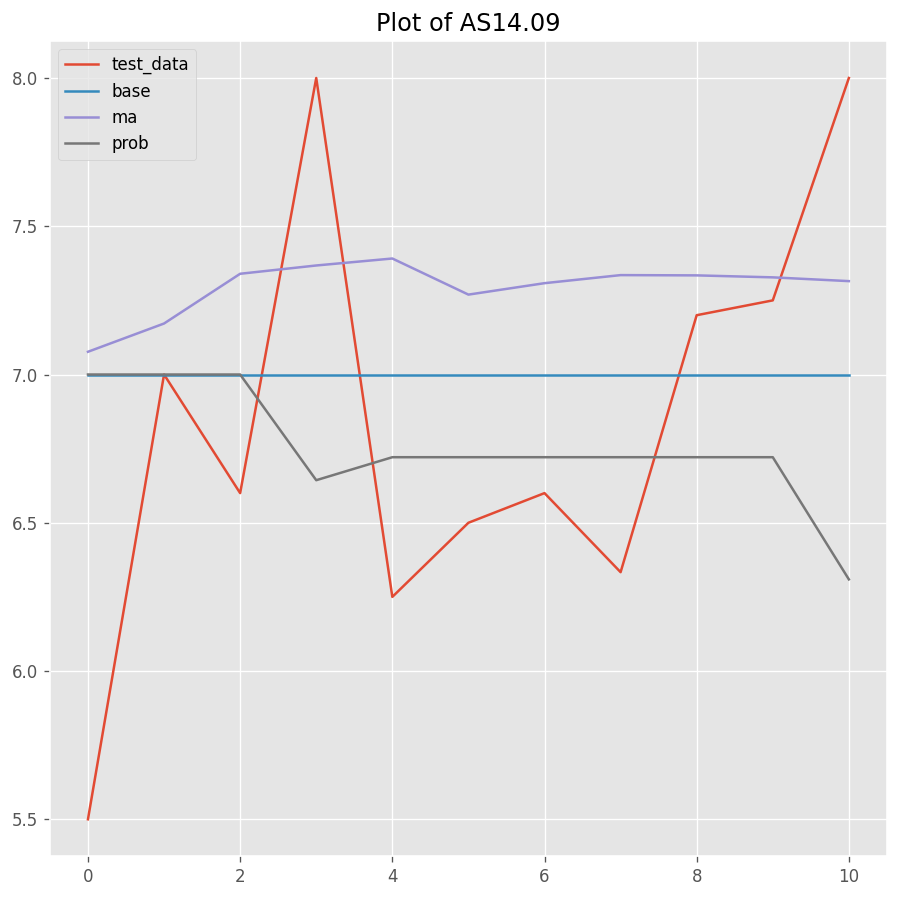

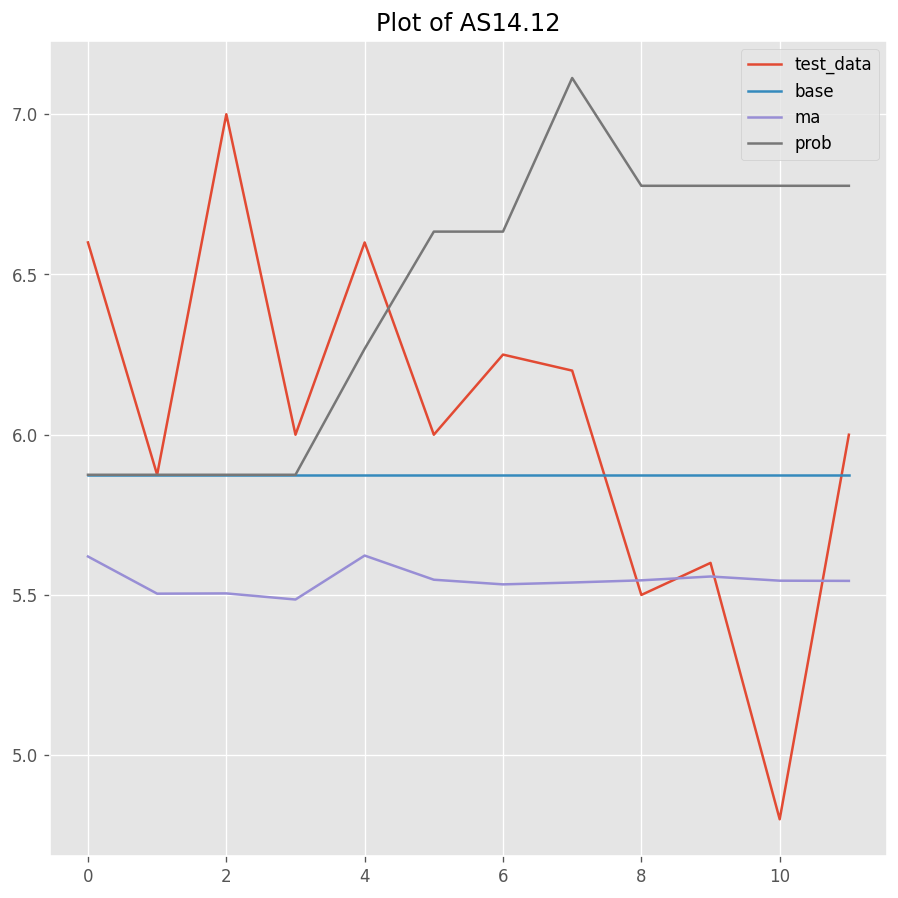

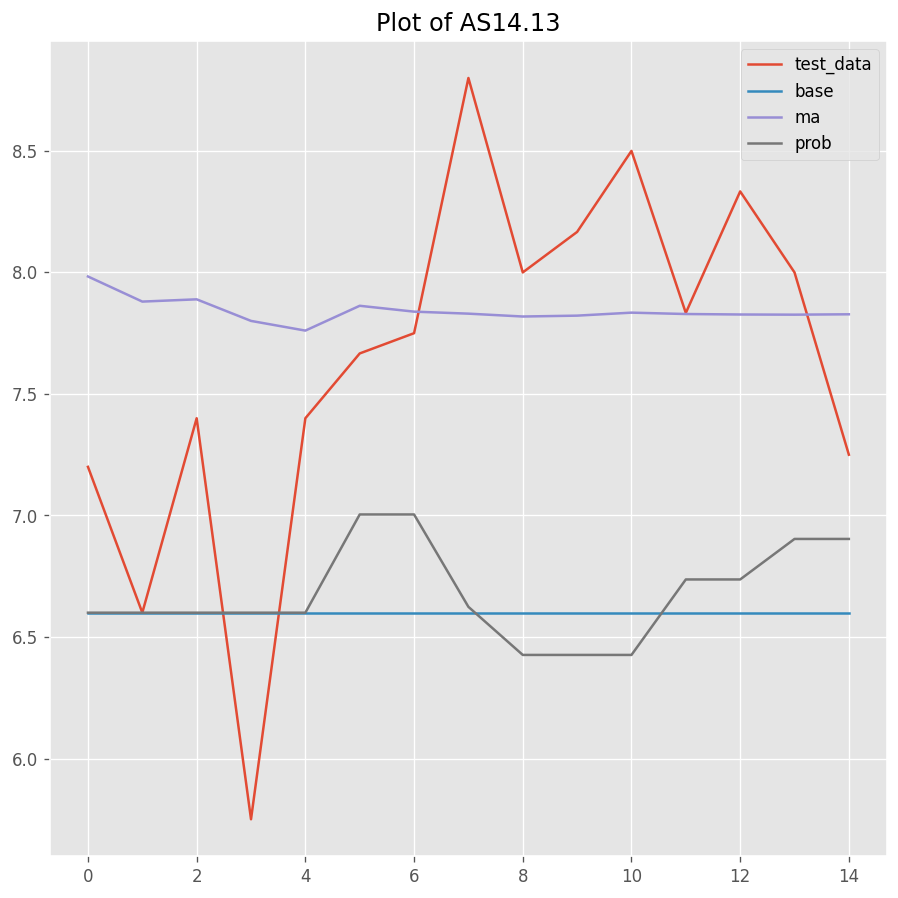

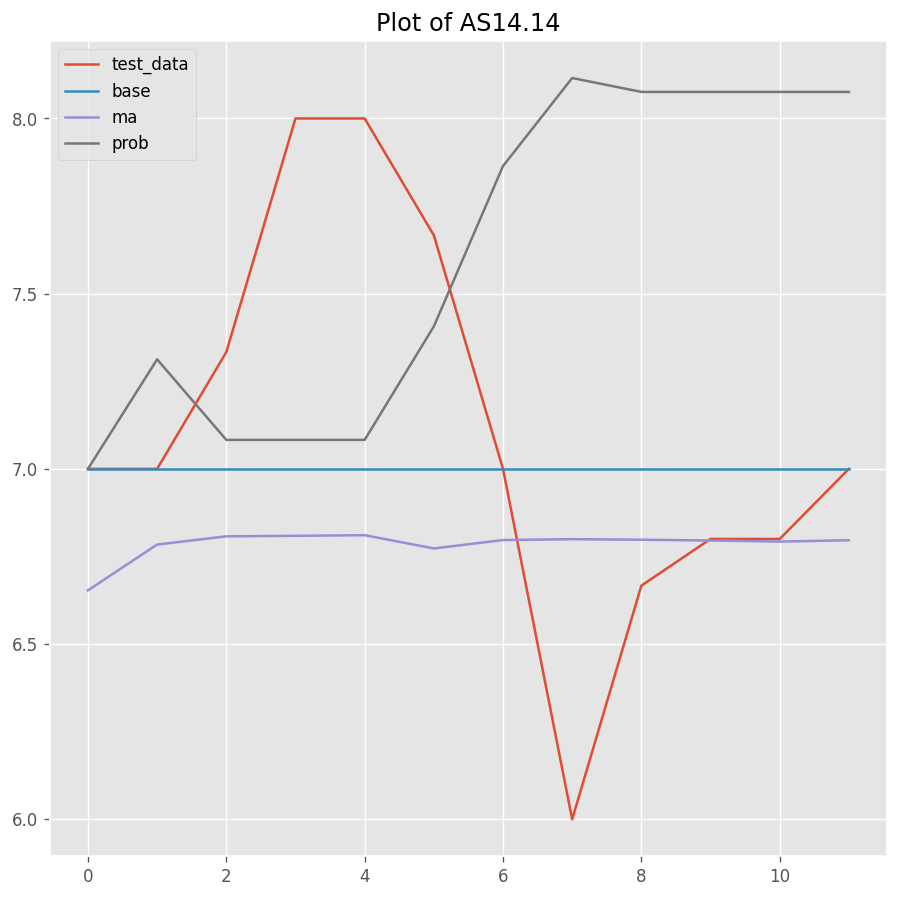

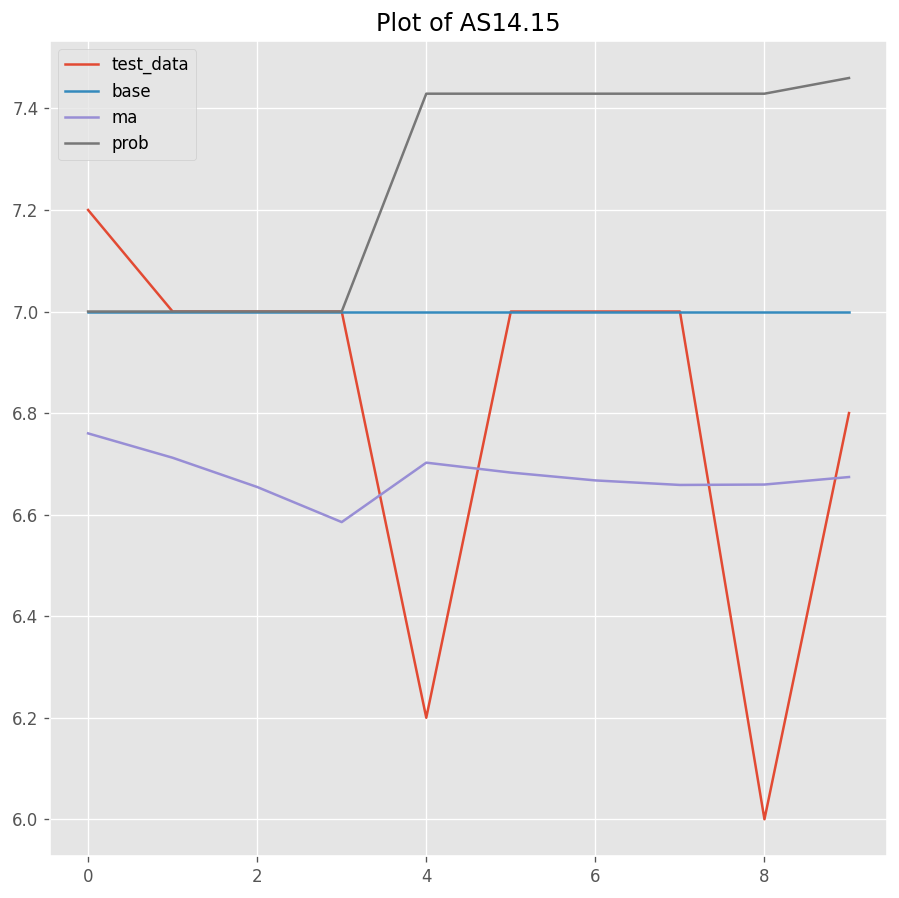

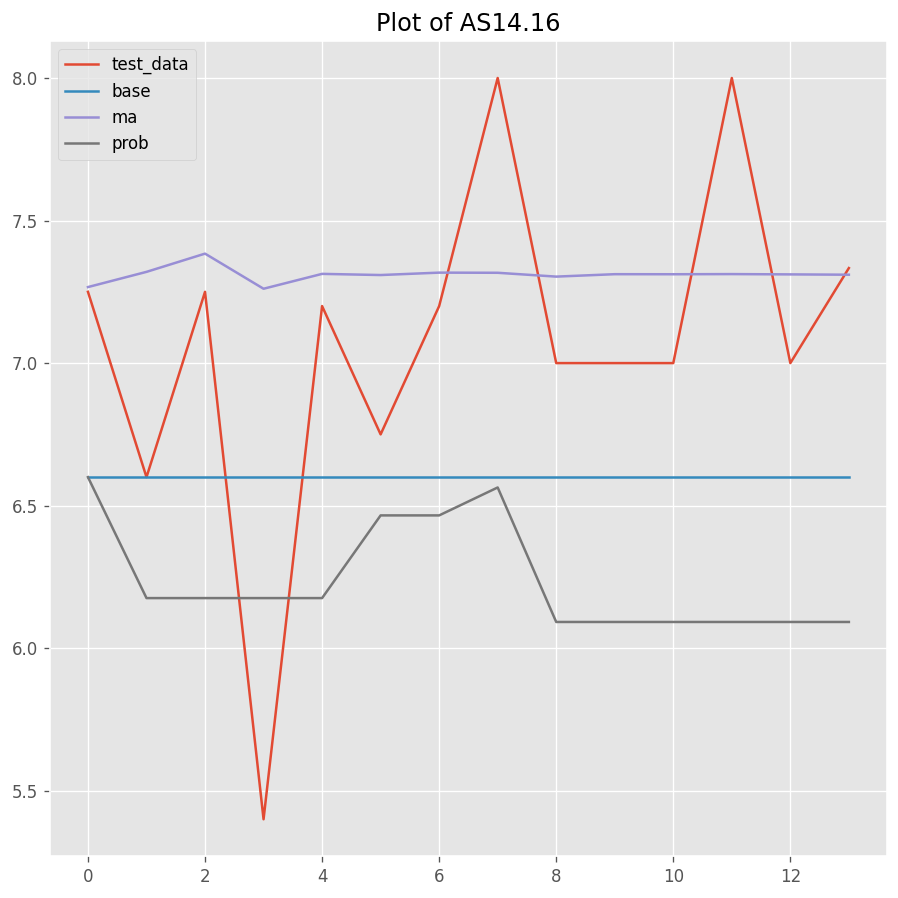

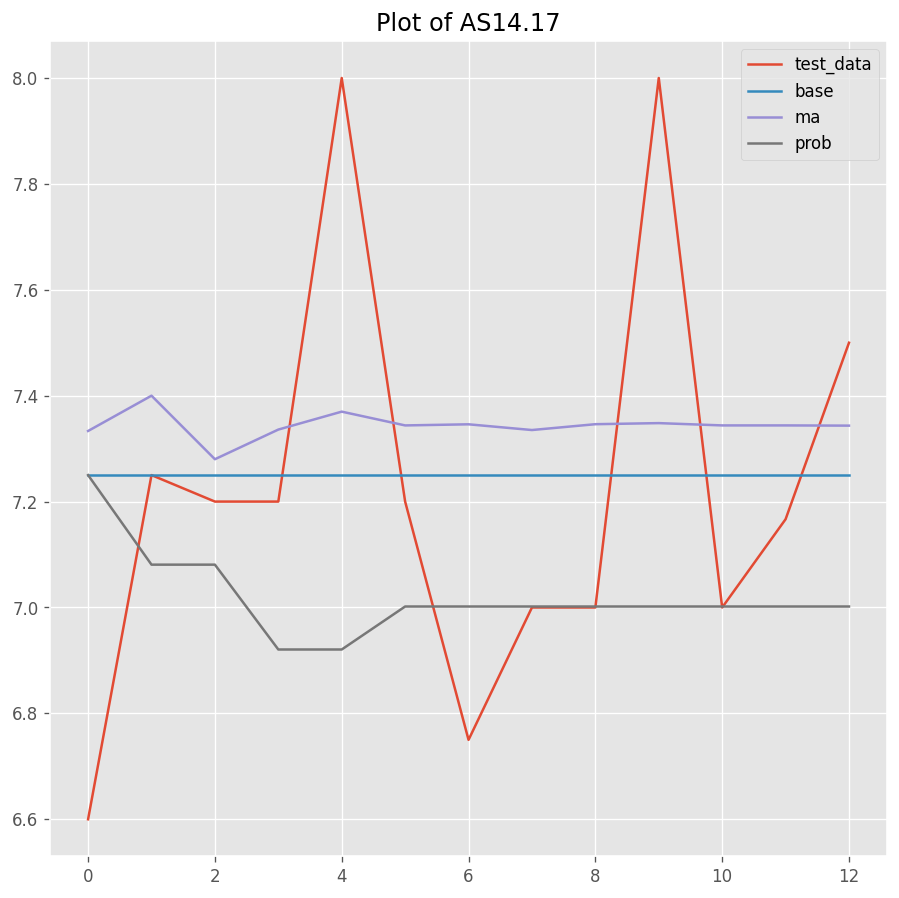

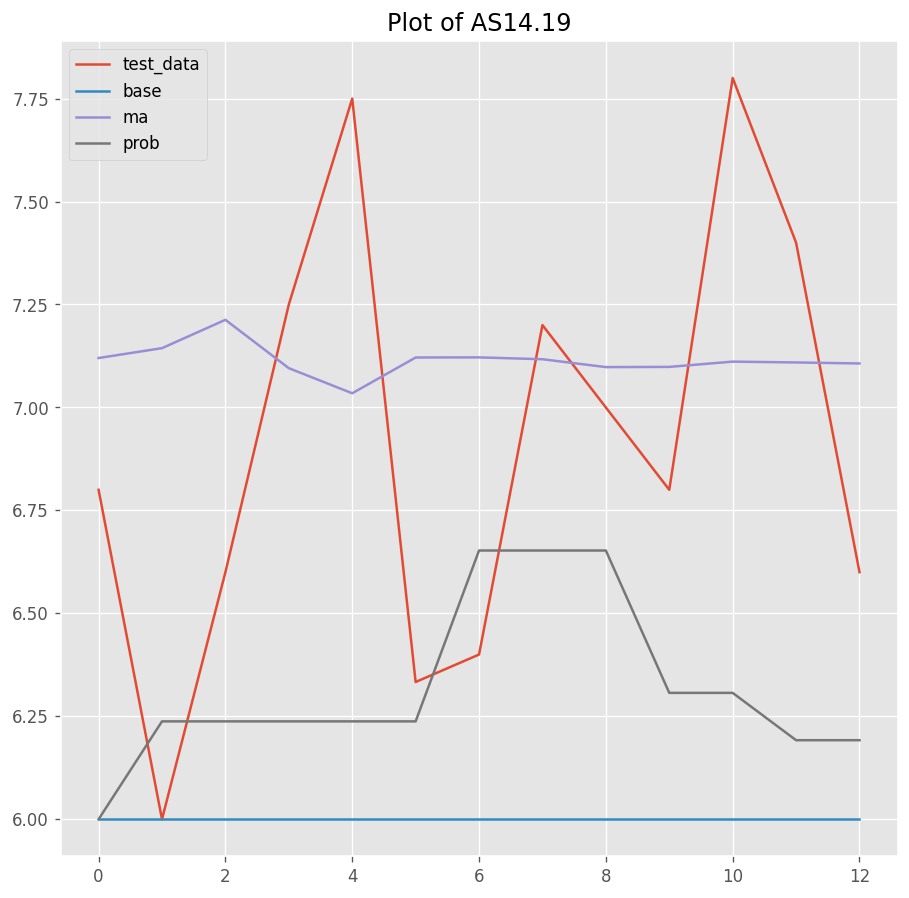

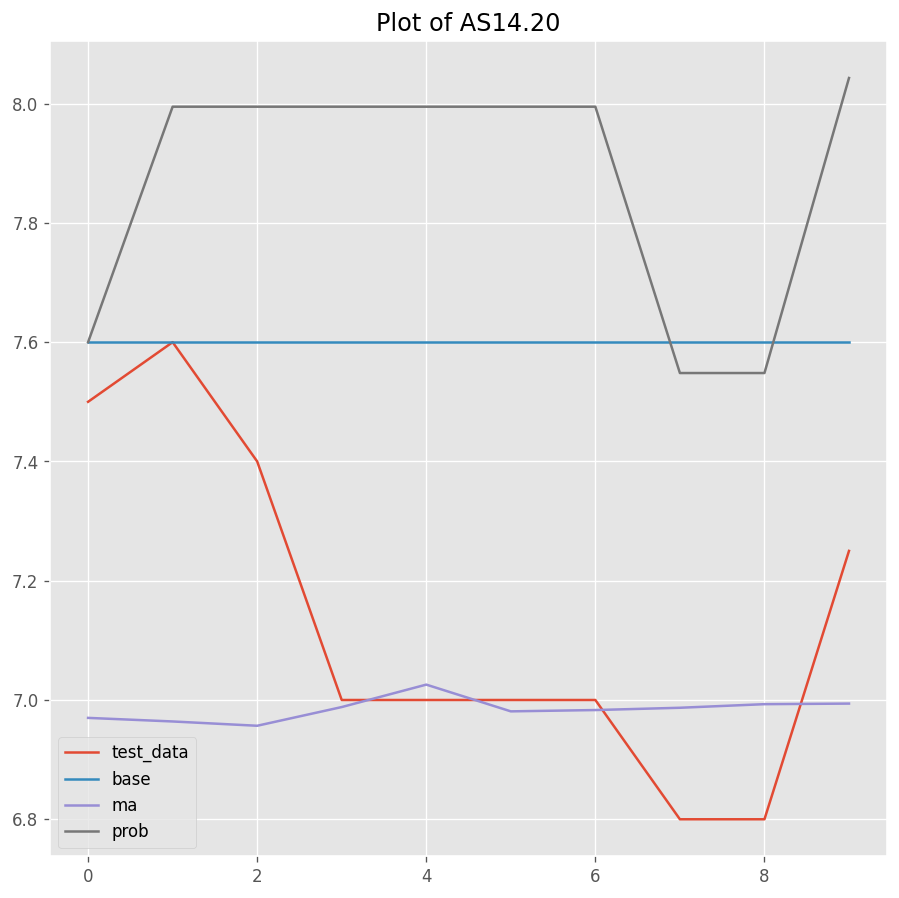

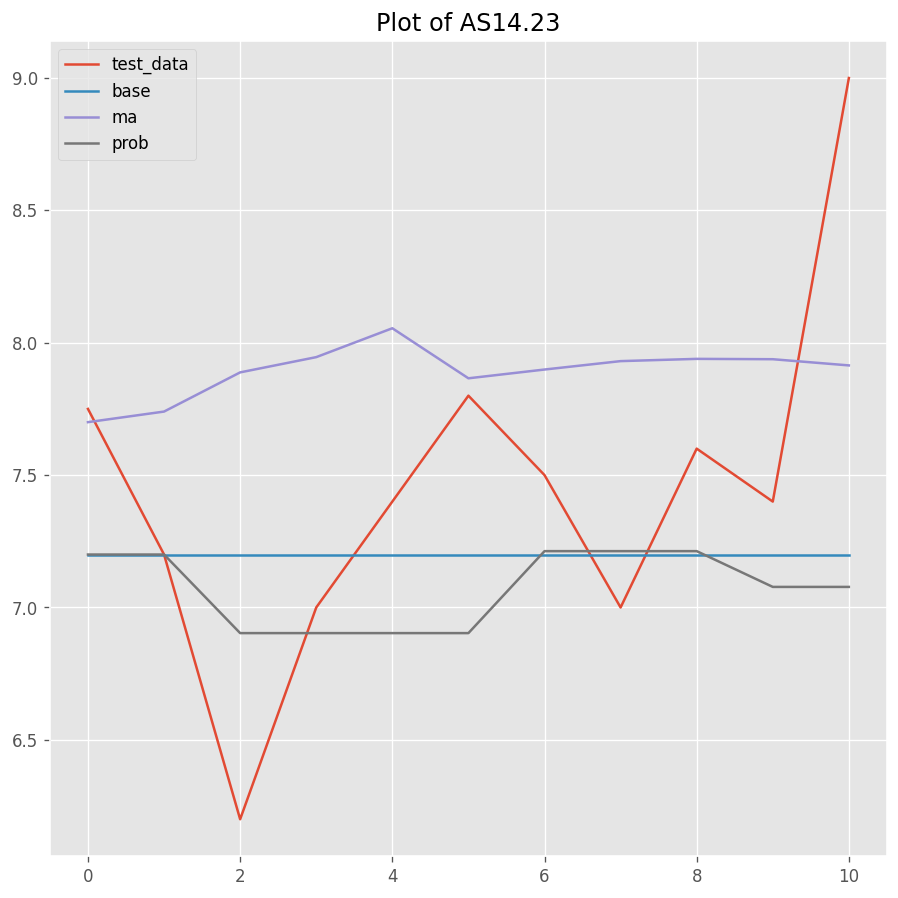

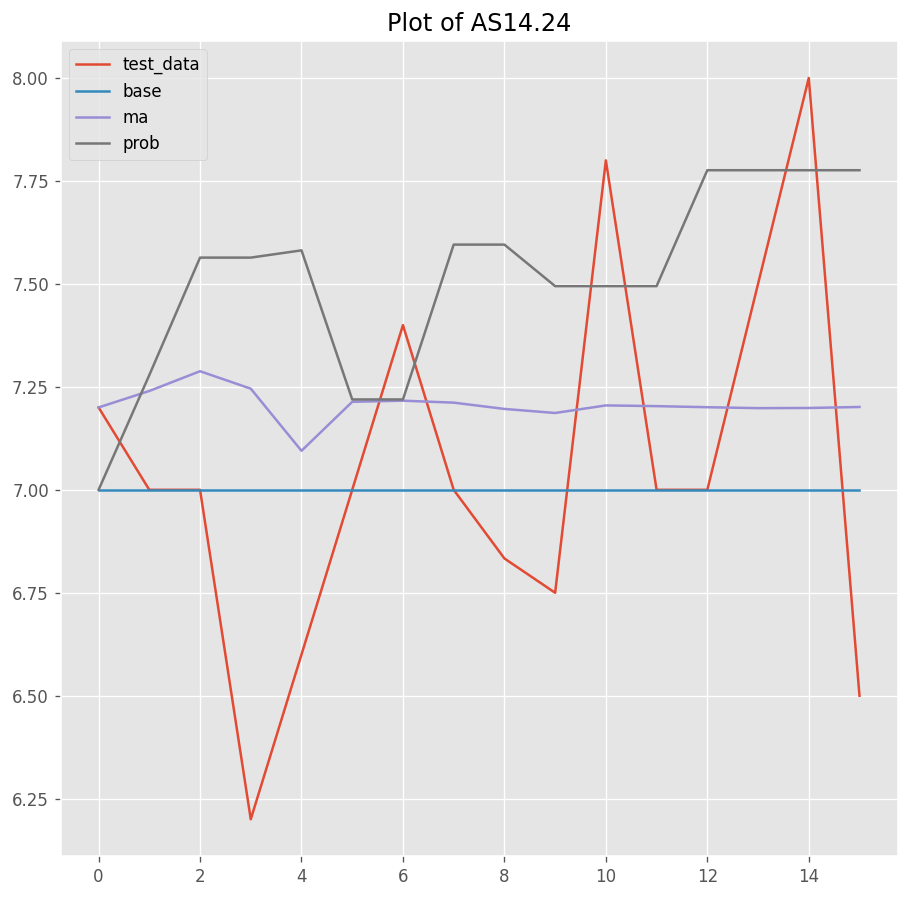

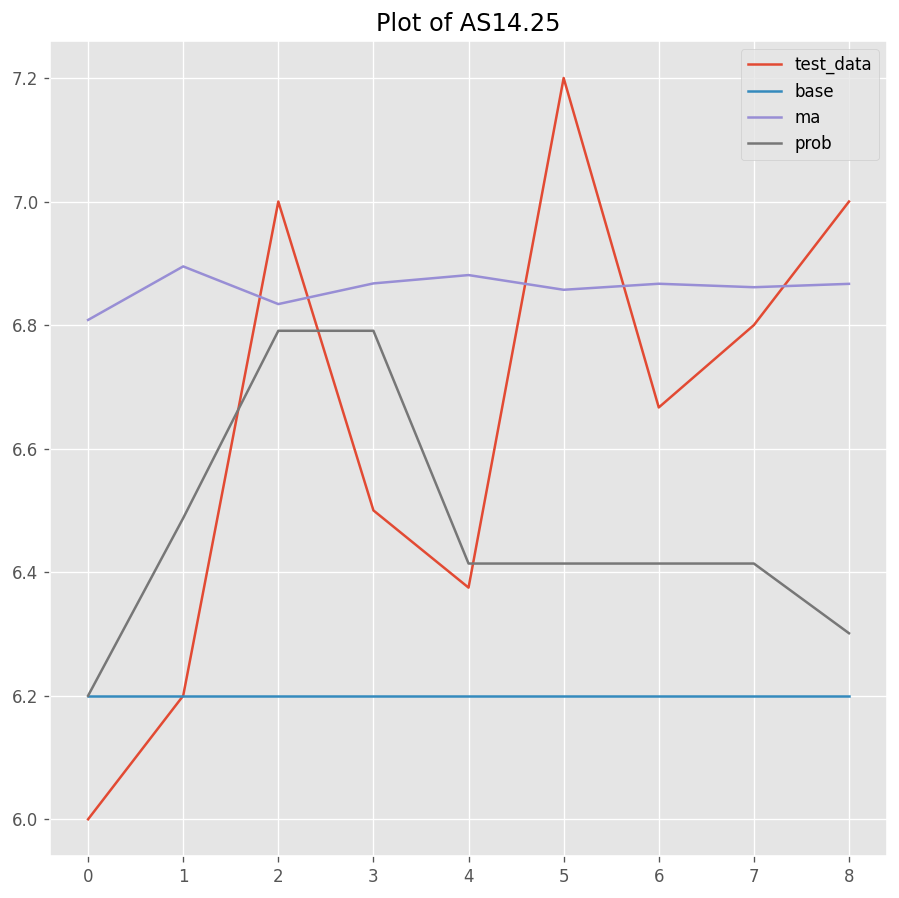

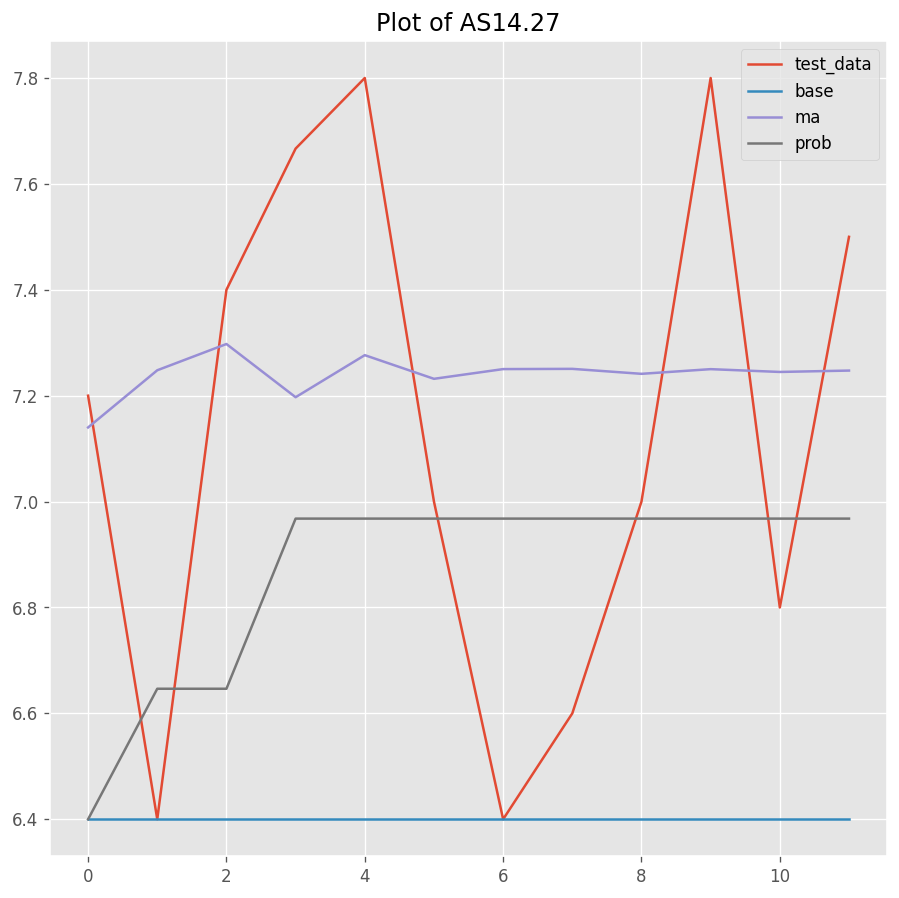

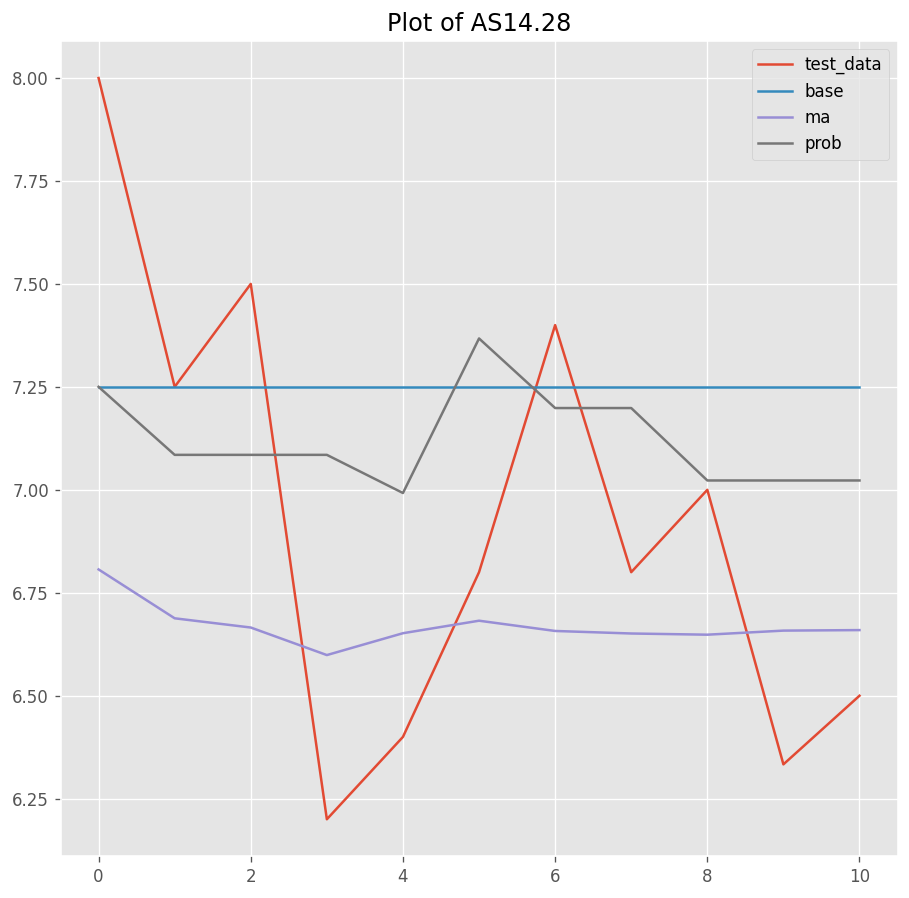

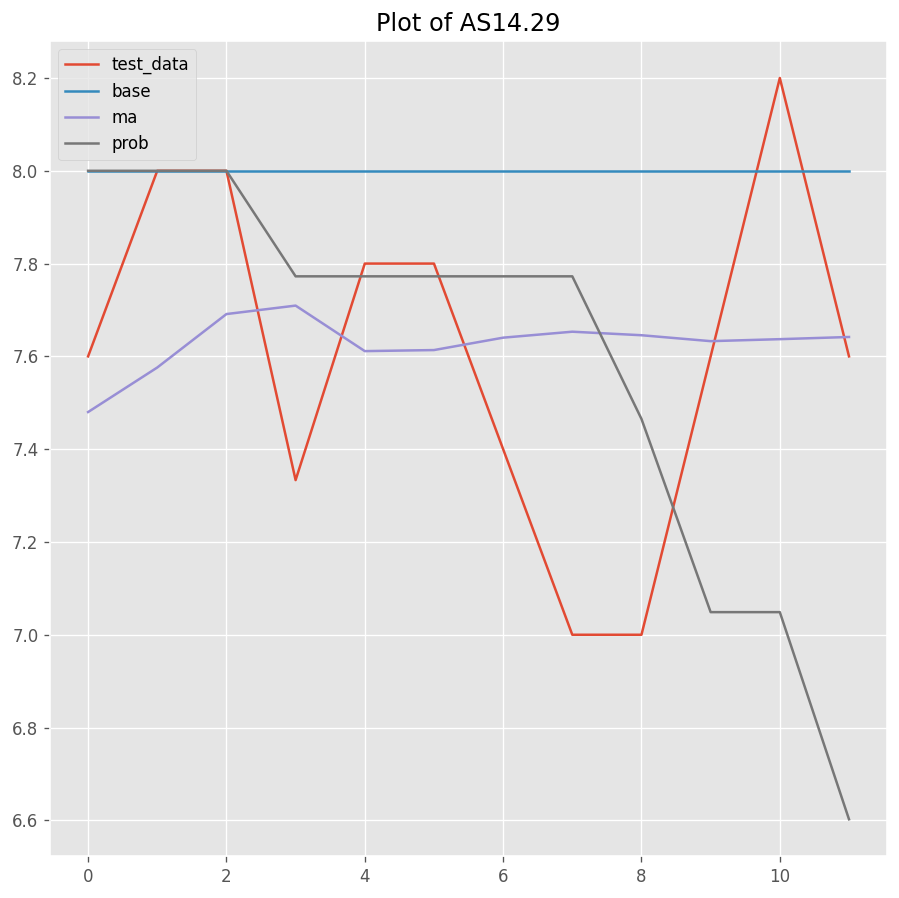

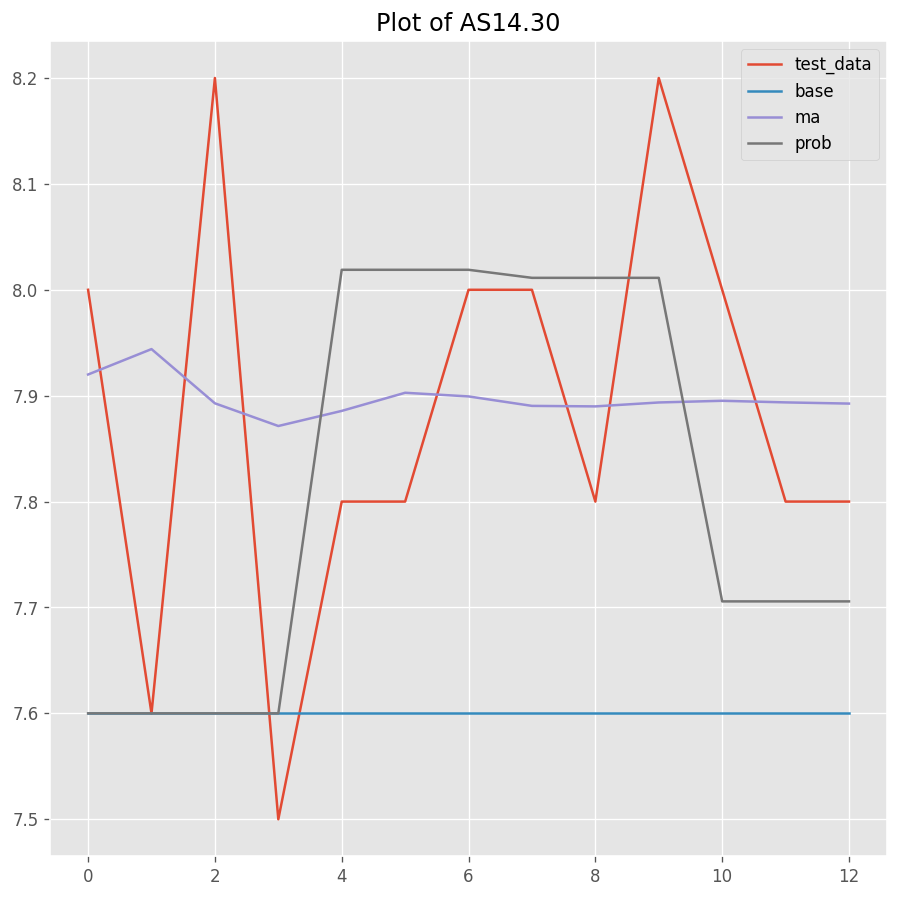

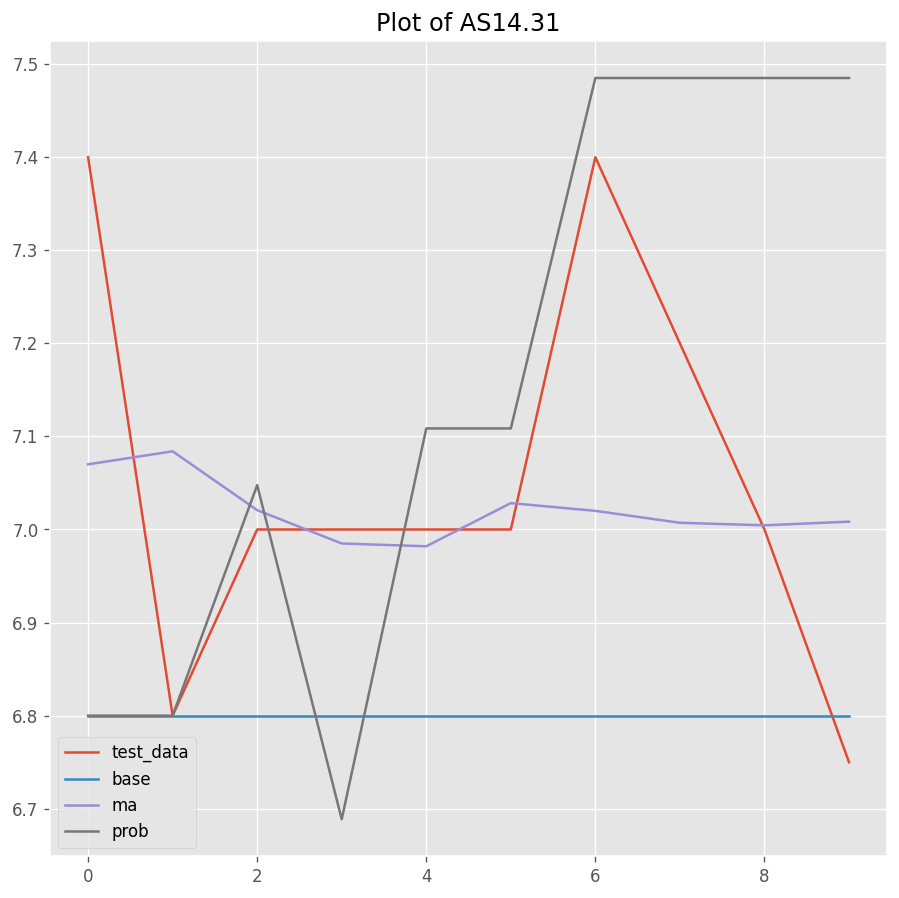

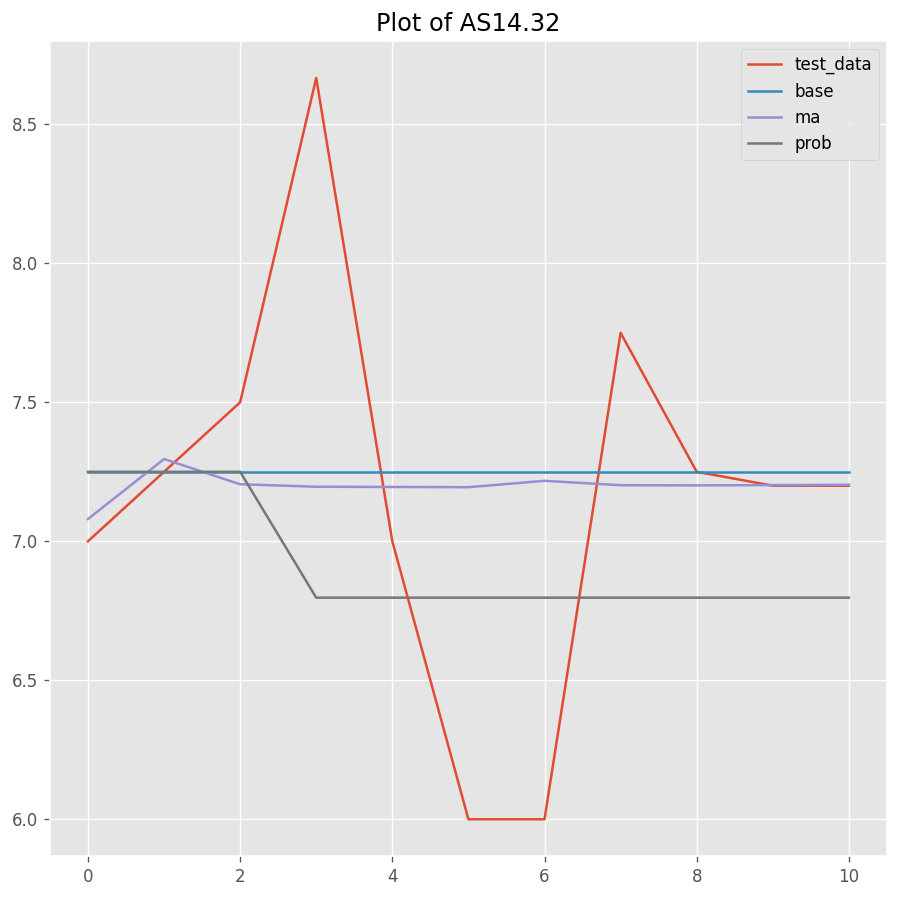

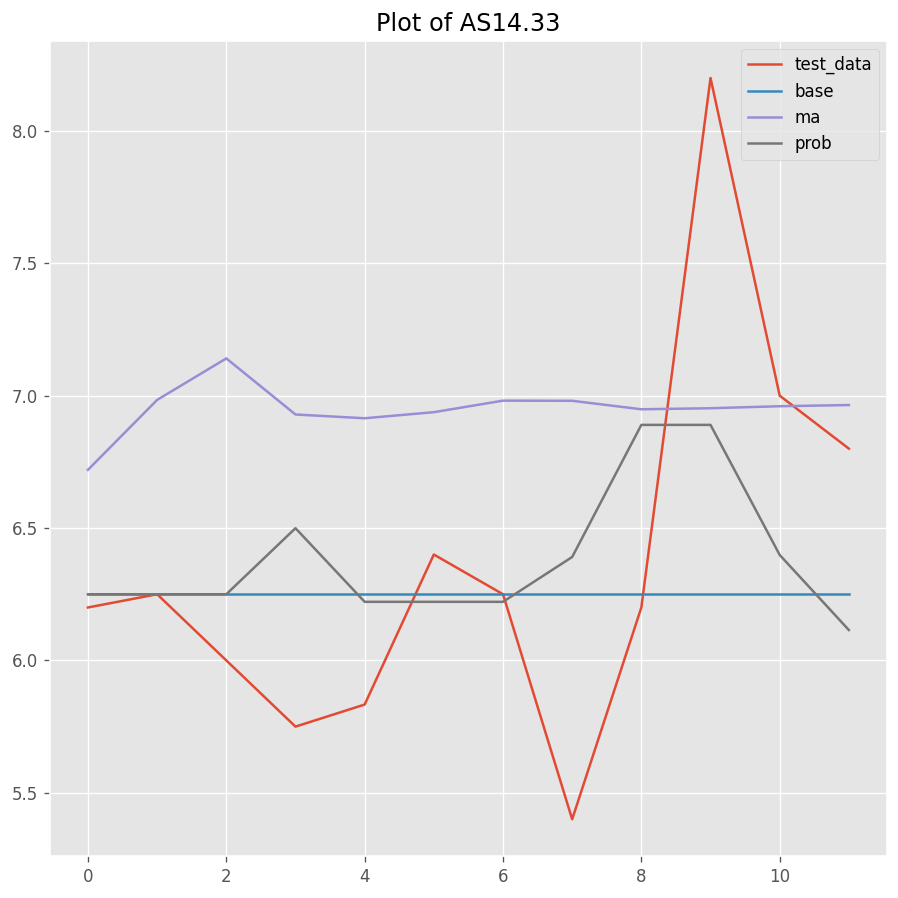

In [35]:
for id in unique_ids:

    plt.plot(test_data_ids[id]["mood"].values, label="test_data")
    plt.plot(base_baseline[id], label="base")
    plt.plot(ma_baseline[id], label="ma")
    plt.plot(prob_baseline[id], label="prob")
    plt.title(f"Plot of {id}")
    plt.legend()

    plt.show()

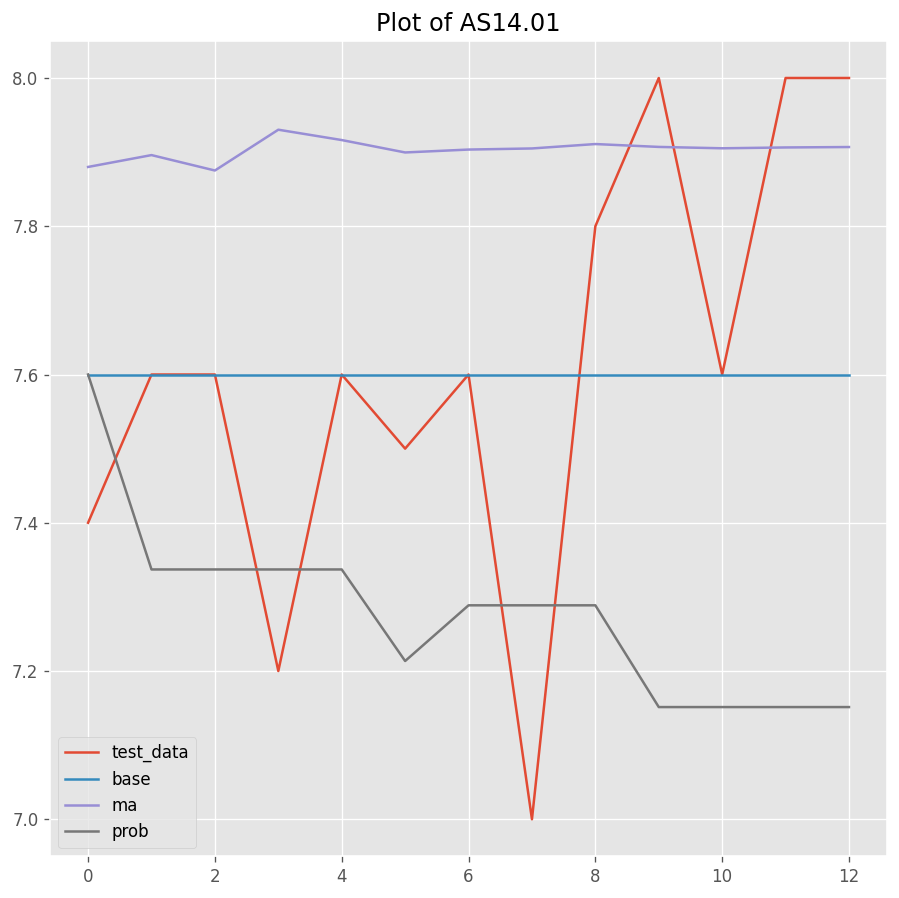

In [36]:
plt.plot(test_data_ids['AS14.01']["mood"].values, label="test_data")
plt.plot(base_baseline['AS14.01'], label="base")
plt.plot(ma_baseline['AS14.01'], label="ma")
plt.plot(prob_baseline['AS14.01'], label="prob")
plt.title(f"Plot of {'AS14.01'}")
plt.legend()

plt.show()

In [37]:
def forecast_accuracy(actual_data, predicted_data, verif_corr=True):
    """
    Returns a dictionary that contains the forecast accuracy
    MAPE: Mean Absolute Percentage Error
    corr: Correlation between the Actual and the Forecast
    MAD: Mean absolute deviation 
    """
    mape = np.mean(np.abs(predicted_data - actual_data)/np.abs(actual_data)) * 100
    mape = round(mape, 2)
    if verif_corr:
        corr = np.corrcoef(predicted_data, actual_data)[0,1]
        corr = round(corr, 2)
    mad = np.mean(predicted_data - actual_data)
    mad = round(mad, 2)
    if verif_corr:
        return mape, mad, corr
    else:
        return mape, mad

In [38]:
#Creat a list that contains all the accuracy estimators for the three baselines
all_baselines_accuracys = list()

for id in unique_ids:
    base_accuracy = forecast_accuracy(test_data_ids[id]["mood"].values, base_baseline[id]) #Accuracy estimators for the base baselline
    ma_accuracy = forecast_accuracy(test_data_ids[id]["mood"].values, ma_baseline[id]) #Accuracy estimators for the ma baselline
    prob_accuracy = forecast_accuracy(test_data_ids[id]["mood"].values, prob_baseline[id]) #Accuracy estimators for the prob baselline
    #Add al the accuracy estimators for each baseline to a list in a specific order. They are combined in a tuple
    all_baselines_accuracys.append((base_accuracy[0], ma_accuracy[0], prob_accuracy[0], base_accuracy[1], ma_accuracy[1], prob_accuracy[1], base_accuracy[2], ma_accuracy[2], prob_accuracy[2]))

/home/udy/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/udy/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [39]:
#Create a Pandas DataFrame from the accuracy etimators
base_baseline_accuracy = pd.DataFrame(all_baselines_accuracys, columns=["MAPE_base", "MAPE_ma", "MAPE_prob", "MAD_base", "MAD_ma", "MAD_prob", "corr_base", "corr_ma", "corr_prob",], index=unique_ids)
base_baseline_accuracy

MAPE_base  MAPE_ma  MAPE_prob  MAD_base  MAD_ma  MAD_prob  corr_base  \
AS14.01       2.75     4.58       5.49     -0.01    0.30     -0.33        0.0   
AS14.02       9.10     8.08      12.55      0.40   -0.18      0.73        NaN   
AS14.03       2.91     3.21      14.41      0.04    0.15      1.05       -0.0   
AS14.05       3.60     5.38       7.19      0.14   -0.34      0.50       -0.0   
AS14.06       7.95     5.13       9.04      0.45   -0.09      0.59        NaN   
AS14.07      15.18    20.14      16.56      0.25    0.62      0.37        NaN   
AS14.08       6.75    10.32       7.76     -0.02    0.53      0.25        NaN   
AS14.09       9.17    10.76       9.48      0.16    0.45     -0.09        NaN   
AS14.12       7.47    10.02      13.66     -0.16   -0.49      0.40        NaN   
AS14.13      14.70     8.18      13.65     -1.04    0.20     -0.96        0.0   
AS14.14       5.48     6.49      12.99     -0.11   -0.32      0.50        NaN   
AS14.15       3.53     5.62       7.45      0.18   -0.14      0.44        NaN   
AS14.16       9.06     6.72      13.13     -0.47    0.24     -0.83       -0.0   
AS14.17       4.10     4.79       4.55      0.03    0.12     -0.20        NaN   
AS14.19      12.77     7.35       9.35     -0.92    0.20     -0.60        NaN   
AS14.20       6.67     3.16      10.44      0.46   -0.15      0.74        0.0   
AS14.23       6.48     9.18       6.88     -0.24    0.45     -0.37        NaN   
AS14.24       4.40     5.65       8.51     -0.05    0.16      0.46        NaN   
AS14.25       7.03     5.69       5.16     -0.44    0.22     -0.17        NaN   
AS14.27       9.81     6.26       6.71     -0.73    0.11     -0.26       -0.0   
AS14.28       7.98     6.43       6.99      0.32   -0.26      0.20        NaN   
AS14.29       5.76     4.19       5.76      0.39    0.02     -0.03        NaN   
AS14.30       3.75     2.14       2.37     -0.28    0.01     -0.07       -0.0   
AS14.31       3.68     2.15       3.93     -0.26   -0.03      0.09        NaN   
AS14.32       6.94     6.68       7.97      0.08    0.03     -0.24        NaN   
AS14.33       6.86    13.15       7.67     -0.11    0.59      0.03        NaN   

         corr_ma  corr_prob  
AS14.01    -0.02      -0.53  
AS14.02     0.48       0.30  
AS14.03    -0.13       0.22  
AS14.05     0.25       0.44  
AS14.06     0.49       0.28  
AS14.07    -0.42      -0.23  
AS14.08     0.05       0.06  
AS14.09     0.47      -0.64  
AS14.12     0.18      -0.50  
AS14.13    -0.13      -0.05  
AS14.14     0.10      -0.73  
AS14.15     0.08      -0.50  
AS14.16     0.41       0.20  
AS14.17     0.26      -0.52  
AS14.19    -0.56       0.01  
AS14.20    -0.61       0.30  
AS14.23    -0.05       0.22  
AS14.24     0.05      -0.03  
AS14.25     0.04       0.23  
AS14.27    -0.00       0.10  
AS14.28     0.75       0.43  
AS14.29    -0.19      -0.02  
AS14.30    -0.05       0.23  
AS14.31     0.11       0.08  
AS14.32     0.03       0.07  
AS14.33    -0.03       0.41

In [40]:
base_baseline_accuracy.describe()

MAPE_base    MAPE_ma  MAPE_prob   MAD_base     MAD_ma   MAD_prob  \
count  26.000000  26.000000  26.000000  26.000000  26.000000  26.000000   
mean    7.072308   6.978846   8.832692  -0.074615   0.092308   0.084615   
std     3.359536   3.794473   3.622882   0.398228   0.293807   0.493269   
min     2.750000   2.140000   2.370000  -1.040000  -0.490000  -0.960000   
25%     4.175000   4.875000   6.752500  -0.255000  -0.127500  -0.230000   
50%     6.805000   6.345000   7.865000  -0.015000   0.115000   0.060000   
75%     8.790000   8.155000  12.022500   0.175000   0.235000   0.455000   
max    15.180000  20.140000  16.560000   0.460000   0.620000   1.050000   

       corr_base    corr_ma  corr_prob  
count        8.0  26.000000  26.000000  
mean         0.0   0.060000  -0.006538  
std          0.0   0.314019   0.353383  
min         -0.0  -0.610000  -0.730000  
25%         -0.0  -0.050000  -0.185000  
50%          0.0   0.045000   0.075000  
75%          0.0   0.232500   0.230000  
max         -0.0   0.750000   0.440000

Imlement a linear regression model

In [41]:
# read the dataset
dataset = pd.read_csv("data/AS14.12.csv")

In [42]:
x = dataset[["screen"]]
y = dataset[["mood"]]

In [43]:
# split dataset to training/testing sets
xtraindata, xtestdata, ytraindata, ytestdata = train_test_split(x, y, test_size=0.33, random_state=42)

In [44]:
# Linear Regression
lm = LinearRegression()
lm.fit(xtraindata, ytraindata)
ypredlm = lm.predict(xtestdata)

In [45]:
# print coefficients
print("Coefficients: \n", lm.coef_)

Coefficients: 
 [[-0.00522023]]


In [46]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(ytestdata, ypredlm))

Mean squared error: 0.22


In [47]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(ytestdata, ypredlm))

Coefficient of determination: -0.20


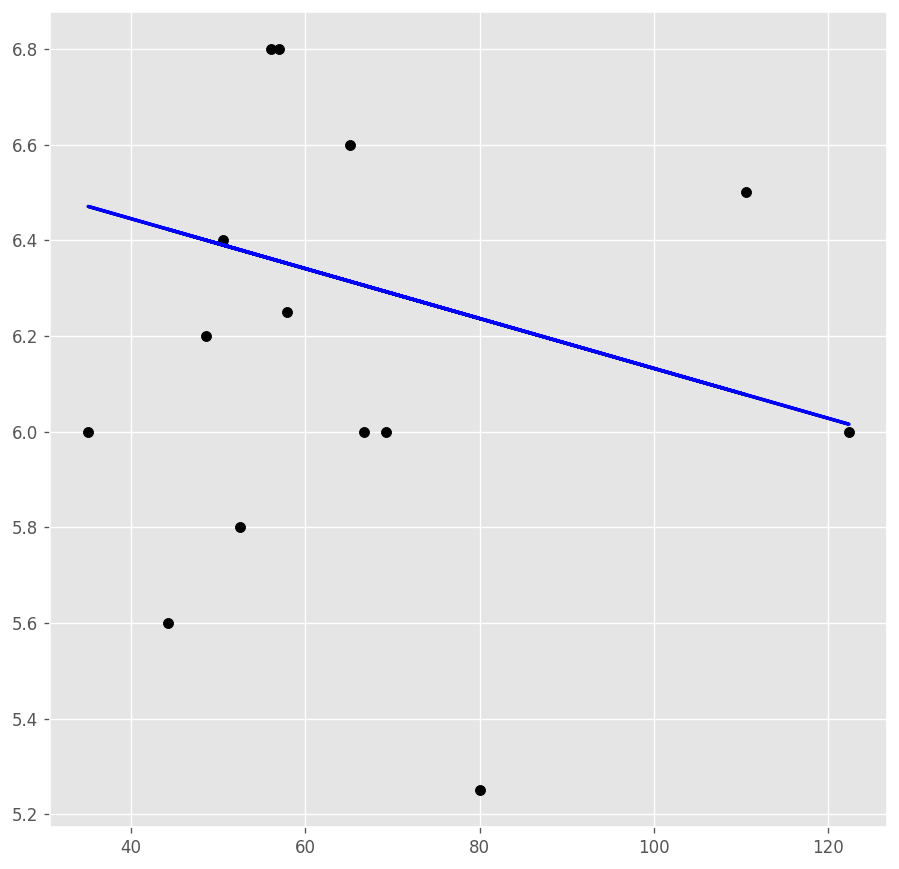

In [48]:
plt.scatter(xtestdata, ytestdata,  color='black')
plt.plot(xtestdata, ypredlm, color='blue', lw=2)

In [49]:
# Ridge Regression
rr = Ridge(alpha=0.01)
rr.fit(xtraindata, ytraindata)
ypredrr = rr.predict(xtestdata)

In [50]:
# print coefficients
print("Coefficients: \n", rr.coef_)

Coefficients: 
 [[-0.00522023]]


In [51]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(ytestdata, ypredrr))

Coefficient of determination: -0.20


In [52]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(ytestdata, ypredrr))

Mean squared error: 0.22


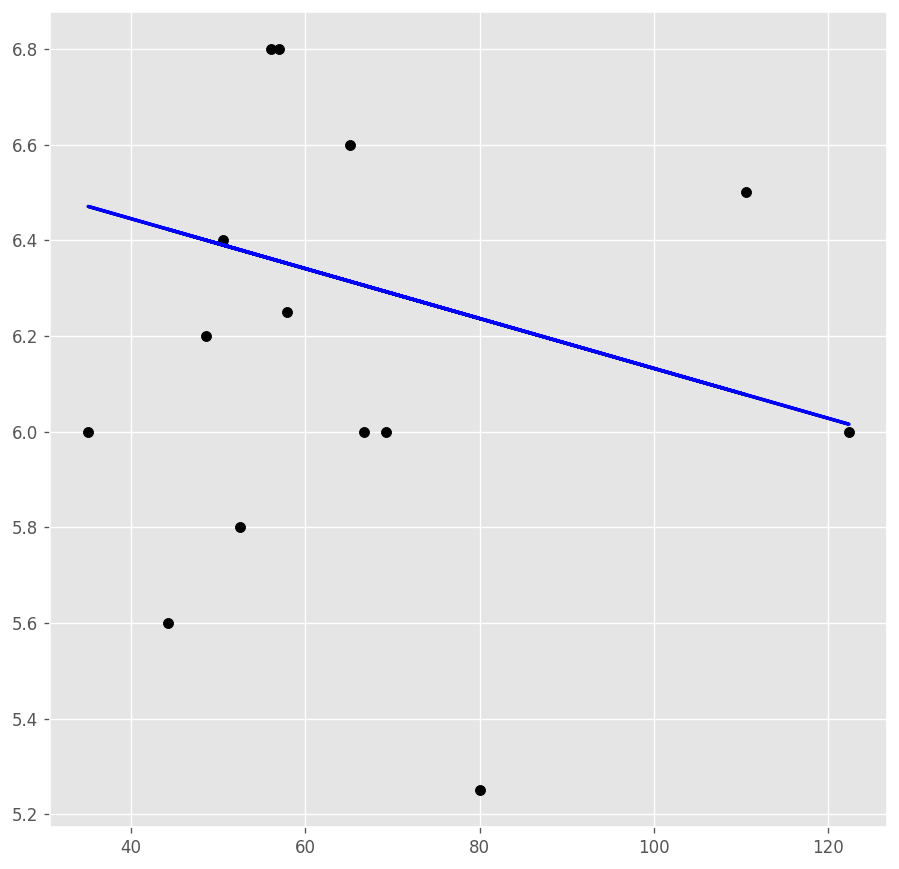

In [53]:
plt.scatter(xtestdata, ytestdata,  color='black')
plt.plot(xtestdata, ypredrr, color='blue', lw=2)

In [54]:
# Lasso Regression
lasso = Lasso(alpha=0.01)
lasso.fit(xtraindata, ytraindata)
ypredlasso = lasso.predict(xtestdata)

In [55]:
# print coefficients
print("Coefficients: \n", lasso.coef_)

Coefficients: 
 [-0.00520645]


In [56]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(ytestdata, ypredlasso))

Mean squared error: 0.22


In [57]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(ytestdata, ypredlasso))

Coefficient of determination: -0.20


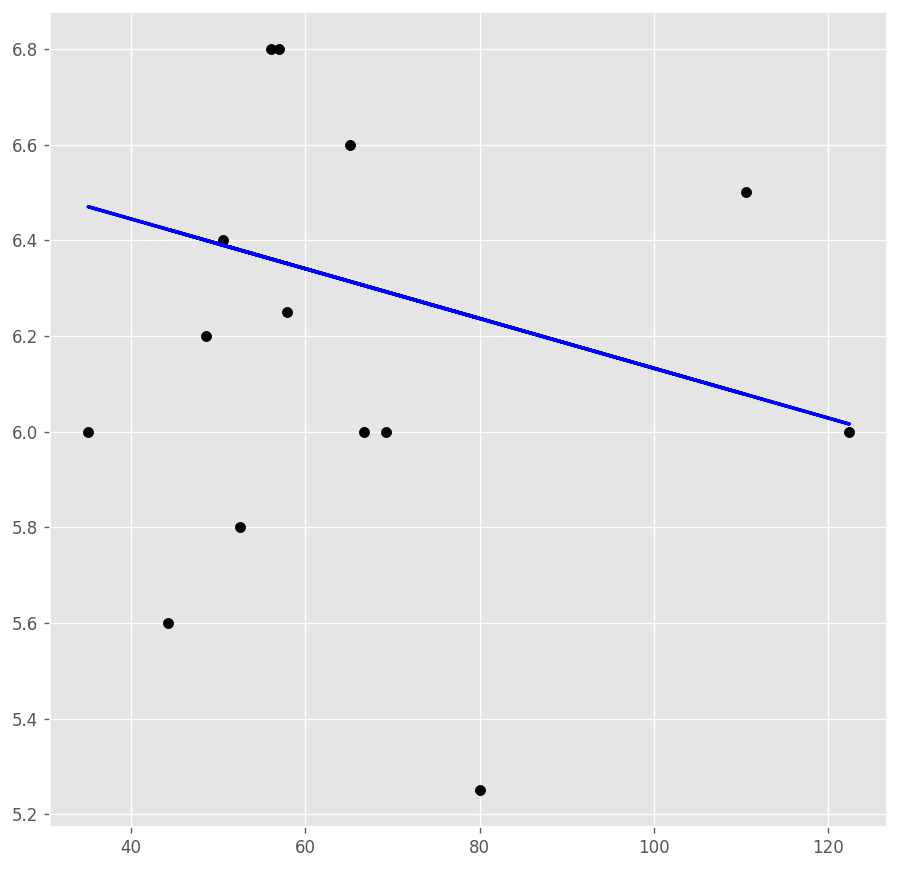

In [58]:
plt.scatter(xtestdata, ytestdata,  color='black')
plt.plot(xtestdata, ypredlasso, color='blue', lw=2)

In [59]:
# Elastic Net Regression
enr = ElasticNet(alpha=0.01)
enr.fit(xtraindata, ytraindata)
ypredenr = lasso.predict(xtestdata)

In [60]:
# print coefficients
print("Coefficients: \n", enr.coef_)

Coefficients: 
 [-0.0052133]


In [61]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(ytestdata, ypredenr))

Mean squared error: 0.22


In [62]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(ytestdata, ypredenr))

Coefficient of determination: -0.20


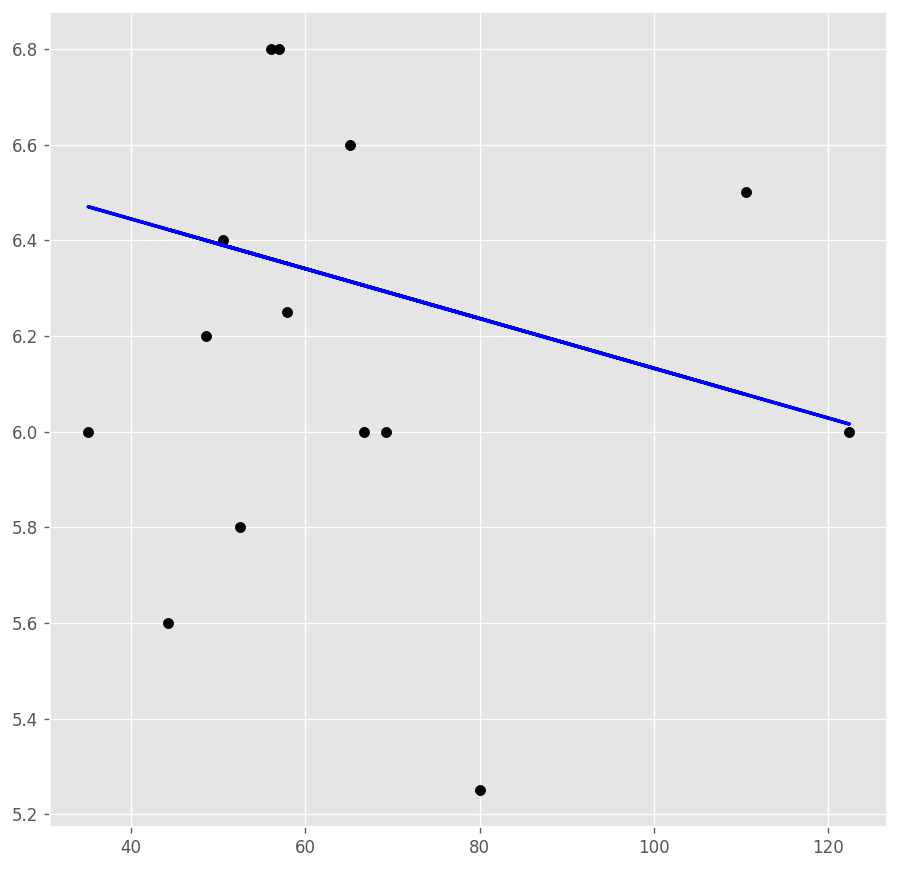

In [63]:
plt.scatter(xtestdata, ytestdata,  color='black')
plt.plot(xtestdata, ypredenr, color='blue', lw=2)

Implement a XGBoost

In [64]:
# read the dataset
dataset = pd.read_csv("data/AS14.12.csv")

In [65]:
x = dataset[["activity", "appCat.builtin", "call", "circumplex.arousal","circumplex.valence","screen","sms"]]
y = dataset[["mood"]]

In [66]:
model = XGBClassifier()
model.fit(x,y)

/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/udy/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:15:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

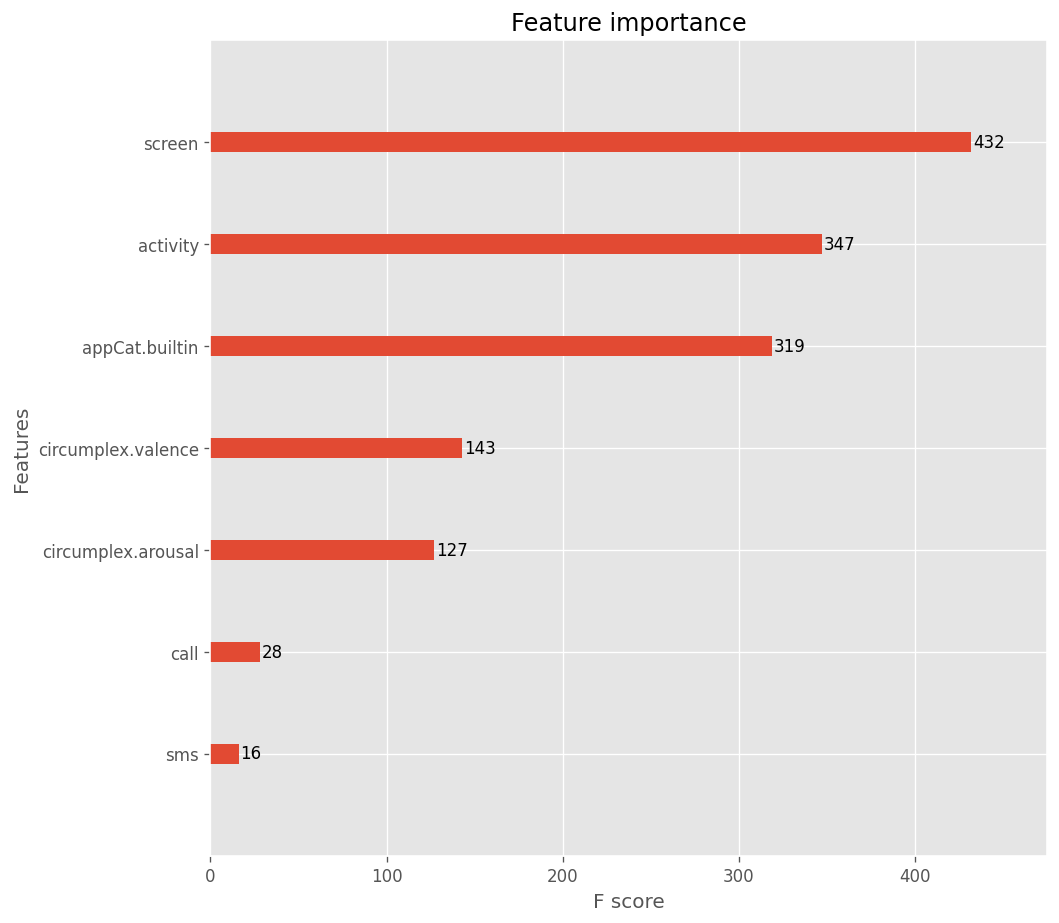

In [67]:
plot_importance(model)
plt.show()

In [68]:
# split dataset to training/testing sets
xtraindata, xtestdata, ytraindata, ytestdata = train_test_split(x, y, test_size=0.33, random_state=42)

In [69]:
# fit model on all training data
xgboost = XGBClassifier()
xgboost.fit(xtraindata,ytraindata)

[20:15:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

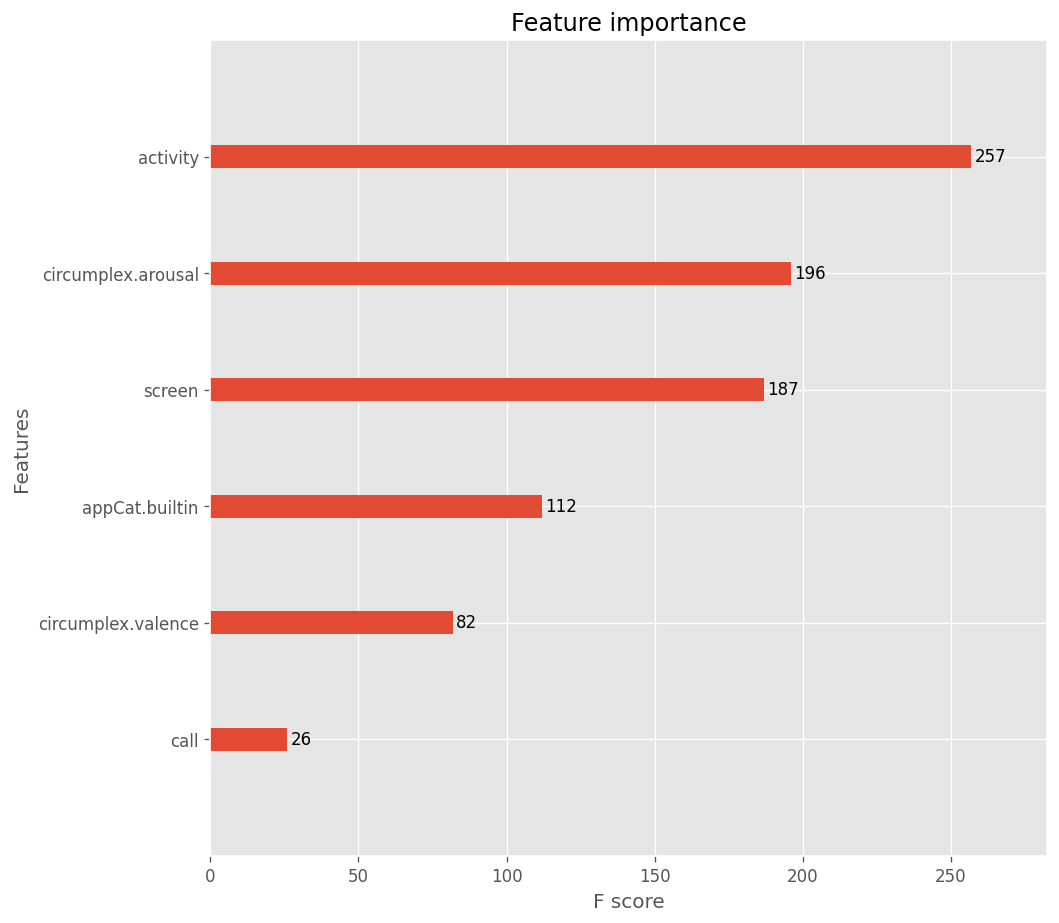

In [70]:
plot_importance(xgboost)
plt.show()

In [71]:
# make predictions for test data and evaluate
ypred = xgboost.predict(xtestdata)
predictions = [round(value) for value in ypred]
scores = [value for value in ytestdata.mood]
accuracy1 = mean_squared_error(scores, predictions)
accuracy2 = r2_score(scores, predictions)
print("mean_squared_error-Accuracy: %.2f%%" % (accuracy1 * 100.0))
print("r2_score-Accuracy: %.2f%%" % (accuracy2 * 100.0))

mean_squared_error-Accuracy: 40.11%
r2_score-Accuracy: -118.54%


/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [72]:
# Fit model using each importance as a threshold
thresholds = np.sort(xgboost.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgboost, threshold=thresh, prefit=True)
    selectxtrain = selection.transform(xtraindata)
    # train model
    selectionmodel = XGBClassifier()
    selectionmodel.fit(selectxtrain, ytraindata)
    # eval model
    selectxtest = selection.transform(xtestdata)
    ypred = selectionmodel.predict(selectxtest)
    predictions = [round(value) for value in ypred]
    accuracy1 = mean_squared_error(scores, predictions)
    accuracy2 = r2_score(scores, predictions)
    print("Thresh=%.3f, n=%d, mean_squared_error-Accuracy: %.2f%%" % (thresh, selectxtrain.shape[1], accuracy1*100.0))
    print("Thresh=%.3f, n=%d, r2_score-Accuracy: %.2f%%" % (thresh, selectxtrain.shape[1], accuracy2*100.0))

/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/udy/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:15:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/udy/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Thresh=0.000, n=7, mean_squared_error-Accuracy: 40.11%
Thresh=0.000, n=7, r2_score-Accuracy: -118.54%
[20:15:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/udy/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Thresh=0.088, n=6, mean_squared_error-Accuracy: 40.11%
Thresh=0.088, n=6, r2_score-Accuracy: -118.54%
[20:15:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/udy/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Thresh=0.103, n=5, mean_squared_error-Accuracy: 27.96%
Thresh=0.103, n=5, r2_score-Accuracy: -52.38%
[20:15:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/udy/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Thresh=0.138, n=4, mean_squared_error-Accuracy: 27.96%
Thresh=0.138, n=4, r2_score-Accuracy: -52.38%
[20:15:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/udy/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Thresh=0.149, n=3, mean_squared_error-Accuracy: 25.11%
Thresh=0.149, n=3, r2_score-Accuracy: -36.81%
[20:15:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/udy/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/udy/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Thresh=0.219, n=2, mean_squared_error-Accuracy: 20.82%
Thresh=0.219, n=2, r2_score-Accuracy: -13.46%
[20:15:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.303, n=1, mean_squared_error-Accuracy: 20.82%
Thresh=0.303, n=1, r2_score-Accuracy: -13.46%


Implement the ARIMA model

In [73]:
#Values for grid search
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2]
q_values = [0]

In [74]:
#Performing grid search to find the bst hyperparameters for the ARIMA model
best_hyperparameters = [0, 0, 0, 100]

for p in p_values:
    for d in d_values:
        for q in q_values:
            id_mape = list()
            for id in unique_ids:
                #Create a model
                model = ARIMA(train_data_ids[id]["mood"].values, order=(p, d, q))  
                fitted = model.fit(disp=-1)  
                # Forecast
                fc, se, conf = fitted.forecast(len(test_data_ids[id]["mood"].values), alpha=0.05)  # 95% conf
                #Compute the accuracy of that model and specific id
                pacient_accuracy = forecast_accuracy(test_data_ids[id]["mood"].values, fc)
                id_mape.append(pacient_accuracy[0])
            #Verify the current model accuracy with the best one
            if np.mean(id_mape) < best_hyperparameters[3]:
                best_hyperparameters[0] = p
                best_hyperparameters[1] = d
                best_hyperparameters[2] = q
                best_hyperparameters[3] = np.mean(id_mape)

/home/udy/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/udy/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/udy/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/udy/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/udy/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed 

In [75]:
best_hyperparameters

[2, 0, 0, 7.134615384615383]

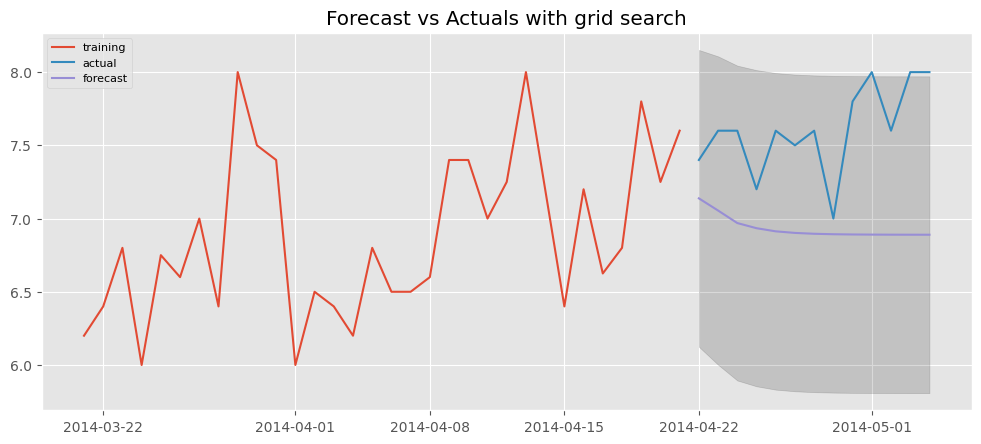

In [94]:
#Plot the estimation of the test data using the best hyperparameters for the first id
model = ARIMA(train_data_ids["AS14.01"]["mood"].values, order=(2, 0, 0))  
fitted = model.fit(disp=-1)  

# Forecast
best_fc, se, conf = fitted.forecast(len(test_data_ids["AS14.01"]["mood"].values), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(best_fc, index=test_data_ids["AS14.01"].index)
lower_series = pd.Series(conf[:, 0], index=test_data_ids["AS14.01"].index)
upper_series = pd.Series(conf[:, 1], index=test_data_ids["AS14.01"].index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data_ids["AS14.01"]["mood"], label='training')
plt.plot(test_data_ids["AS14.01"]["mood"], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals with grid search')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [77]:
#Accuracy estimators obtained using the best hyperparamters obtained after the grid search
first_id_best_hyp = forecast_accuracy(test_data_ids["AS14.01"]["mood"].values, best_fc)
print("MAPE:",first_id_best_hyp[0])
print("MAD:", first_id_best_hyp[1])
print("corr:", first_id_best_hyp[2])

MAPE: 8.7
MAD: -0.67
corr: -0.27


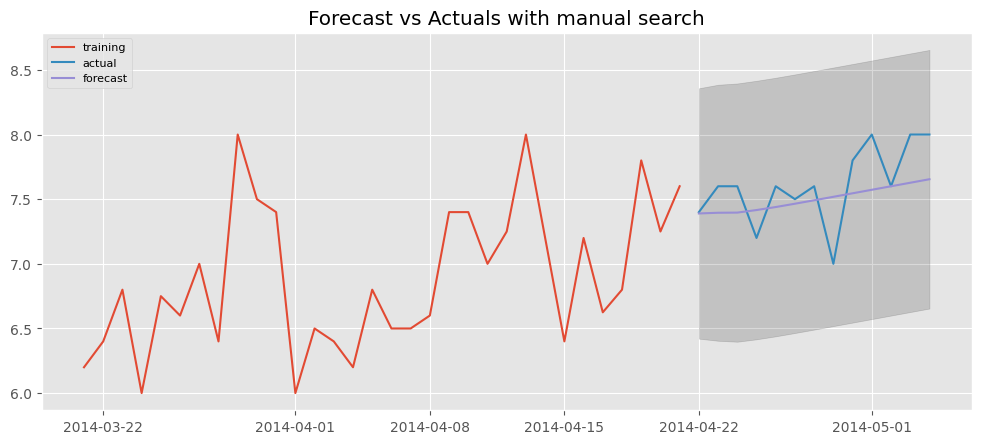

In [95]:
#Plot the estimation of the test data using the manual tuned hyperparameters for the first id
model = ARIMA(train_data_ids["AS14.01"]["mood"].values, order=(2, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
man_fc, se, conf = fitted.forecast(len(test_data_ids["AS14.01"]["mood"].values), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(man_fc, index=test_data_ids["AS14.01"].index)
lower_series = pd.Series(conf[:, 0], index=test_data_ids["AS14.01"].index)
upper_series = pd.Series(conf[:, 1], index=test_data_ids["AS14.01"].index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data_ids["AS14.01"]["mood"], label='training')
plt.plot(test_data_ids["AS14.01"]["mood"], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals with manual search')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [79]:
#Accuracy estimators obtained after using manual tuning of the paramters
first_id_man_param = forecast_accuracy(test_data_ids["AS14.01"]["mood"].values, man_fc)
print("MAPE:", first_id_man_param[0])
print("MAD:", first_id_man_param[1])
print("corr:", first_id_man_param[2])

MAPE: 2.89
MAD: -0.11
corr: 0.59


In [80]:
best_hyp_acc = list()
for id in unique_ids:
    model = ARIMA(train_data_ids[id]["mood"].values, order=(2, 0, 0))  
    fitted = model.fit(disp=-1)  
    # Forecast
    fc, se, conf = fitted.forecast(len(test_data_ids[id]["mood"].values), alpha=0.05)  # 95% conf

    best_hyp_acc.append(forecast_accuracy(test_data_ids[id]["mood"].values, fc))

ARIMA_acc = pd.DataFrame(best_hyp_acc, columns=["MAPE", "MAD", "corr"], index=unique_ids)
ARIMA_acc

MAPE   MAD  corr
AS14.01   8.70 -0.67 -0.27
AS14.02   9.13 -0.05 -0.19
AS14.03   5.03  0.36  0.30
AS14.05   4.68 -0.29  0.41
AS14.06   5.81  0.16 -0.49
AS14.07  16.54  0.25 -0.12
AS14.08   9.32  0.44 -0.04
AS14.09   7.88 -0.14  0.47
AS14.12   8.72  0.28 -0.29
AS14.13  15.52 -1.14  0.62
AS14.14   5.76 -0.25  0.11
AS14.15   3.47  0.16  0.35
AS14.16   9.20 -0.46 -0.21
AS14.17   3.77 -0.03 -0.08
AS14.19   6.48 -0.20  0.20
AS14.20   3.35 -0.19  0.70
AS14.23   6.92 -0.33 -0.12
AS14.24   4.44 -0.05 -0.07
AS14.25   5.90  0.30  0.64
AS14.27   7.67  0.40 -0.04
AS14.28   7.67  0.28  0.57
AS14.29   3.86  0.01  0.26
AS14.30   2.56 -0.15 -0.12
AS14.31   2.35 -0.10  0.20
AS14.32  10.92  0.56  0.03
AS14.33   9.85  0.28  0.09

In [81]:
ARIMA_acc.describe()

MAPE        MAD       corr
count  26.000000  26.000000  26.000000
mean    7.134615  -0.021923   0.111923
std     3.558477   0.378048   0.321770
min     2.350000  -1.140000  -0.490000
25%     4.500000  -0.197500  -0.120000
50%     6.700000  -0.040000   0.060000
75%     9.027500   0.280000   0.337500
max    16.540000   0.560000   0.700000

Implement an LSTM model

In [82]:
train_data_LSTM = dict()
test_data_LSTM = dict()

for id in unique_ids:
    train_data_LSTM[id], test_data_LSTM[id] = separate_data(preprocesed_data[id]["mood"].values)

In [83]:
def sliding_window(data, seq_len=4):
    
    si = list()
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len]
        si.append((x, y))

    return si

In [84]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = dict()
input_seq = list()

for id in unique_ids:
    train_data_normalized[id] = scaler.fit_transform(train_data_LSTM[id].reshape(-1, 1))
    train_data_normalized[id] = torch.FloatTensor(train_data_normalized[id]).view(-1)
    for sequence in sliding_window(train_data_normalized[id]):
        input_seq.append(sequence)

In [85]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [86]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [87]:
epochs = 50

for i in range(epochs):    
    for seq, labels in input_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()


    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/home/udy/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/udy/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


epoch:   0 loss: 0.0794455111
epoch:   1 loss: 0.0831740573
epoch:   2 loss: 0.0846911669
epoch:   3 loss: 0.0838401690
epoch:   4 loss: 0.0839923620
epoch:   5 loss: 0.0819868073
epoch:   6 loss: 0.0820454210
epoch:   7 loss: 0.0807680190
epoch:   8 loss: 0.0832245722
epoch:   9 loss: 0.0867628977
epoch:  10 loss: 0.0911448672
epoch:  11 loss: 0.0958097950
epoch:  12 loss: 0.1018573716
epoch:  13 loss: 0.1123479009
epoch:  14 loss: 0.1287398487
epoch:  15 loss: 0.1238376424
epoch:  16 loss: 0.1225306839
epoch:  17 loss: 0.1184598655
epoch:  18 loss: 0.1192369983
epoch:  19 loss: 0.1184923649
epoch:  20 loss: 0.1162486821
epoch:  21 loss: 0.1115001217
epoch:  22 loss: 0.1038858891
epoch:  23 loss: 0.0952483863
epoch:  24 loss: 0.0872786269
epoch:  25 loss: 0.0817372724
epoch:  26 loss: 0.0796609670
epoch:  27 loss: 0.0806034729
epoch:  28 loss: 0.0821589828
epoch:  29 loss: 0.0816216916
epoch:  30 loss: 0.0820301101
epoch:  31 loss: 0.0891889334
epoch:  32 loss: 0.0934624597
epoch:  33

In [88]:
fut_pred = 12

test_inputs = train_data_normalized["AS14.01"][-len(test_data_LSTM["AS14.01"]):].tolist()
print(test_inputs)

[0.4000000059604645, 0.4000000059604645, 0.0, 0.25, 1.0, 0.20000000298023224, -0.6000000238418579, 0.20000000298023224, -0.375, -0.20000000298023224, 0.800000011920929, 0.25, 0.6000000238418579]


In [89]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_data_LSTM["AS14.01"][-len(test_data_LSTM["AS14.01"]):])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
        
actual_predictions = scaler.inverse_transform(np.array(test_data_LSTM["AS14.01"][-len(test_data_LSTM["AS14.01"]):] ).reshape(-1, 1))

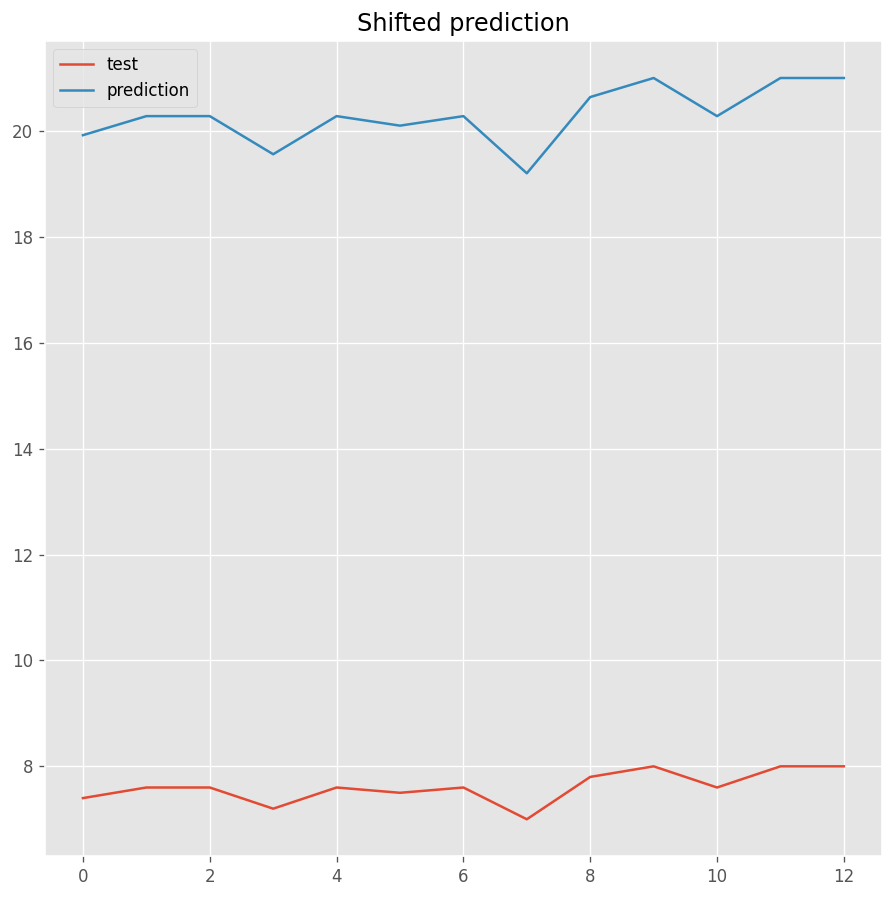

In [98]:
plt.plot(test_data_LSTM["AS14.01"], label="test")
plt.plot(actual_predictions, label="prediction")
plt.title("Shifted prediction")
plt.legend()
plt.show()

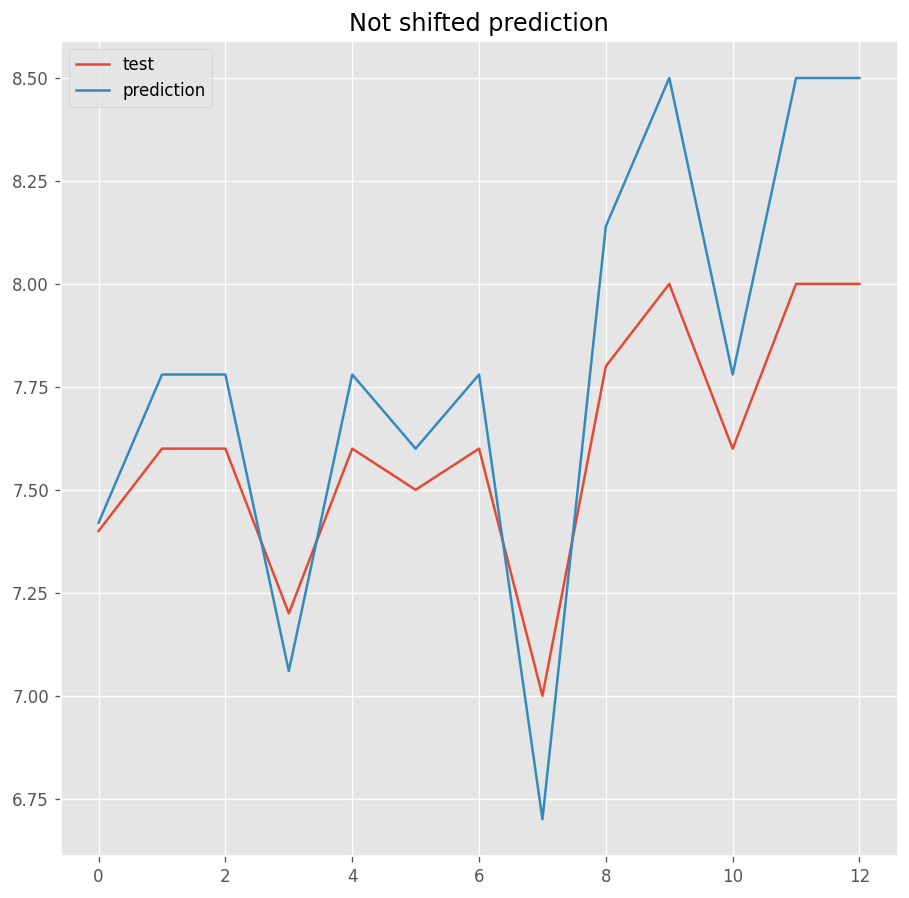

In [99]:
plt.plot(test_data_LSTM["AS14.01"], label="test")
plt.plot(actual_predictions - 12.5, label="prediction")
plt.title("Not shifted prediction")
plt.legend()
plt.show()

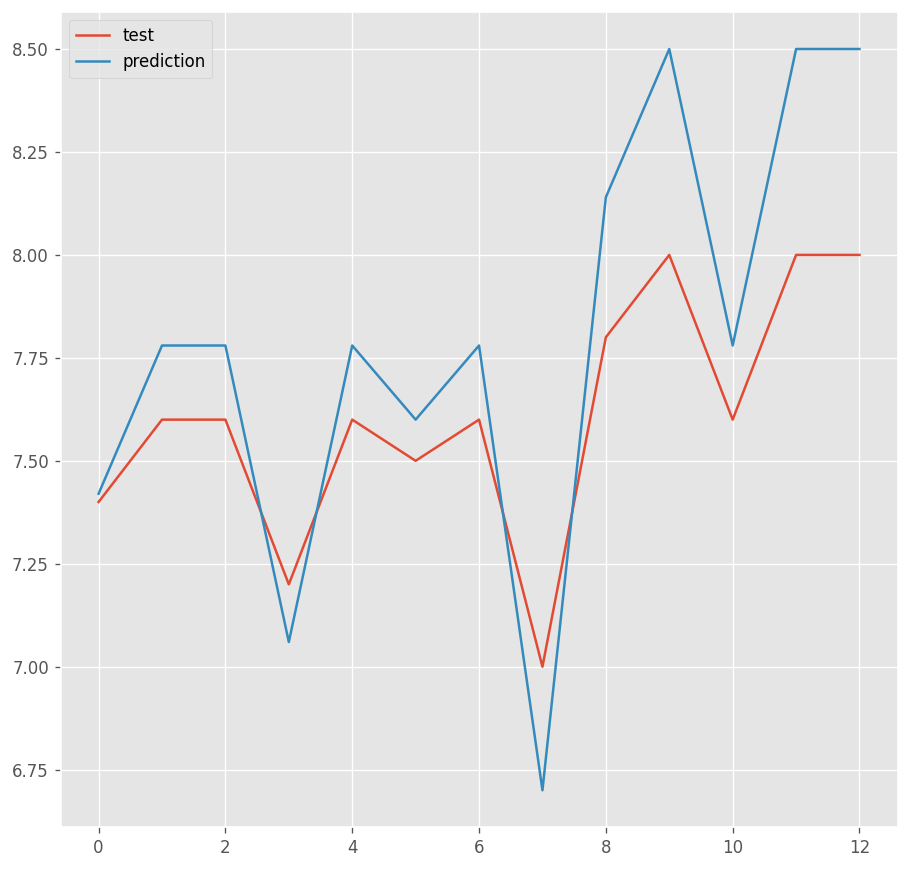

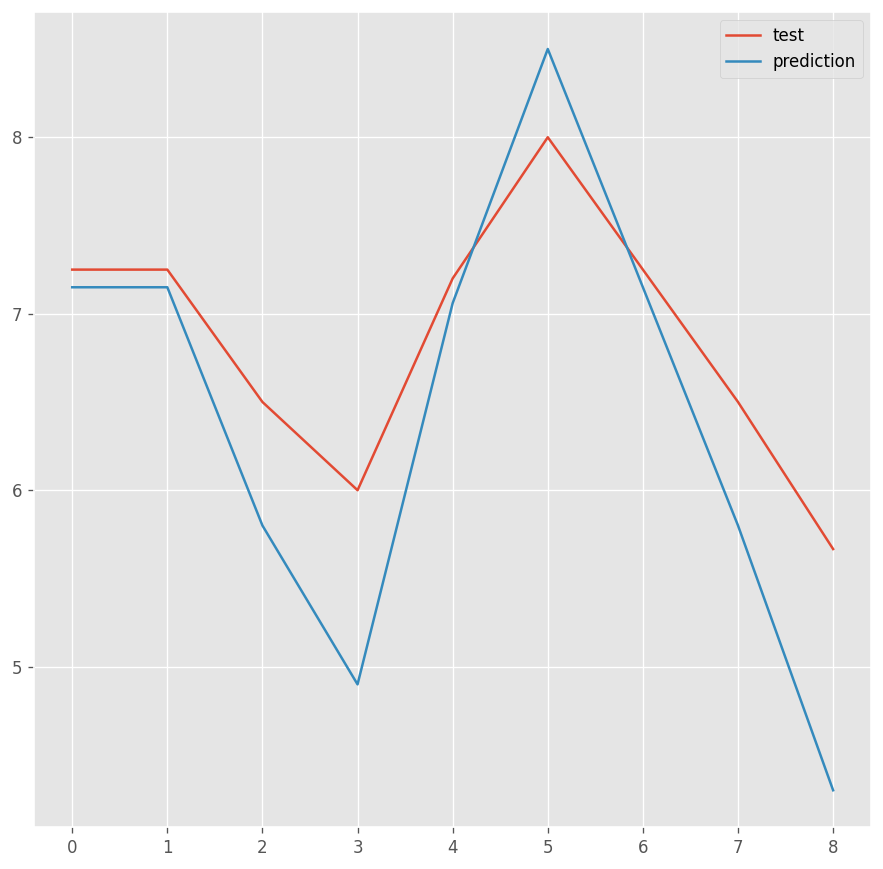

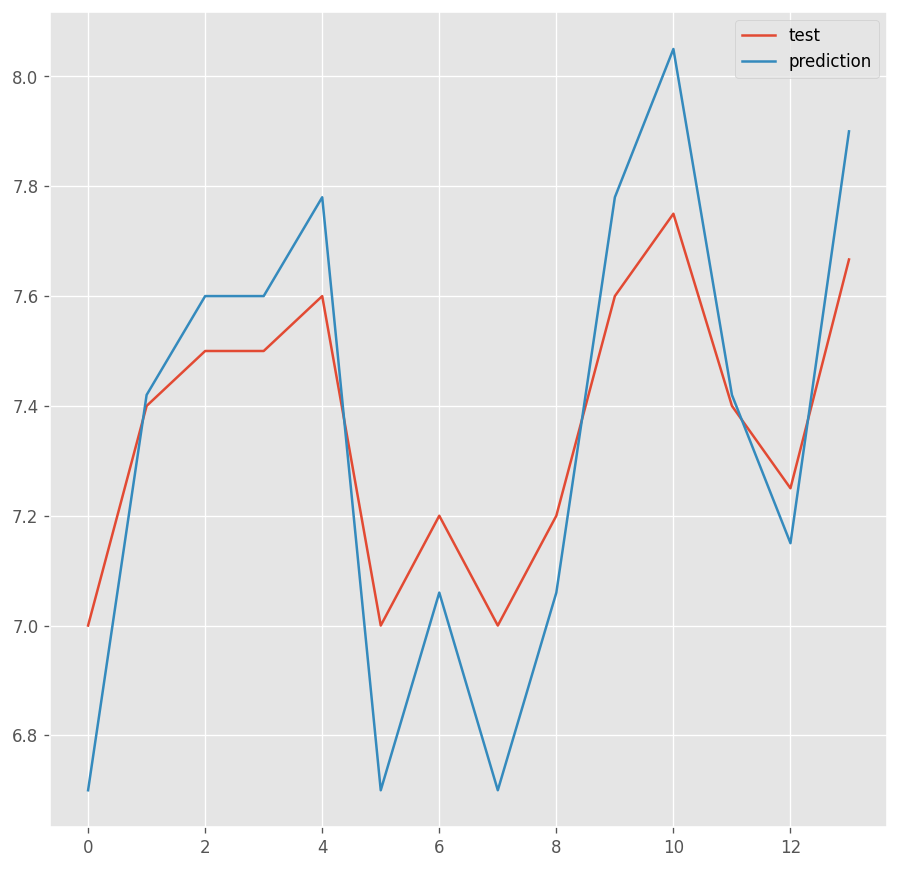

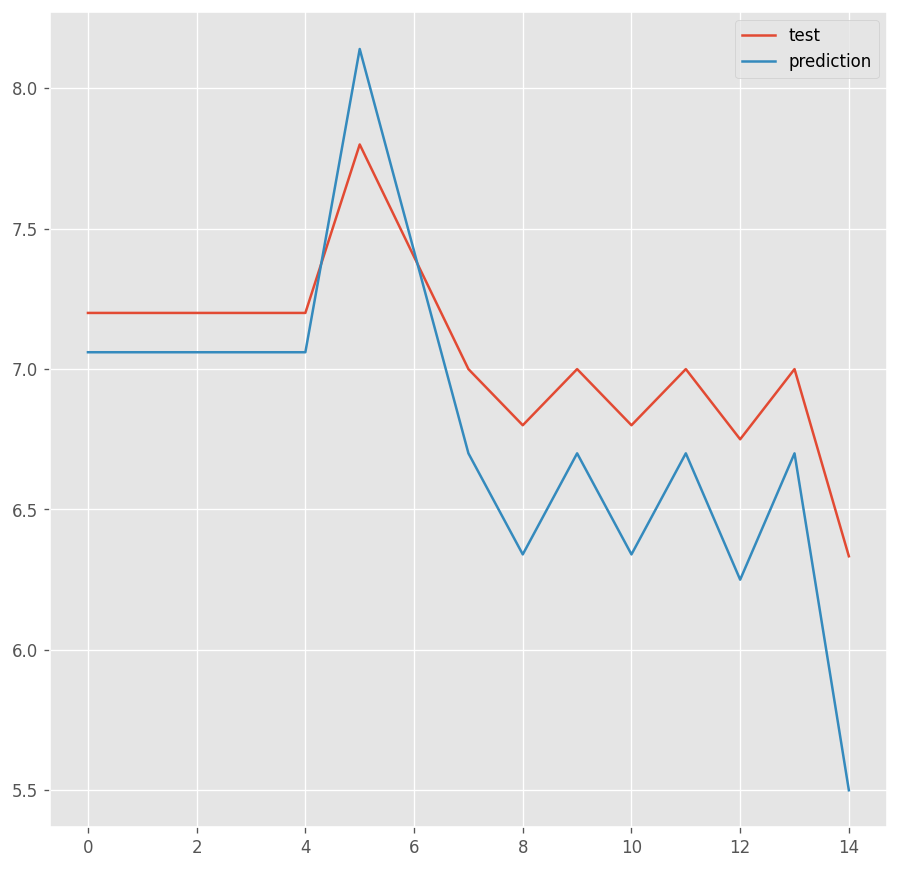

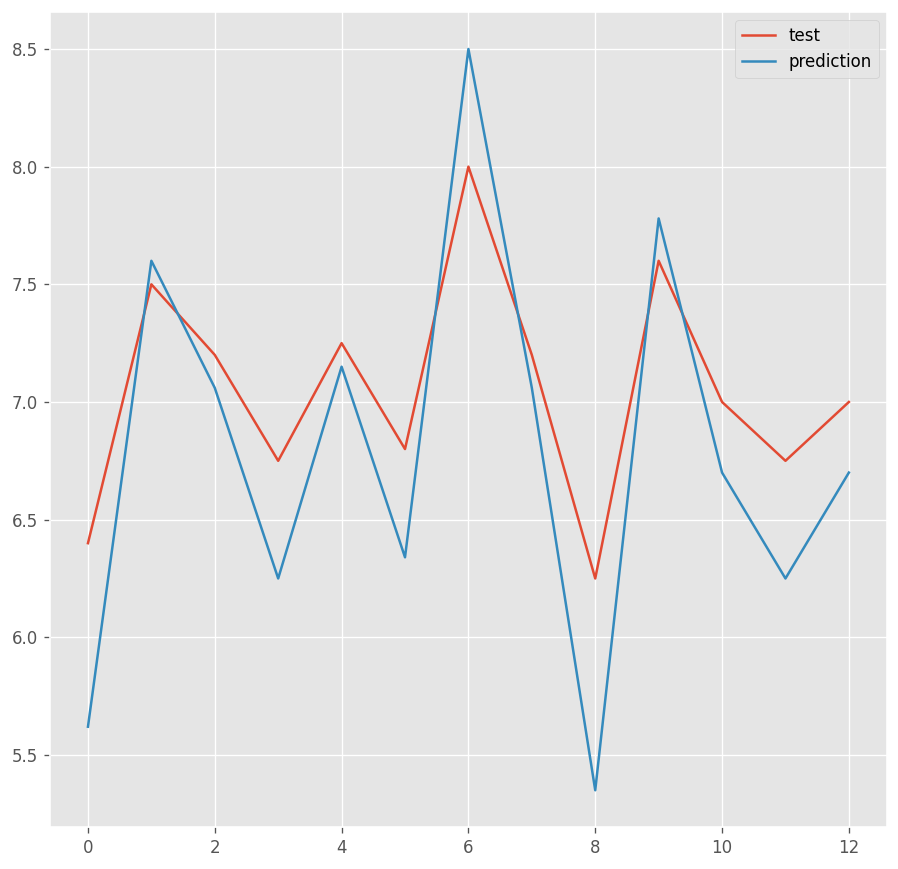

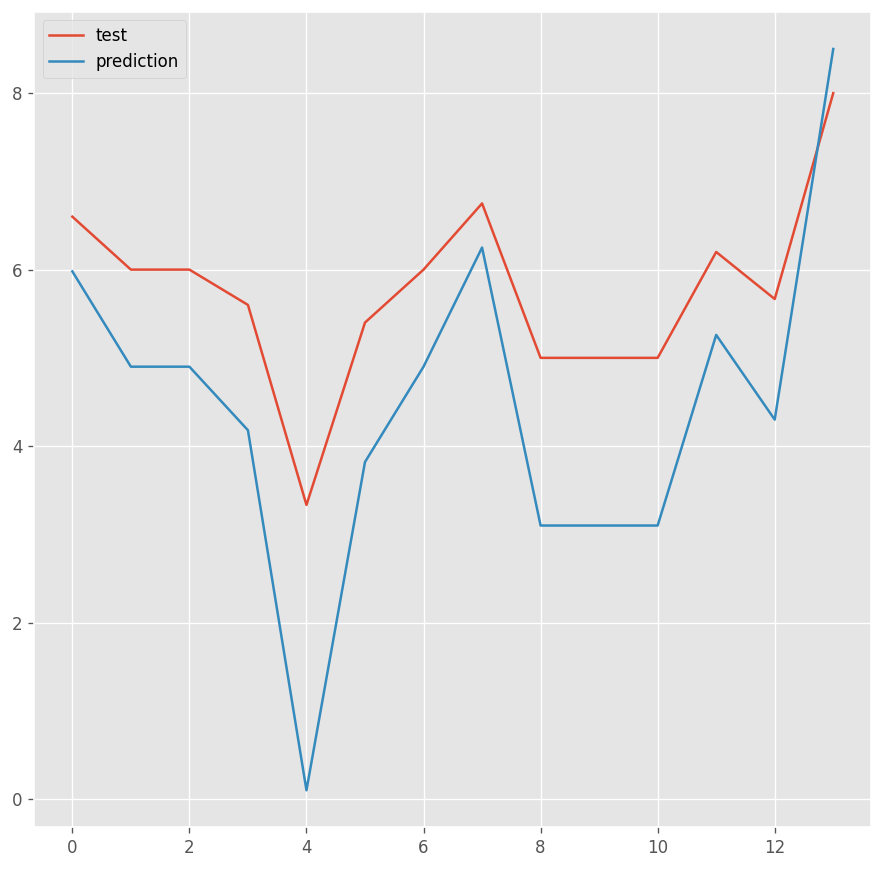

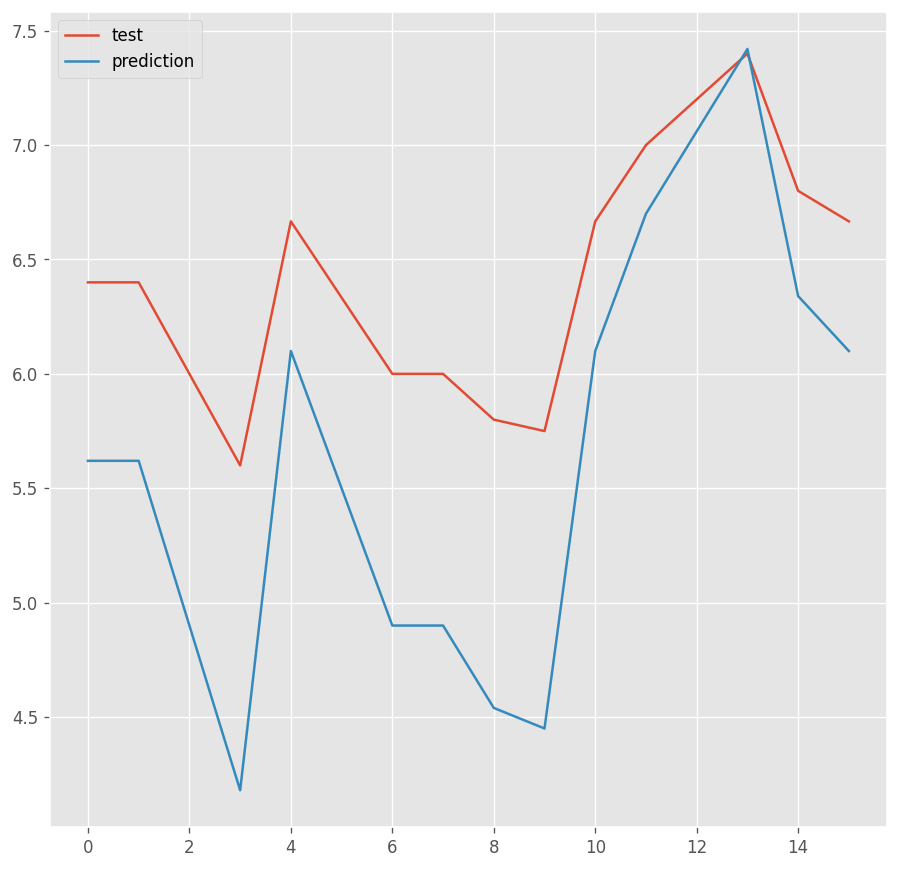

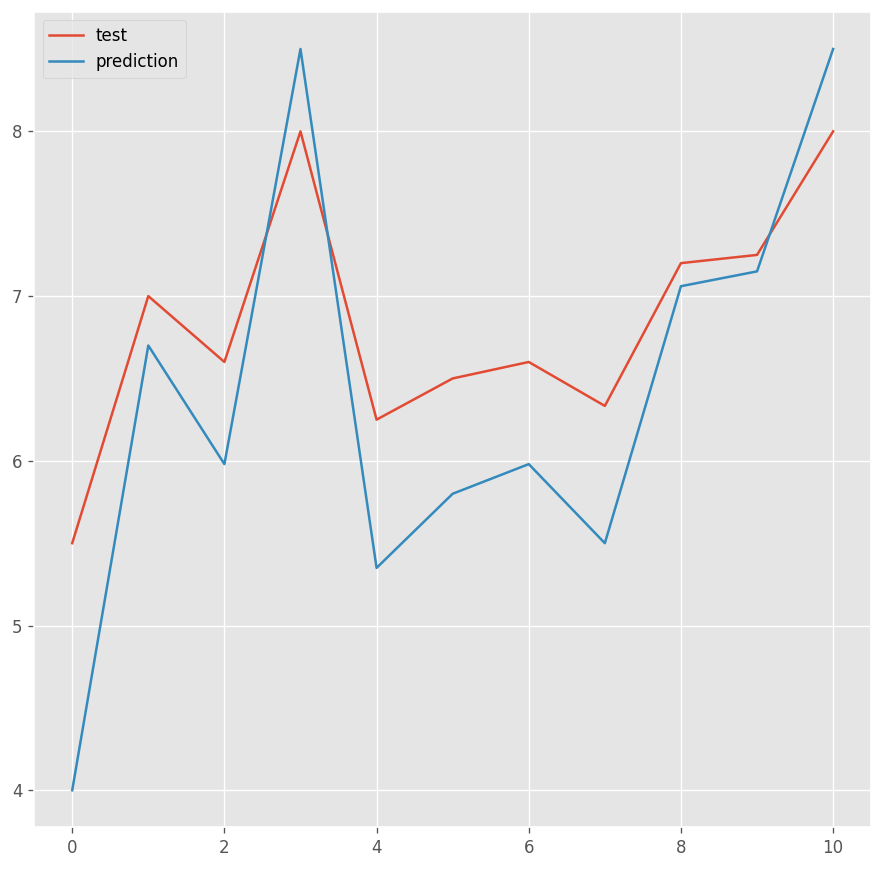

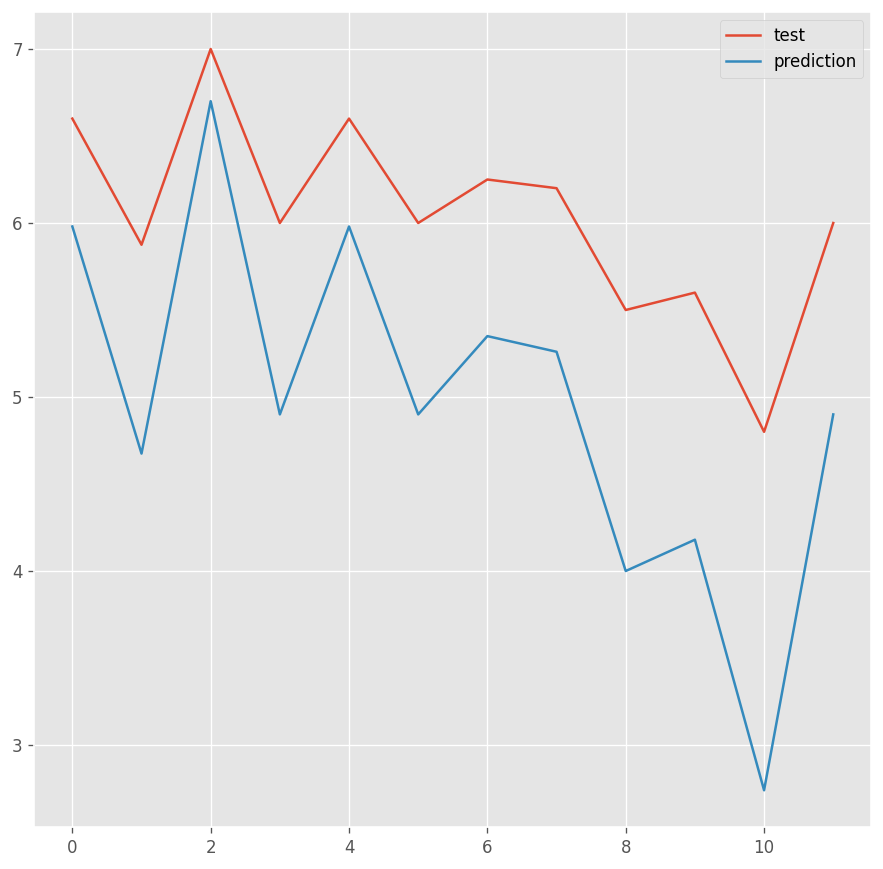

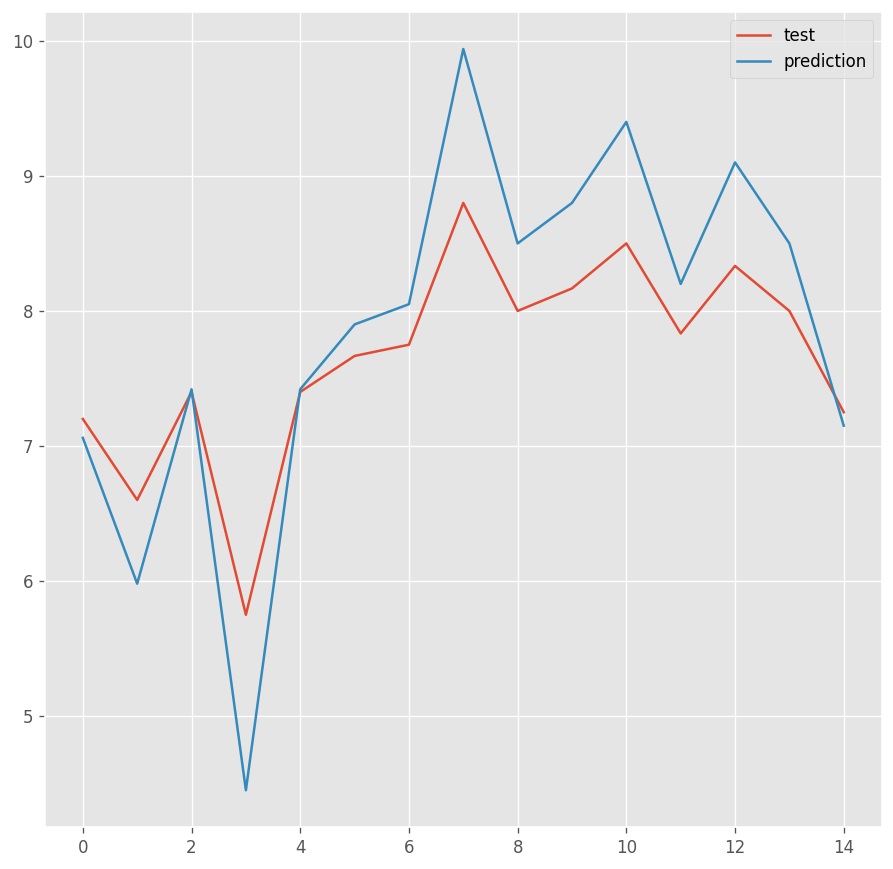

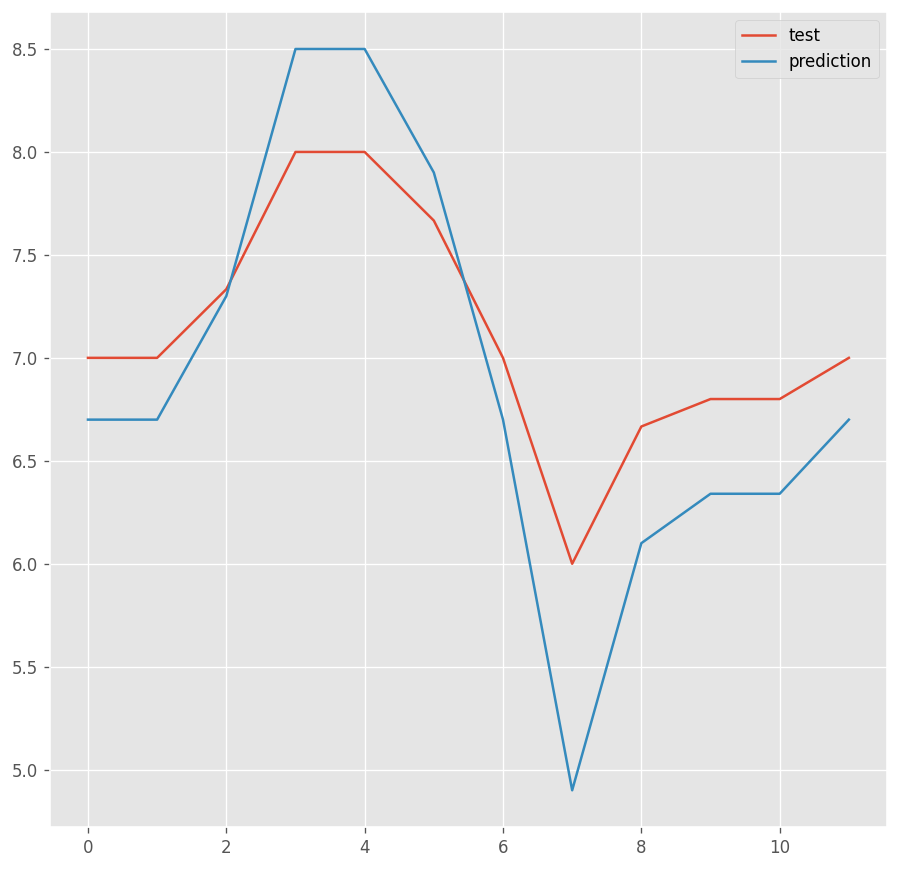

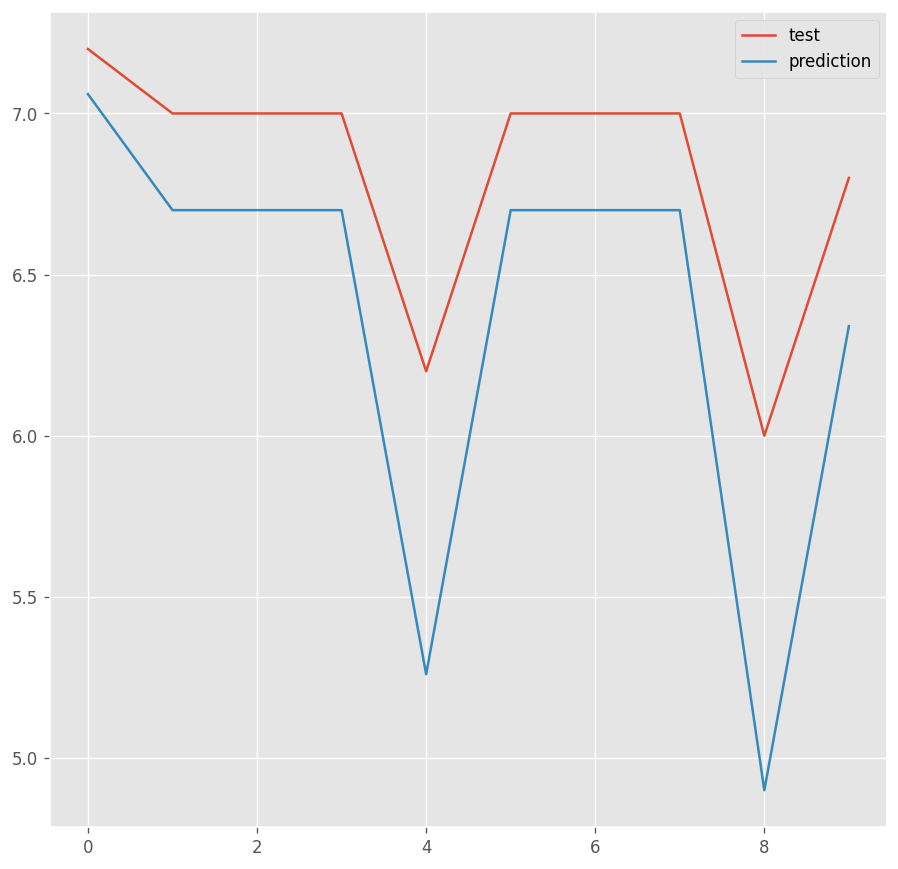

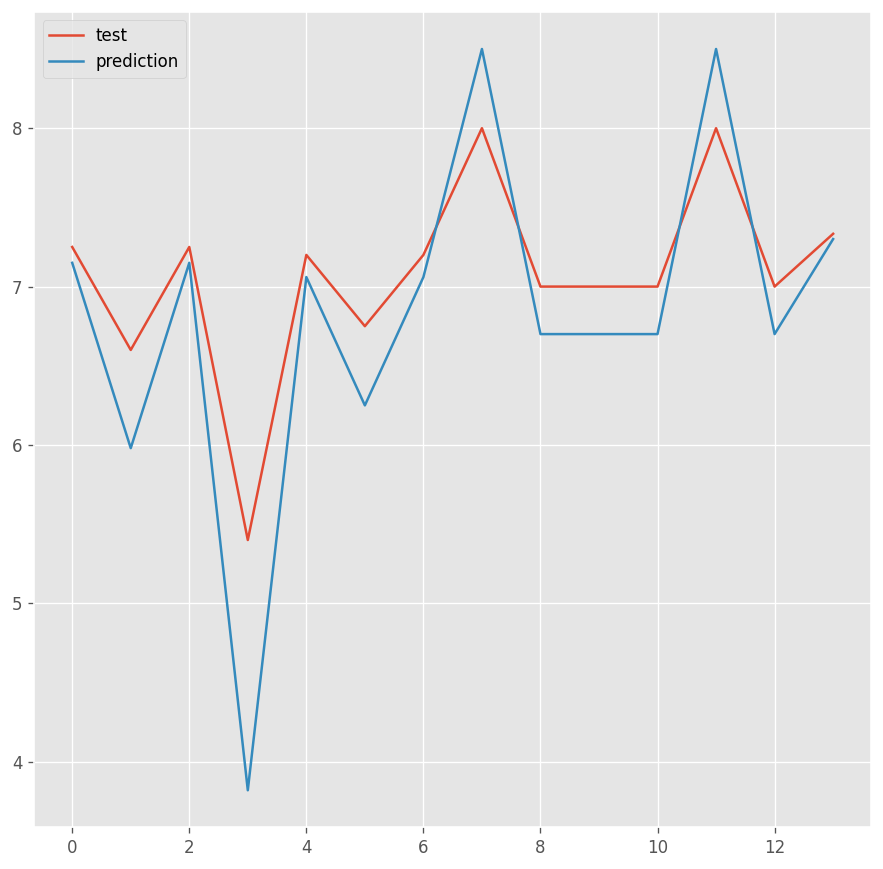

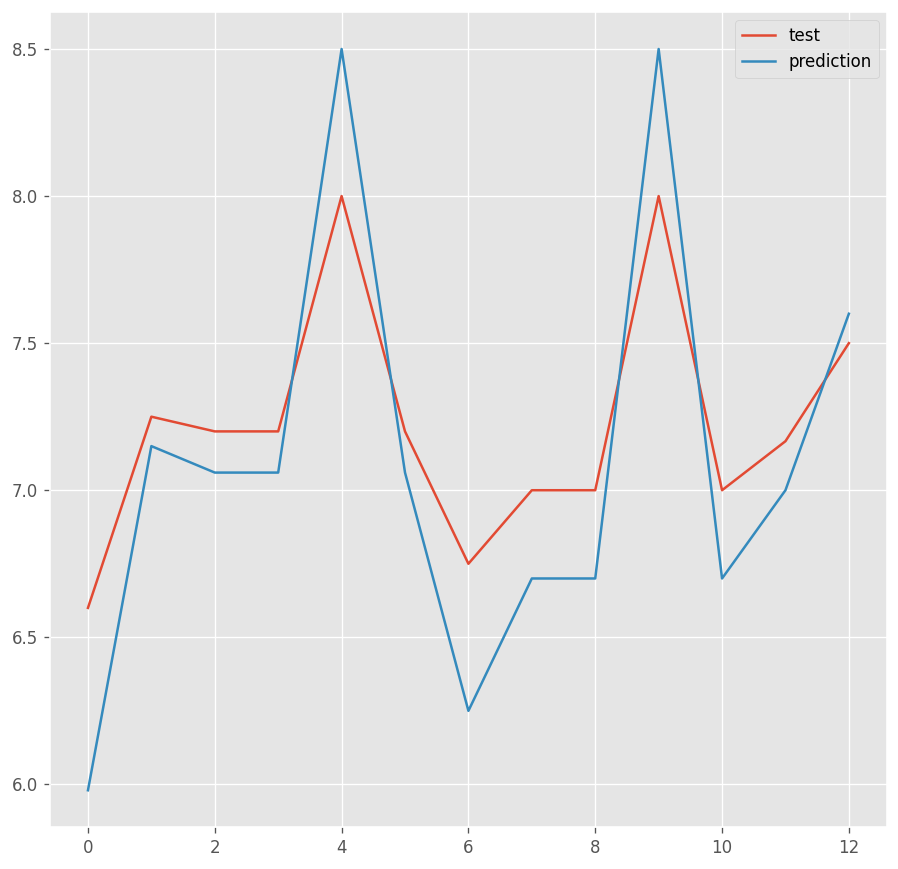

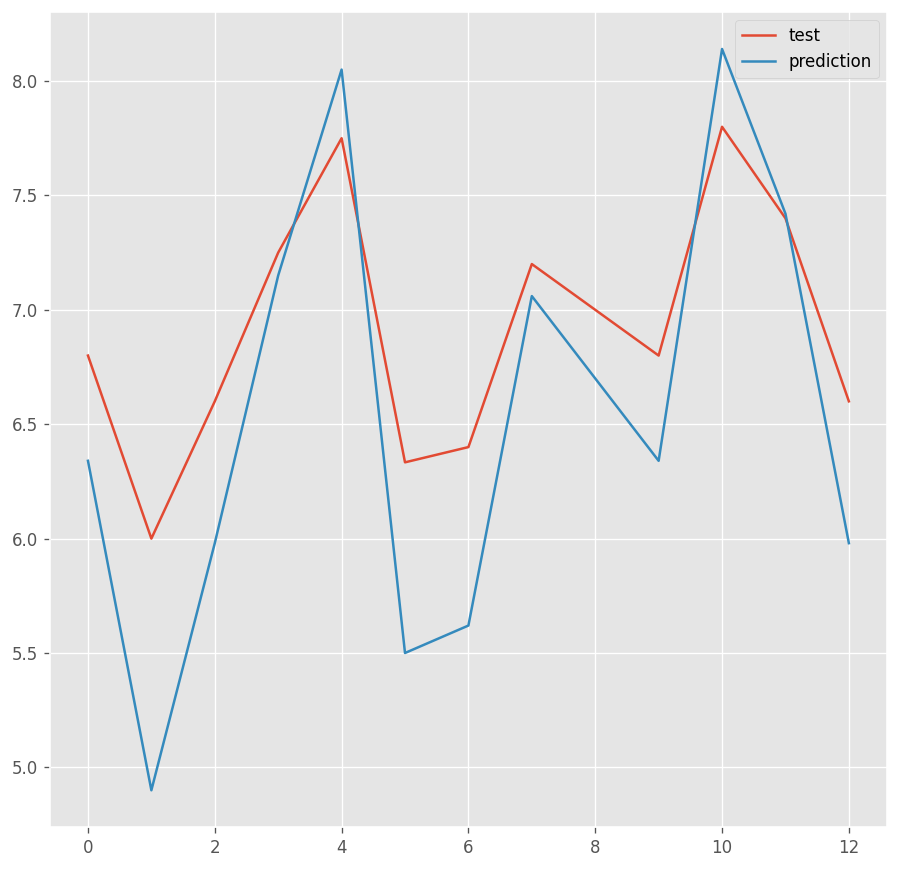

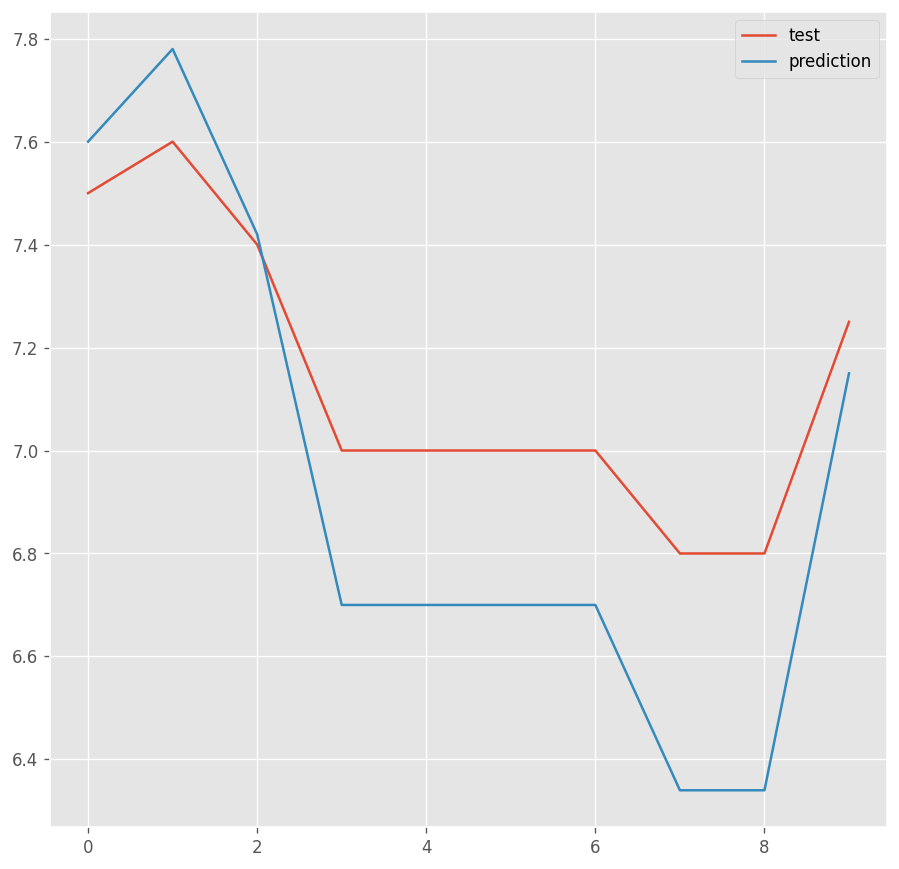

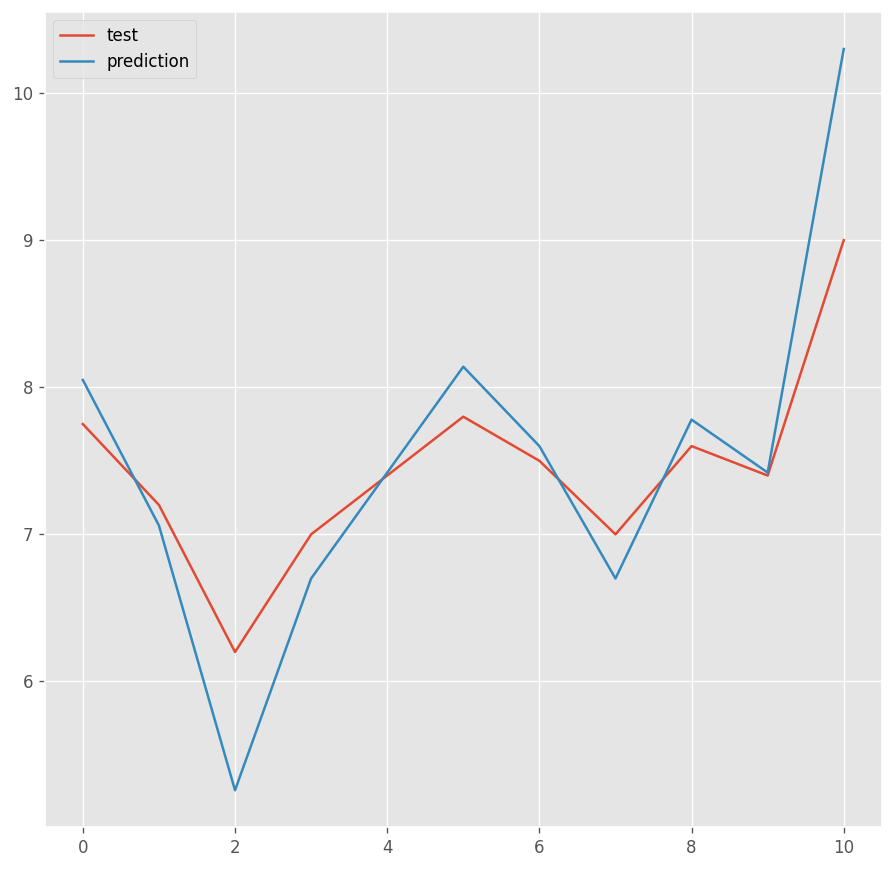

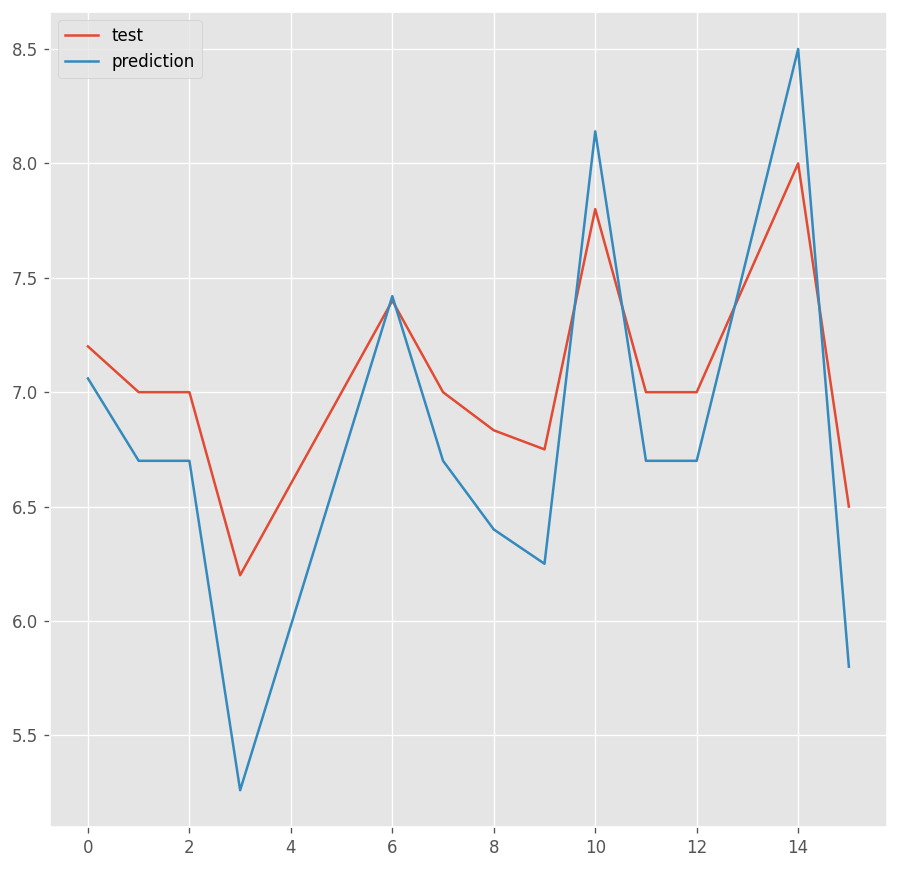

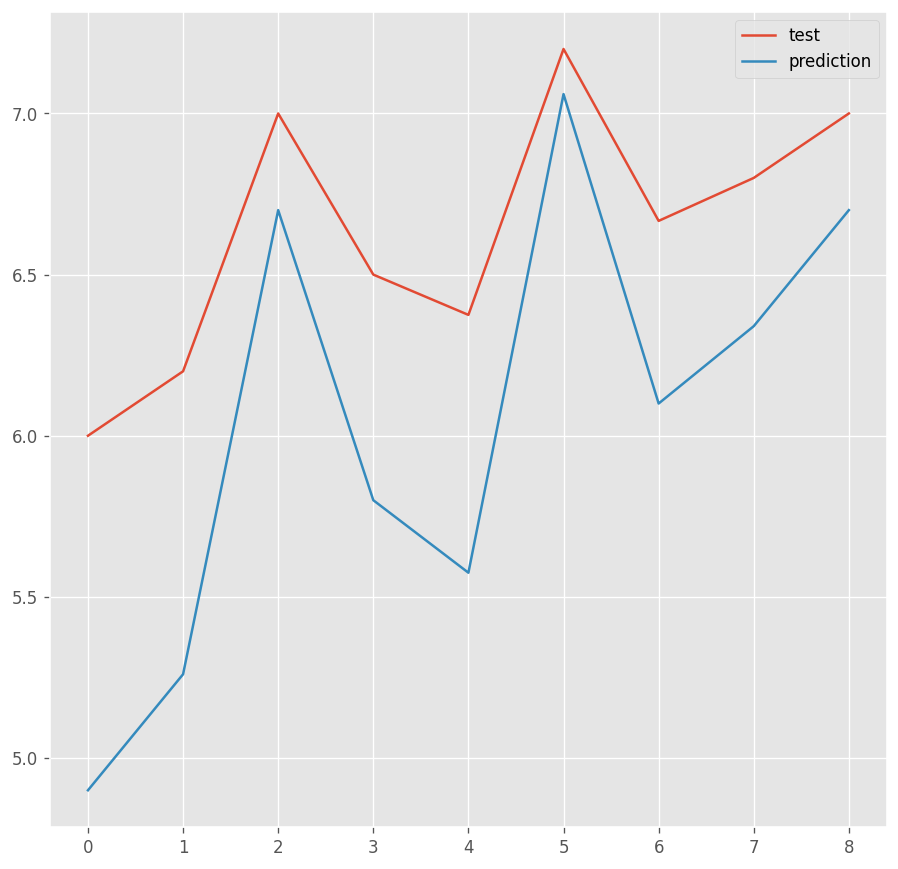

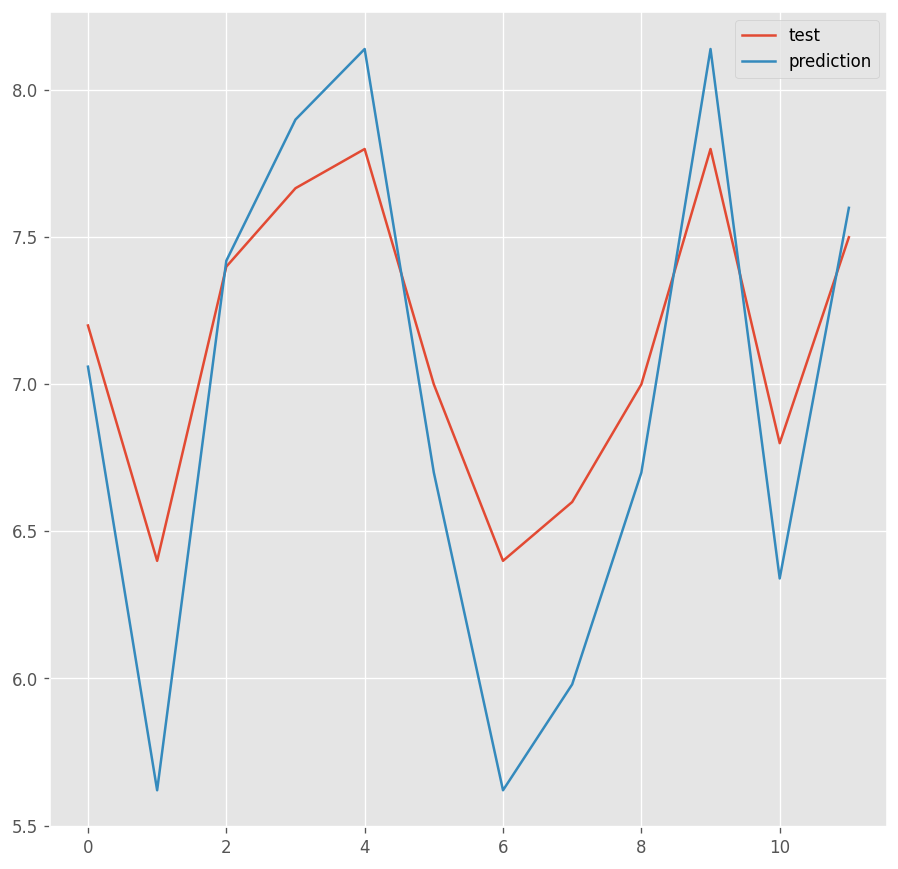

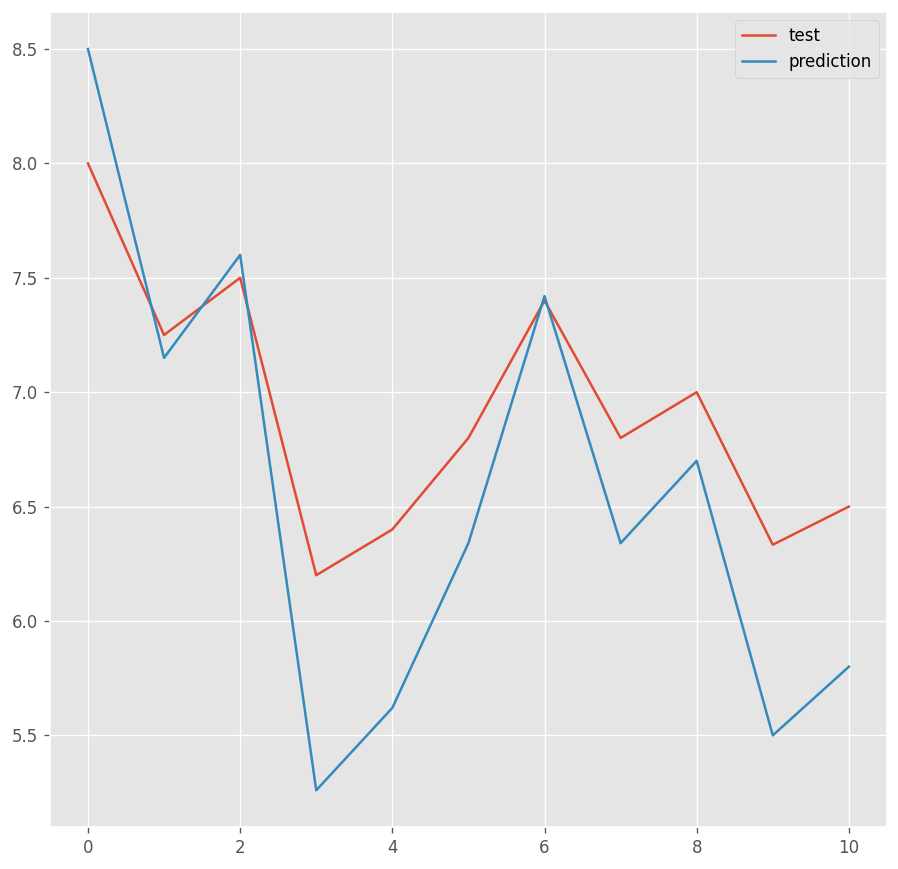

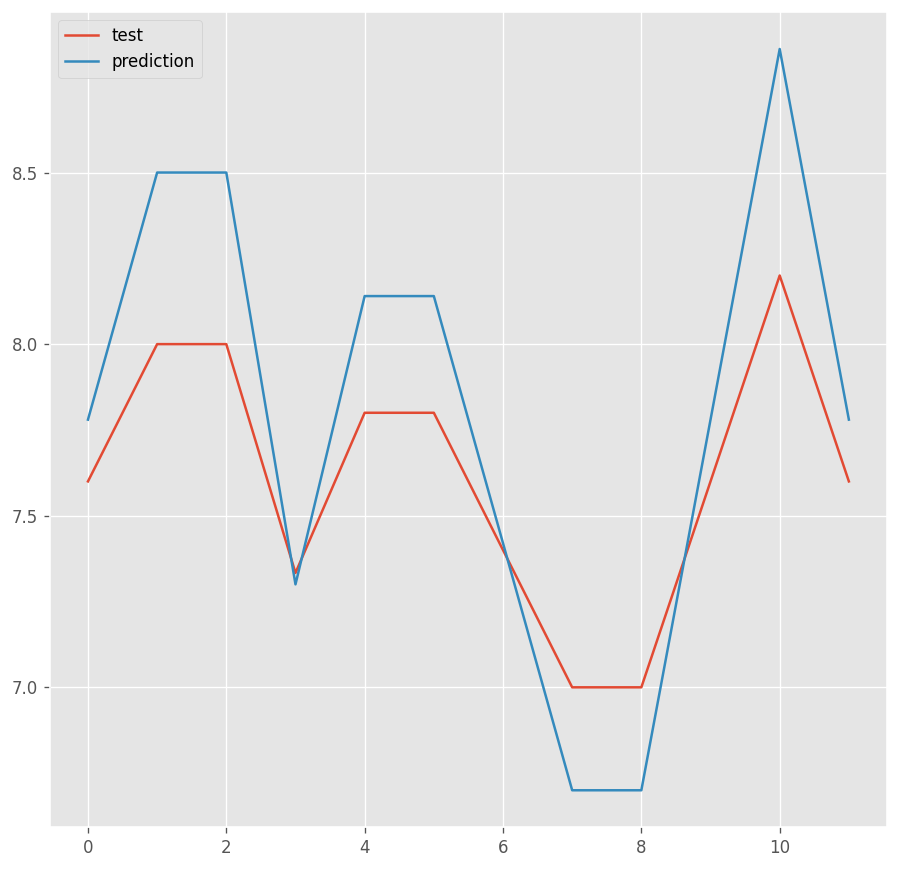

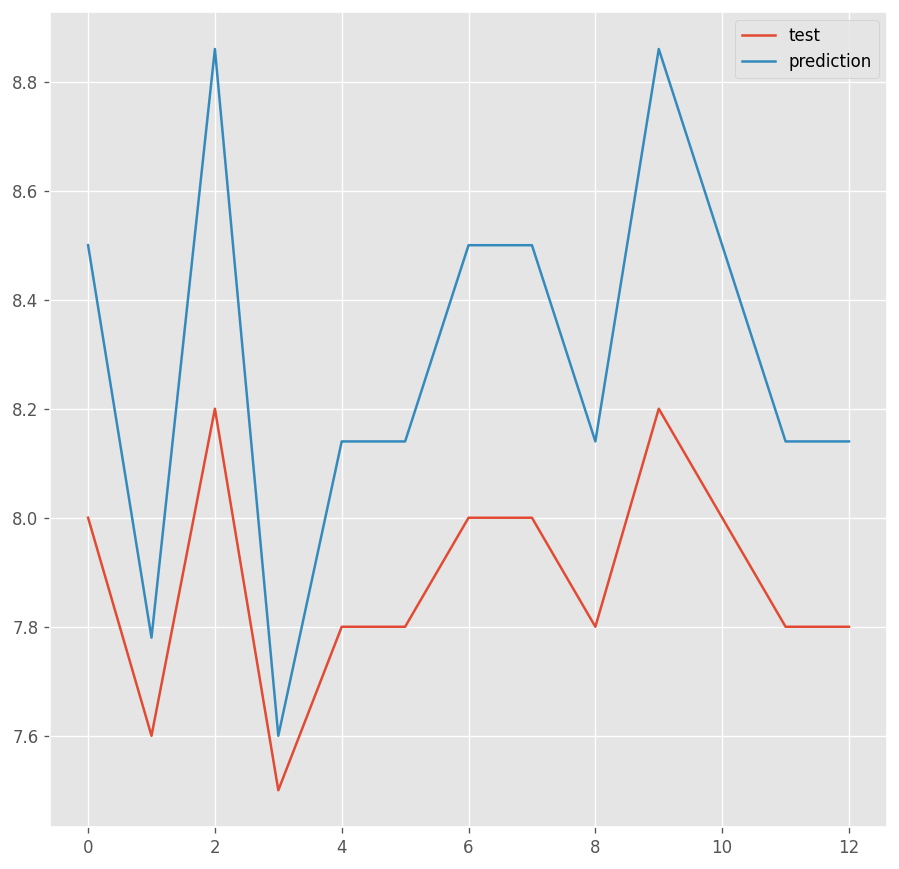

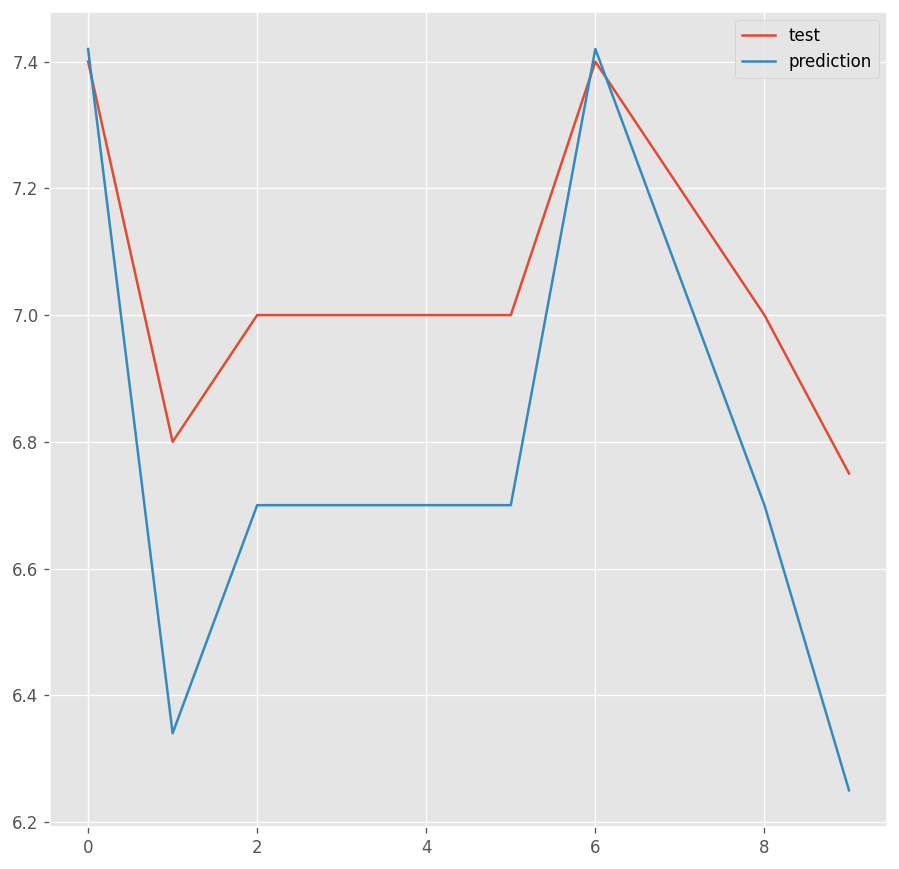

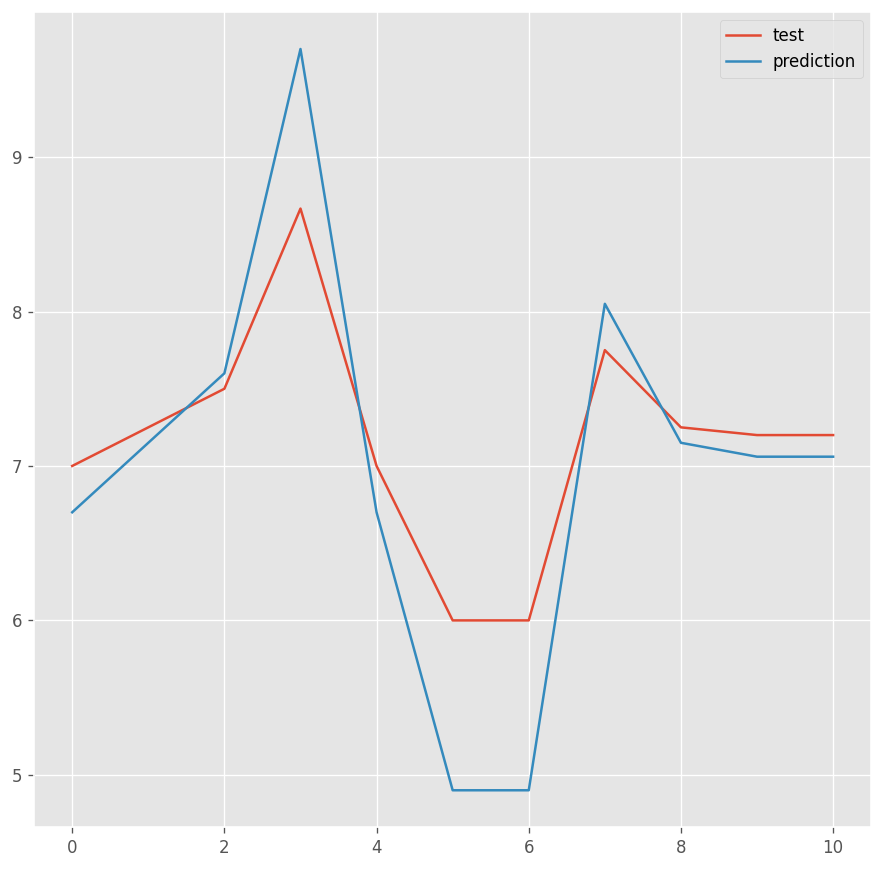

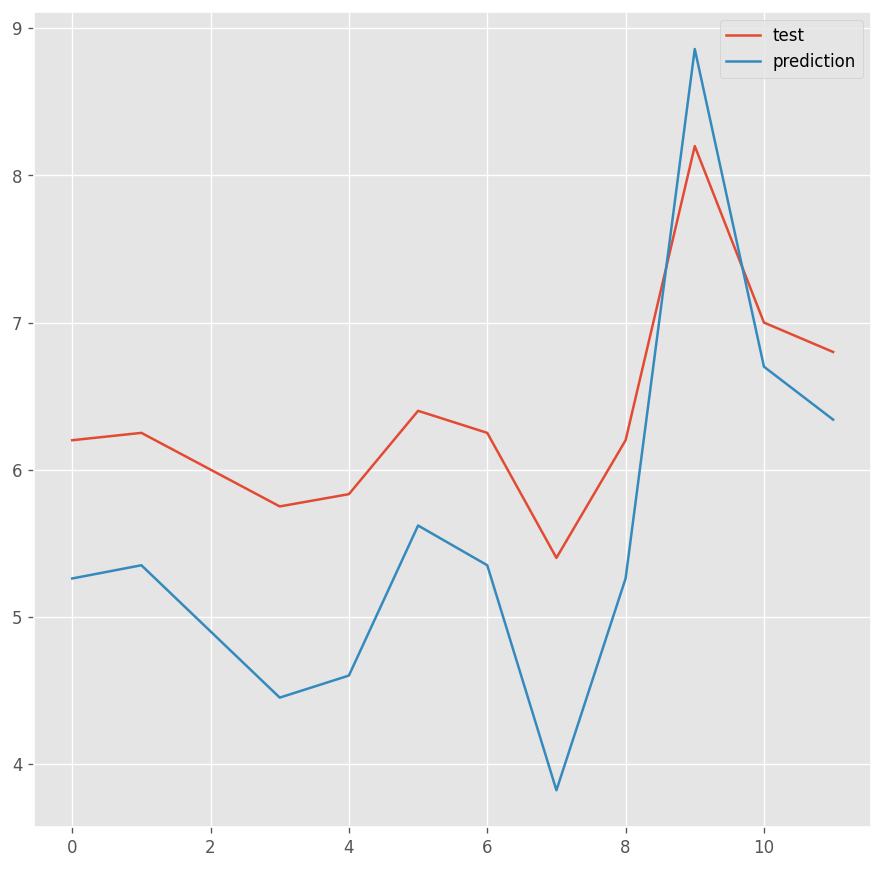

In [91]:
fut_pred = 20
actual_predictions_ids = dict()
predictions_acc = list()

for id in unique_ids:
    test_inputs = train_data_normalized[id][-len(test_data_LSTM[id]):].tolist()
    model.eval()

    for i in range(fut_pred):
        seq = torch.FloatTensor(test_data_LSTM[id][-len(test_data_LSTM[id]):])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs.append(model(seq).item())

    actual_predictions_ids[id] = scaler.inverse_transform(np.array(test_data_LSTM[id][-len(test_data_LSTM[id]):] ).reshape(-1, 1)) - 12.5

    plt.plot(test_data_LSTM[id], label="test")
    plt.plot(actual_predictions_ids[id], label="prediction")
    plt.legend()
    plt.show()

    predictions_acc.append(forecast_accuracy(test_data_LSTM[id], actual_predictions_ids[id], verif_corr=False))

LSTM_acc = pd.DataFrame(predictions_acc, columns=["MAPE", "MAD"], index=unique_ids)

In [92]:
LSTM_acc 

MAPE   MAD
AS14.01   6.69  0.19
AS14.02  17.27 -0.42
AS14.03   5.78 -0.01
AS14.05   7.63 -0.25
AS14.06  11.23 -0.26
AS14.07  33.93 -1.30
AS14.08  16.59 -0.77
AS14.09  18.29 -0.43
AS14.12  20.62 -1.07
AS14.13  16.32  0.21
AS14.14  12.97 -0.22
AS14.15   9.54 -0.44
AS14.16  12.86 -0.24
AS14.17   8.87 -0.12
AS14.19  13.53 -0.37
AS14.20   7.00 -0.19
AS14.23  13.29  0.05
AS14.24  10.80 -0.26
AS14.25  11.76 -0.59
AS14.27  12.05 -0.20
AS14.28  13.88 -0.36
AS14.29   8.46  0.19
AS14.30   6.15  0.41
AS14.31   5.91 -0.26
AS14.32  15.55 -0.17
AS14.33  20.85 -0.81

In [93]:
LSTM_acc.describe()

MAPE        MAD
count  26.000000  26.000000
mean   12.993077  -0.295769
std     6.163004   0.387641
min     5.780000  -1.300000
25%     8.562500  -0.427500
50%    12.455000  -0.255000
75%    16.127500  -0.132500
max    33.930000   0.410000